In [1]:
import os
os.chdir('../..')
!ls

product_impacts


In [2]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%config InlineBackend.figure_format = 'retina'

In [3]:
products_cats = pd.read_csv('../../SFS/environmental_impacts/Products_dat/products_categories.csv')

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (2,5,6,7,8,9,10,11,12,29,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
products_cats.shape

(1154955, 37)

In [5]:
products_cats['database'].value_counts()

openfoodfacts    912480
fooddb           242475
Name: database, dtype: int64

In [6]:
products_cats[products_cats['ingredients_text'].notnull()]['database'].value_counts()

openfoodfacts    641839
fooddb           211869
Name: database, dtype: int64

In [7]:
products_cats[products_cats['ingredients_text'].isna()]['database'].value_counts()

openfoodfacts    270641
fooddb            30606
Name: database, dtype: int64

In [8]:
products_cats[(products_cats['ingredients_text'].notnull()) & (products_cats[['product_name', 'ingredients_text', 'country']].duplicated())]['database'].value_counts()

fooddb           57859
openfoodfacts    10168
Name: database, dtype: int64

In [9]:
products_cats[(products_cats['ingredients_text'].notnull()) & (products_cats[['product_name', 'country']].duplicated())]['database'].value_counts()

openfoodfacts    153829
fooddb            95261
Name: database, dtype: int64

In [10]:
products_cats[products_cats['ingredients_text'].notnull()].shape

(853708, 37)

In [11]:
products_cats[products_cats['ingredients_text'].notnull()]['country'].nunique()

76

In [12]:
df_list = []
for fname in glob.glob(os.path.join('../../SFS/environmental_impacts/Managed_Data', "Total_Impacts_By_Product_sourcing*.csv")):
    df = pd.read_csv(fname)
    df_list.append(df)

impacts = pd.concat(df_list, axis=0, ignore_index=True)

In [13]:
impacts = products_cats.merge(impacts.drop('product_name', axis=1), left_on='product_id', 
                              right_on='id').drop('id', axis=1)

In [14]:
impacts.shape

(789840, 130)

In [15]:
preds = []

for prefix in ['eng/', 'non_eng/']:
    pred = pd.read_csv(f'../../SFS/openfoodfacts/all/predictions/{prefix}predictions_nn.csv')

    # pred = pred[(pred['parentcategory_prob']>0.8)
    #                   & ((pred['subfoodgroup_prob'].isna()) | (pred['subfoodgroup_prob']>0.8))]
    
    preds.append(pred)

off = pd.concat(preds, axis=0, ignore_index=True)
fdb = pd.read_csv('../../SFS/NDNS UK/predictions/all_predictions_15Oct2024.csv').drop('product_name', axis=1).rename(columns={
    'product_list_name': 'product_name',
    'parentcategory_pred': 'parentcategory', 
    'mainfoodgroup_pred': 'mainfoodgroup', 
    'subfoodgroup_pred': 'subfoodgroup'
    })

cols = ['product_id', 'product_name', 'ingredients_text', 'parentcategory', 'mainfoodgroup', 'subfoodgroup',
        'parentcategory_prob', 'subfoodgroup_prob']
categories = pd.concat([off, fdb], axis=0, ignore_index=True)
categories = categories[cols]

In [16]:
df_list = []
for fname in glob.glob(os.path.join('../../SFS/environmental_impacts/Outputs', "*.csv")):
    df = pd.read_csv(fname)
    df_list.append(df)

composition = pd.concat(df_list, axis=0, ignore_index=True)

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7,8,9,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
composition['percent'] = pd.to_numeric(composition['percent'], errors='coerce')

In [18]:
comp_75 = composition[(composition['id'].isin(impacts['product_id'].unique()))]
comp_75 = comp_75[(comp_75['Food_Category'].isna())
                 & (comp_75['Food_Category_sub'].isna())
                 & (comp_75['Food_Category_sub_sub'].isna())]
comp_75 = comp_75.groupby('id')[['percent']].sum().reset_index()
impacts = impacts[~impacts['product_id'].isin(comp_75[comp_75['percent']>25]['id'].unique())].reset_index(drop=True)

In [19]:
products_cats[(products_cats['ingredients_text'].notnull())
    & (products_cats['product_id'].isin(comp_75[comp_75['percent']>25]['id'].unique()))]['database'].value_counts()

openfoodfacts    81764
fooddb           18283
Name: database, dtype: int64

In [20]:
impacts[(impacts['ingredients_text'].notnull()) & (impacts[['product_name', 'ingredients_text', 'country']].duplicated())]['database'].value_counts()

fooddb           49952
openfoodfacts     8475
Name: database, dtype: int64

In [21]:
impacts[(impacts['ingredients_text'].notnull()) & (impacts[['product_name', 'country']].duplicated())]['database'].value_counts()

openfoodfacts    109401
fooddb            76817
Name: database, dtype: int64

In [22]:
# 2 products have empty product names, removing them
impacts = impacts[impacts['product_name'].notnull()]
# removing duplicated product names
impacts = impacts.drop_duplicates(subset=['product_name', 
                                          # 'ingredients_text', 
                                          'country'])

In [23]:
impacts.shape

(503575, 130)

In [24]:
cat_map = pd.read_csv('../../SFS/environmental_impacts/Products_dat/cat_map.csv')

In [25]:
impacts = impacts.merge(cat_map)

In [26]:
# split dairy and dairy alternatives

ids = impacts[impacts['Department'].isin(['Milk and Milk Products'])]['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids)]
milk_ids = composition_sub[composition_sub['Food_Category'].isin(['Milk', 'Cheese', 'Butter, Cream & Ghee'])]['id'].unique()
vegan_milk_ids = set(composition_sub[(composition_sub['Food_Category'].isin([
    'Other Fruit', 'Nuts','Other Pulses', 'Oatmeal', 'Rice']))]['id'].unique()).difference(set(milk_ids))
vegan_milk_ids = vegan_milk_ids.difference(composition_sub[(composition_sub['Food_Category'].isin([
    'Eggs', 'Fish (farmed)',
    'Lamb & Mutton', 'Bovine Meat (dairy herd)',
    'Milk Chocolate', 'Bovine Meat (beef herd)']))]['id'].unique())

impacts.loc[impacts['product_id'].isin(vegan_milk_ids), 'labels'] = 'Milk alternatives'
impacts.loc[impacts['product_id'].isin(vegan_milk_ids), 'ID'] = '2G'

impacts.loc[(impacts['product_id'].isin(ids))
           & (~impacts['product_id'].isin(vegan_milk_ids))
           & (~impacts['product_id'].isin(milk_ids)), 'labels'] = 'mis'

In [27]:
# meat alternatives 

veg_meat_ids = impacts[impacts['labels']=='Meat alternatives']['product_id'].unique()
composition_sub = composition[composition['id'].isin(veg_meat_ids)]

id_pig = composition_sub[composition_sub['Food_Category'].isin([
    'Pig Meat'
])]['id'].unique()

impacts.loc[impacts['product_id'].isin(id_pig), 'labels'] = 'Pig meat'
impacts.loc[impacts['product_id'].isin(id_pig), 'groups'] = 'Meat and Fish'
impacts.loc[impacts['product_id'].isin(id_pig), 'ID'] = '3D'

id_poultry = composition_sub[(~composition_sub['product_name'].str.lower().str.contains('linda mccartney')) & (composition_sub['Food_Category'].isin([
    'Poultry Meat'
]))]['id'].unique()

impacts.loc[impacts['product_id'].isin(id_poultry), 'labels'] = 'Poultry meat'
impacts.loc[impacts['product_id'].isin(id_poultry), 'groups'] = 'Meat and Fish'
impacts.loc[impacts['product_id'].isin(id_poultry), 'ID'] = '3C'

id_beef = composition_sub[composition_sub['Food_Category'].isin([
    'Bovine Meat (dairy herd)', 'Bovine Meat (beef herd)'
])]['id'].unique()

impacts.loc[impacts['product_id'].isin(id_beef), 'labels'] = 'Beef'
impacts.loc[impacts['product_id'].isin(id_beef), 'groups'] = 'Meat and Fish'
impacts.loc[impacts['product_id'].isin(id_beef), 'ID'] = '3E'

id_lamb = composition_sub[composition_sub['Food_Category'].isin([
    'Lamb & Mutton'
])]['id'].unique()

impacts.loc[impacts['product_id'].isin(id_lamb), 'labels'] = 'Lamb'
impacts.loc[impacts['product_id'].isin(id_lamb), 'groups'] = 'Meat and Fish'
impacts.loc[impacts['product_id'].isin(id_lamb), 'ID'] = '3F'

In [28]:
# split meat with meat dishes

# Chicken and turkey
ids = impacts[impacts['labels']=='Chicken and turkey']['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids)]

id_true = composition_sub[composition_sub['Food_Category'].isin(['Poultry Meat'])]['id'].unique()
composition_true = composition_sub[composition_sub['Food_Category'].isin(['Poultry Meat'])]

composition_mis = composition_sub[~composition_sub['id'].isin(id_true)]
id_false = composition_mis['id'].unique()

composition_true = composition_true.groupby('id')[['percent']].sum().reset_index()
impacts.loc[impacts['product_id'].isin(id_false), 'labels'] = 'mis'
impacts.loc[impacts['product_id'].isin(composition_true[composition_true['percent']<=50]['id'].unique()), 'labels'] = 'Meat dishes'
impacts.loc[impacts['product_id'].isin(composition_true[composition_true['percent']<=50]['id'].unique()), 'ID'] = '3K'


# Beef
impacts.loc[impacts['product_name'].str.lower().str.contains('biltong'), 'Department'] = 'Meat and Meat Products'
impacts.loc[impacts['product_name'].str.lower().str.contains('biltong'), 'Aisle'] = 'Beef, veal and dishes'
impacts.loc[impacts['product_name'].str.lower().str.contains('biltong'), 'Shelf'] = 'Beef and veal'
impacts.loc[impacts['product_name'].str.lower().str.contains('biltong'), 'labels'] = 'Beef'
impacts.loc[impacts['product_name'].str.lower().str.contains('biltong'), 'groups'] = 'Meat and Fish'
impacts.loc[impacts['product_name'].str.lower().str.contains('biltong'), 'ID'] = '3E'
ids = impacts[impacts['labels']=='Beef']['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids)]

id_true = composition_sub[composition_sub['Food_Category'].isin([
    'Bovine Meat (dairy herd)','Bovine Meat (beef herd)'])]['id'].unique()
composition_true = composition_sub[composition_sub['Food_Category'].isin([
    'Bovine Meat (dairy herd)','Bovine Meat (beef herd)'])]

composition_mis = composition_sub[~composition_sub['id'].isin(id_true)]
id_false = composition_mis['id'].unique()

composition_true = composition_true.groupby('id')[['percent']].sum().reset_index()
impacts.loc[impacts['product_id'].isin(id_false), 'labels'] = 'mis'
impacts.loc[impacts['product_id'].isin(composition_true[composition_true['percent']<=50]['id'].unique()), 'labels'] = 'Meat dishes'
impacts.loc[impacts['product_id'].isin(composition_true[composition_true['percent']<=50]['id'].unique()), 'ID'] = '3K'


# Burgers and kebabs
# Other meat products
# Sausages

# Pig meat
ids = impacts[impacts['labels']=='Pork']['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids)]

id_true = composition_sub[composition_sub['Food_Category'].isin(['Pig Meat'])]['id'].unique()
composition_true = composition_sub[composition_sub['Food_Category'].isin(['Pig Meat'])]

composition_mis = composition_sub[~composition_sub['id'].isin(id_true)]
id_false = composition_mis['id'].unique()

composition_true = composition_true.groupby('id')[['percent']].sum().reset_index()
impacts.loc[impacts['product_id'].isin(id_false), 'labels'] = 'mis'
impacts.loc[impacts['product_id'].isin(composition_true[composition_true['percent']<=50]['id'].unique()), 'labels'] = 'Meat dishes'
impacts.loc[impacts['product_id'].isin(composition_true[composition_true['percent']<=50]['id'].unique()), 'ID'] = '3K'


# Meat pies and pastries
# Other meat products
              
# Lamb 
ids = impacts[impacts['labels']=='Lamb']['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids)]

id_true = composition_sub[composition_sub['Food_Category'].isin(['Lamb & Mutton'])]['id'].unique()
composition_true = composition_sub[composition_sub['Food_Category'].isin(['Lamb & Mutton'])]

composition_mis = composition_sub[~composition_sub['id'].isin(id_true)]
id_false = composition_mis['id'].unique()

composition_true = composition_true.groupby('id')[['percent']].sum().reset_index()
impacts.loc[impacts['product_id'].isin(id_false), 'labels'] = 'mis'
impacts.loc[impacts['product_id'].isin(composition_true[composition_true['percent']<=50]['id'].unique()), 'labels'] = 'Meat dishes'
impacts.loc[impacts['product_id'].isin(composition_true[composition_true['percent']<=50]['id'].unique()), 'ID'] = '3K'


In [29]:
impacts['database'].value_counts()

openfoodfacts    398860
fooddb           104715
Name: database, dtype: int64

In [30]:
impacts[impacts['labels']=='mis'].shape

(4113, 133)

In [31]:
impacts[impacts['labels']!='mis']['country'].nunique()

74

In [32]:
impacts[impacts['labels']!='mis'].shape

(499462, 133)

In [33]:
impacts['country'].value_counts()

United States           147409
United Kingdom          123485
France                   98320
Germany                  26964
Spain                    14220
Switzerland              11639
Italy                     9007
Belgium                   8607
Canada                    6651
Australia                 5284
Netherlands               5142
Poland                    3436
Ireland                   3074
Mexico                    2362
Austria                   2269
Sweden                    2243
New Zealand               1968
Czech Republic            1951
Finland                   1898
Portugal                  1884
Bulgaria                  1807
Norway                    1781
Romania                   1521
Bolivia                   1513
Argentina                 1244
Russia                    1232
India                     1206
Brazil                    1174
Thailand                  1042
Hungary                    960
Croatia                    922
Luxembourg                 804
Denmark 

In [34]:
set(products_cats['country'].unique()).difference(set(impacts['country'].unique()))

{'Serbia', 'South Africa'}

In [35]:
impacts[['mean_Land', 'mean_GHG', 'mean_Eut', 'mean_WatScar', 'mean_Biodiversity']].corr() # doesnt matter that these are not normalized for corrs

mean_Land  mean_GHG  mean_Eut  mean_WatScar  \
mean_Land           1.000000  0.623448  0.797024      0.241272   
mean_GHG            0.623448  1.000000  0.448923      0.319751   
mean_Eut            0.797024  0.448923  1.000000      0.185078   
mean_WatScar        0.241272  0.319751  0.185078      1.000000   
mean_Biodiversity   0.707287  0.518750  0.630704      0.106313   

                   mean_Biodiversity  
mean_Land                   0.707287  
mean_GHG                    0.518750  
mean_Eut                    0.630704  
mean_WatScar                0.106313  
mean_Biodiversity           1.000000

In [36]:
# impacts.groupby('labels')[['mean_Land', 'mean_GHG', 'mean_Eut', 'mean_WatScar', 'mean_Biodiversity']].corr()

#### not normalized - raw scores

In [37]:
score_columns = ['Land', 
                 'GHG', 
                 'Eut', 
                 'WatScar',
                 'Biodiversity', 
                 # 'Acidification', 
                 # 'WaterUse'
                ]

In [38]:
# Melt the aggregated dataframe to long format for seaborn
melted_df = impacts.melt(
    id_vars=['country', 'groups', 'labels', 'ID', 'product_id'],
    value_vars=[f"mean_{score}" for score in score_columns],
    var_name='score',
    value_name='mean'
)

# Extract the score name
melted_df['score'] = melted_df['score'].str.replace('_mean', '')
melted_df['score'] = melted_df['score'].str.replace('mean_', '')

In [39]:
df_plot = melted_df[melted_df['country'].isin(['United Kingdom', 'France', 'United States'])]
df_plot = df_plot[df_plot['labels']!='mis']

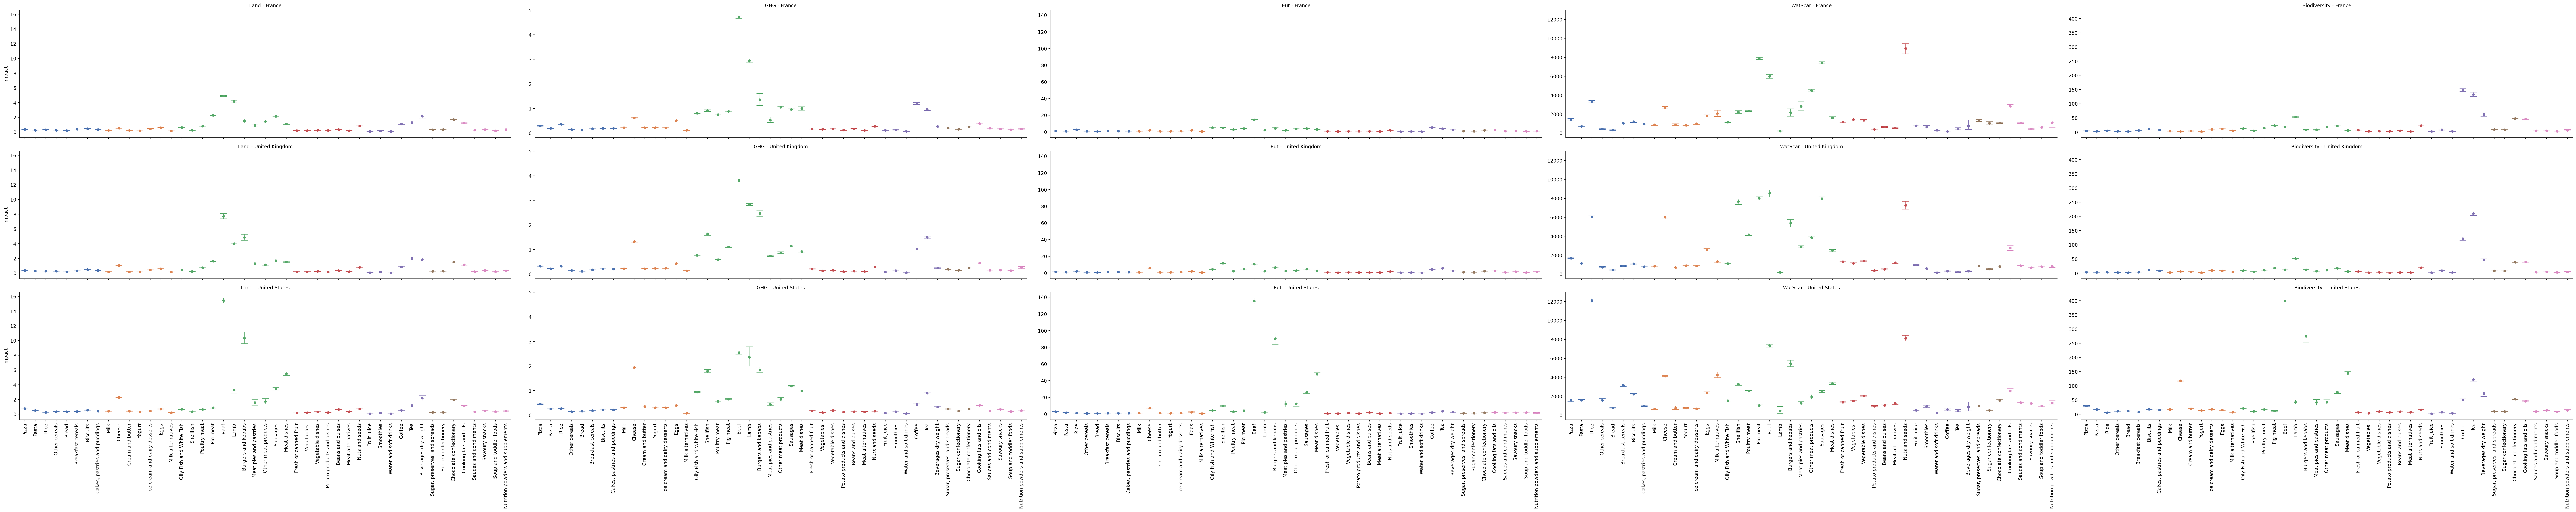

In [40]:
# Initialize the FacetGrid
g = sns.FacetGrid(df_plot, 
                  row='country', 
                  col='score', 
                  sharey='col',
                  row_order=['France', 'United Kingdom', 'United States'],
                  height=5, aspect=3)

# Define the plotting function
def plot_errorbar(data, color, **kwargs):
    sns.pointplot(
        x='labels', 
        y='mean', 
        hue='groups',
        data=data.sort_values(by=['ID']), 
        join=False, 
        capsize=0.6,
        errorbar='se',
        errwidth=0.8, 
        markers='.',
        markersize=0.5,
        palette='deep'
    )

# Map the plotting function to each facet
g.map_dataframe(plot_errorbar)

# Rotate x-axis labels vertically
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Add axis labels
g.set_axis_labels("", "Impact")
g.set_titles("{col_name} - {row_name}")

plt.tight_layout()
plt.show()


#### normalized but not aggregated

In [40]:
def get_norm(g):
    g['mean_norm'] = 100 * (g['mean'] - g['mean'].min()) / (g['mean'].max() - g['mean'].min())
    return g

In [41]:
melted_df = melted_df.groupby('score').apply(lambda g: get_norm(g)).reset_index(drop=True)

In [42]:
df_plot = melted_df[melted_df['country'].isin(['United Kingdom', 'France', 'United States'])]
df_plot = df_plot[df_plot['labels']!='mis']

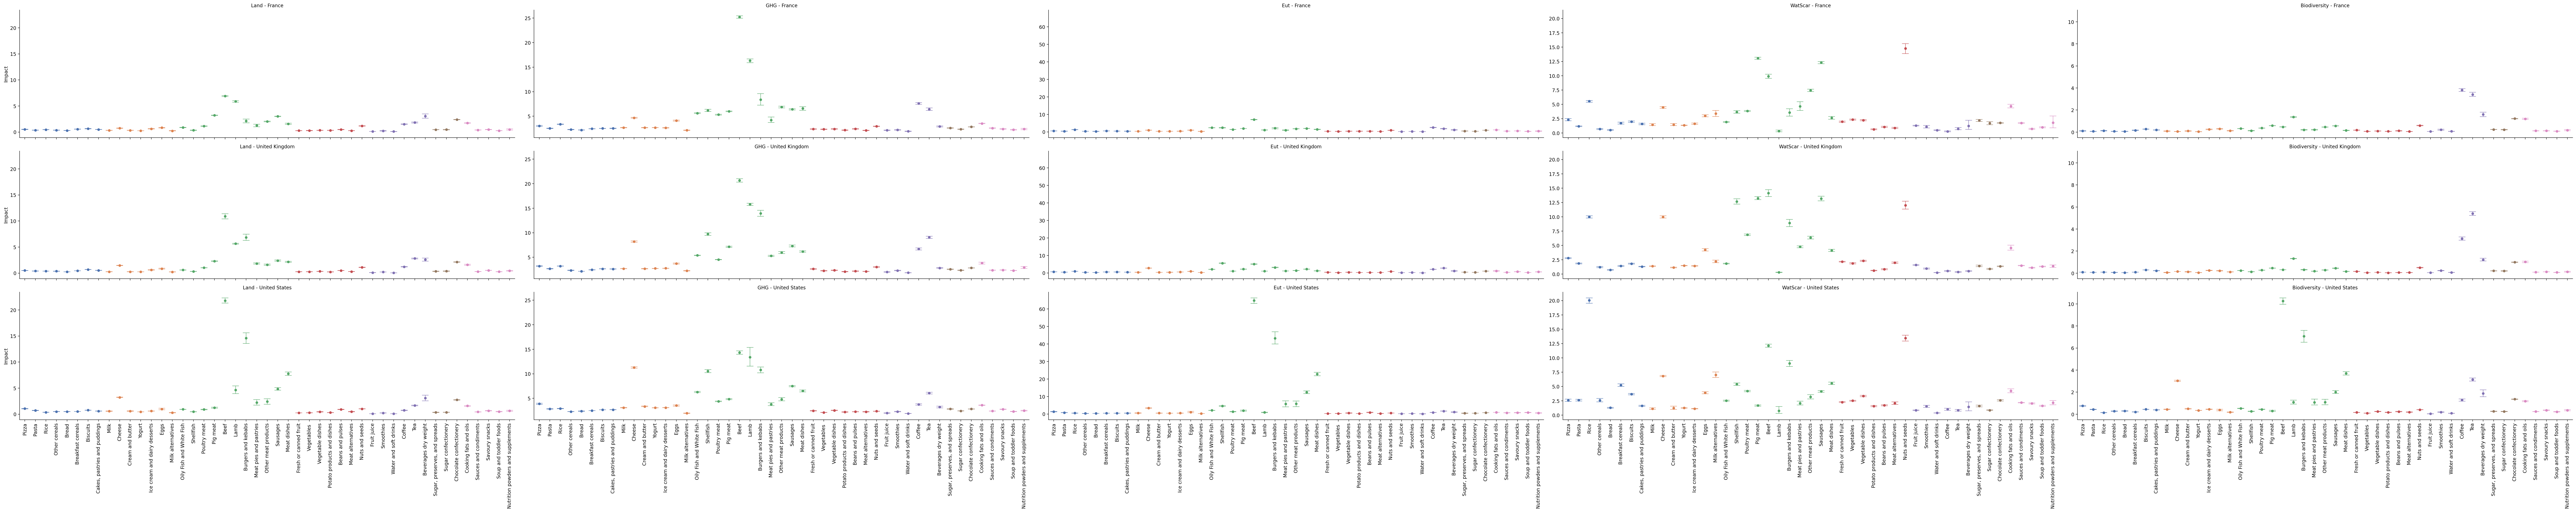

In [44]:
# Initialize the FacetGrid
g = sns.FacetGrid(df_plot, 
                  row='country', 
                  col='score', 
                  sharey='col',
                  row_order=['France', 'United Kingdom', 'United States'],
                  height=5, aspect=3)

# Define the plotting function
def plot_errorbar(data, color, **kwargs):
    sns.pointplot(
        x='labels', 
        y='mean_norm', 
        hue='groups',
        data=data.sort_values(by=['ID']), 
        join=False, 
        capsize=0.6,
        errorbar='se',
        errwidth=0.8,  
        markers='.',
        markersize=0.5,
        palette='deep'
    )

# Map the plotting function to each facet
g.map_dataframe(plot_errorbar)

# Rotate x-axis labels vertically
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Add axis labels
g.set_axis_labels("", "Impact")
g.set_titles("{col_name} - {row_name}")

plt.tight_layout()
plt.show()


#### normalized and aggregated

In [43]:
melted_df = melted_df.groupby(['country', 'groups', 'labels', 'ID', 'product_id'])[['mean_norm']].mean().reset_index()

In [44]:
melted_df['mean_norm'] = 100 * (melted_df['mean_norm'] - melted_df['mean_norm'].min()) / (melted_df['mean_norm'].max() - melted_df['mean_norm'].min())

In [45]:
df_plot = melted_df[melted_df['country'].isin(['United Kingdom', 'France', 'United States'])]
df_plot = df_plot[df_plot['labels']!='mis']

In [46]:
order_df = df_plot.groupby('groups')[['mean_norm']].mean().reset_index().sort_values(
    by=['mean_norm']).reset_index(drop=True).drop('mean_norm', axis=1).merge(
    df_plot.groupby(['groups','labels'])[['mean_norm']].mean().reset_index().sort_values(
        by=['mean_norm']).reset_index(drop=True))

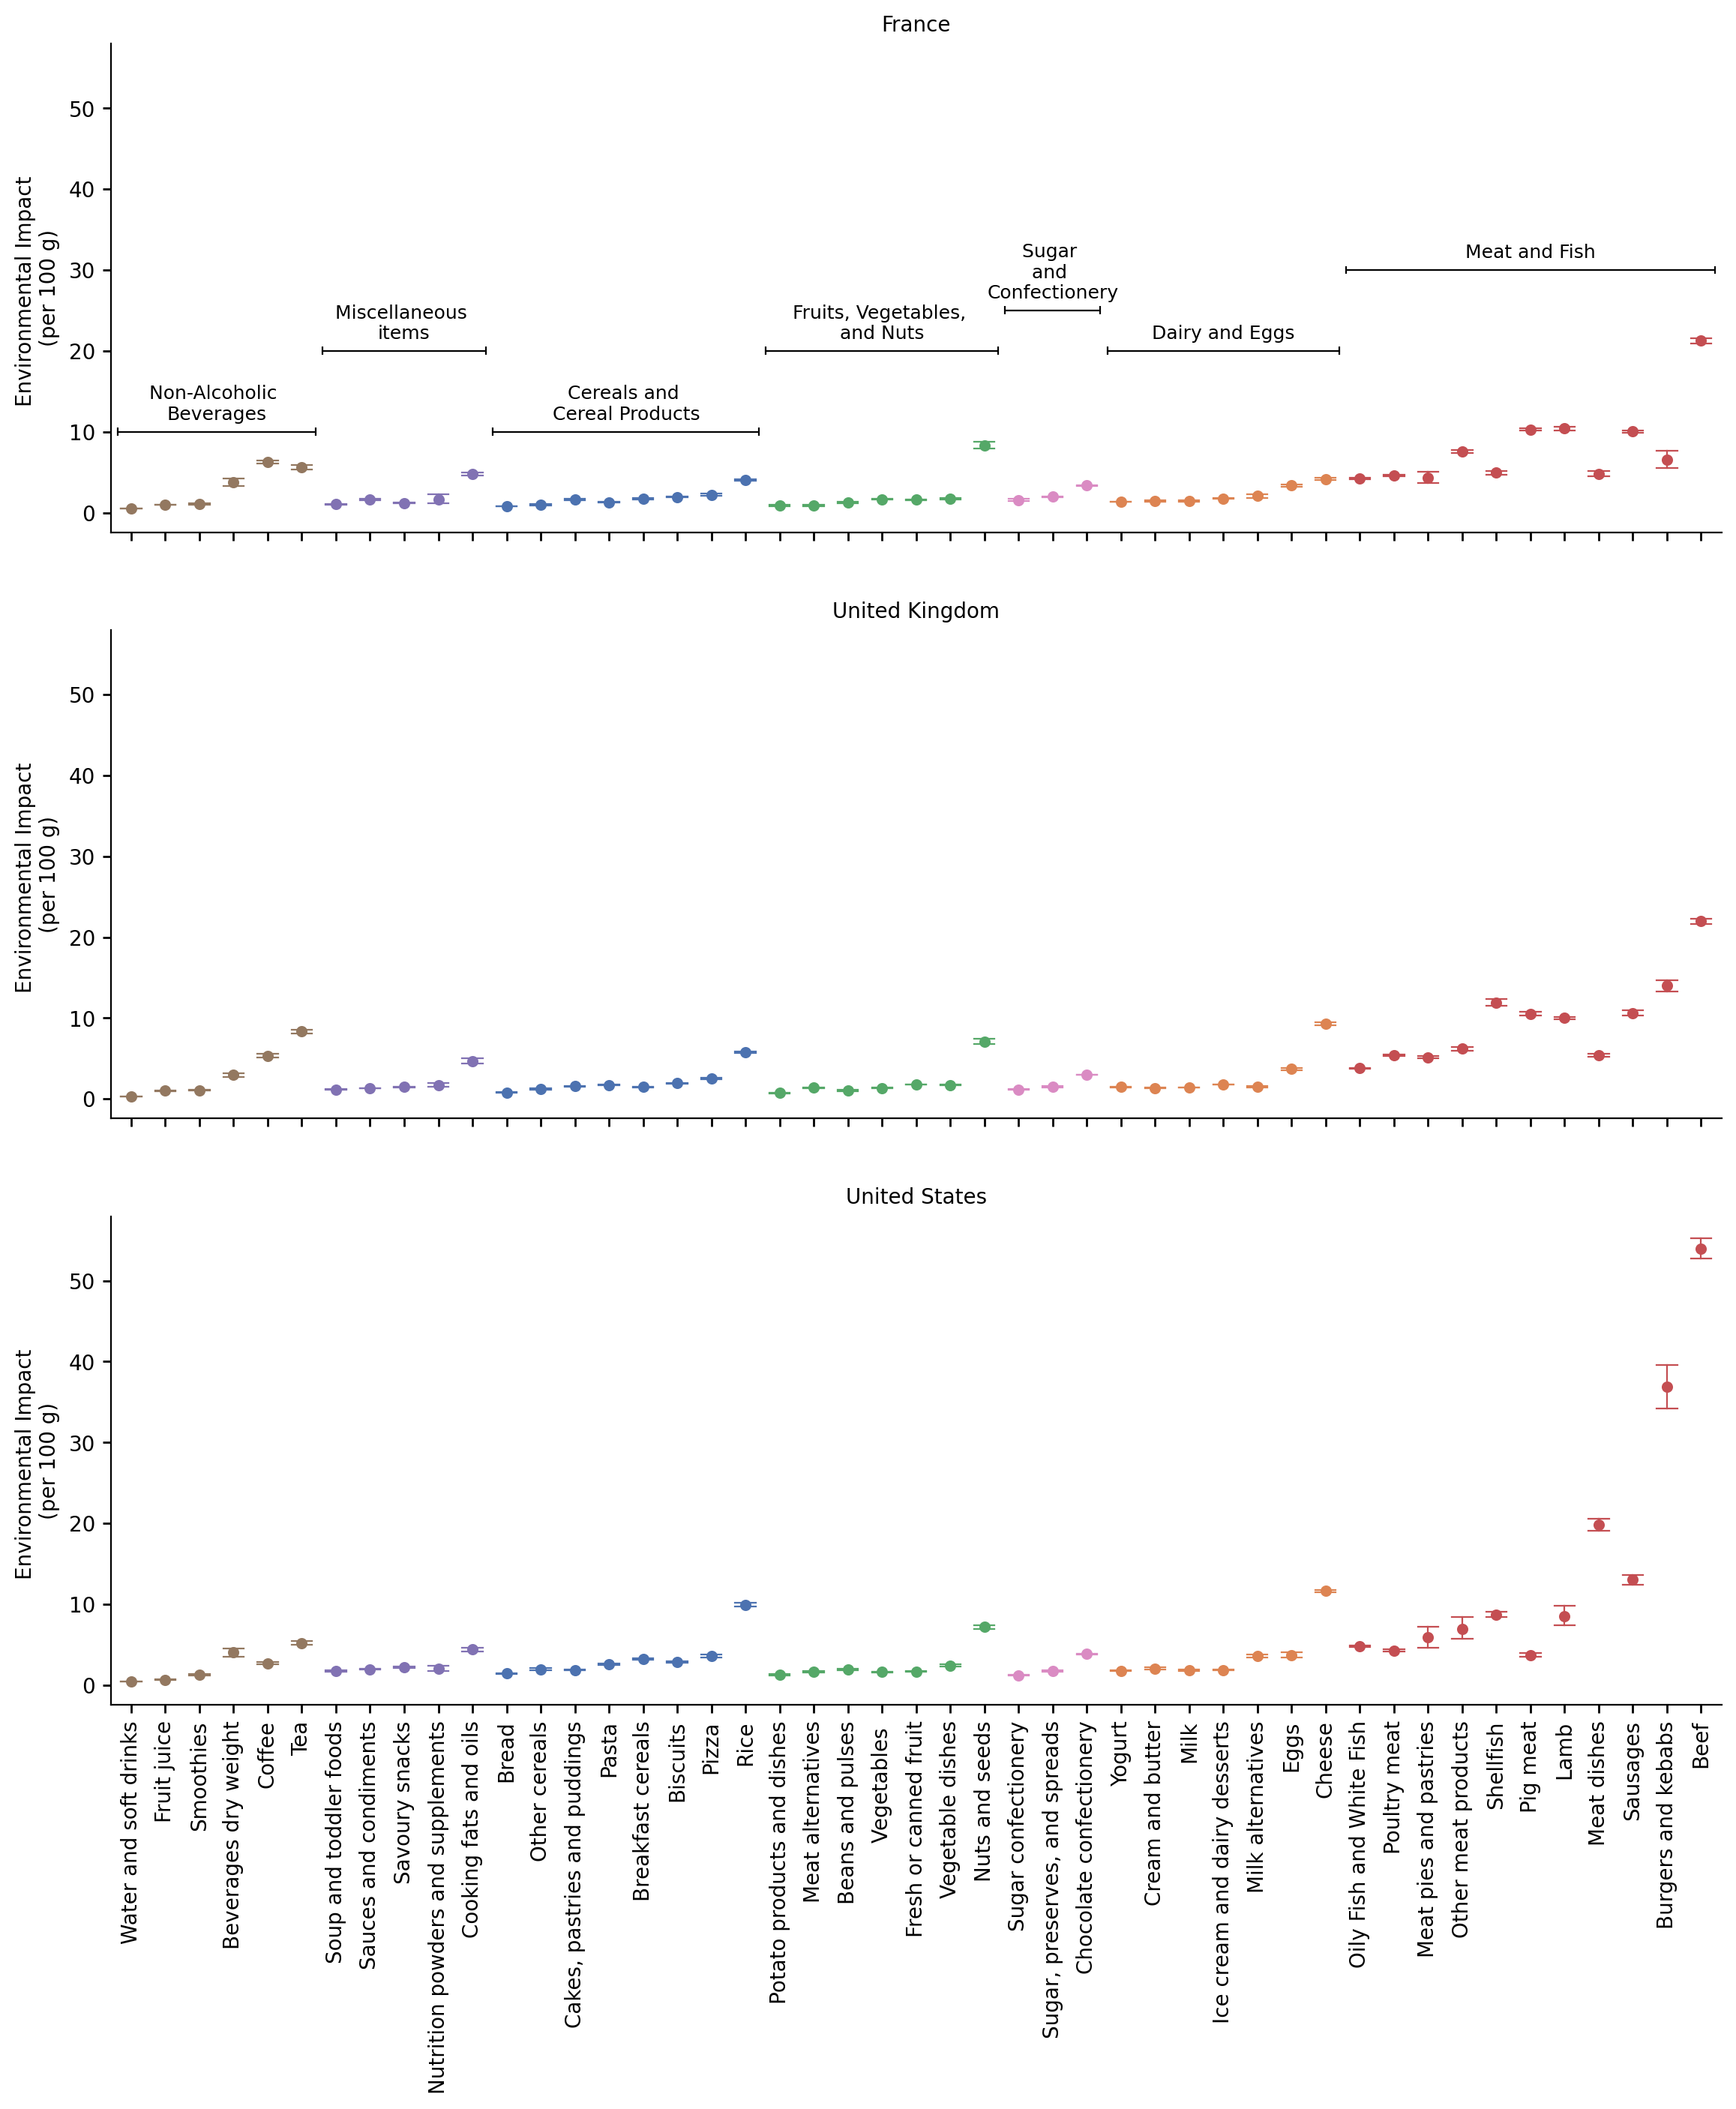

In [54]:
# Initialize the FacetGrid
g = sns.FacetGrid(df_plot, 
                  row='country', 
                  sharey=True,
                  height=4, aspect=3)

# Define the plotting function
def plot_errorbar(data, color, **kwargs):
    sns.pointplot(
        x='labels', 
        y='mean_norm', 
        hue='groups',
        data=data,
        order=order_df['labels'].values,
        join=False, 
        capsize=0.6,
        errorbar='se',
        errwidth=0.8,  
        markers='.',
        markersize=0.5,
        palette='deep'
    )

# Map the plotting function to each facet
g.map_dataframe(plot_errorbar)

# Rotate x-axis labels vertically
for ax in g.axes.flatten():
    ax.tick_params(axis='x', which='major', bottom=True, top=False, length=4, width=1)
    ax.tick_params(axis='y', which='major', left=True, right=False, length=4, width=1)
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Add axis labels
g.set_axis_labels("", "Environmental Impact \n(per 100 g)")
g.set_titles("{row_name}", size=10)
g.figure.subplots_adjust(hspace=0.2)

# Add group labels and lines with endpoint markers ONLY to the top plot (France)
top_ax = g.axes.flatten()[0]  

# Get x-tick positions and labels
xticks = g.axes.flatten()[2].get_xticks()
xticklabels = [label.get_text() for label in g.axes.flatten()[2].get_xticklabels()]

groups = [
    {"label": "Cereals and \nCereal Products", 
     "start": order_df[order_df['groups']=="Cereals and Cereal Products"]['labels'].values[0], 
     "end": order_df[order_df['groups']=="Cereals and Cereal Products"]['labels'].values[-1], 
     "y": 10},
    {"label": "Dairy and Eggs", 
     "start": order_df[order_df['groups']=="Dairy and Eggs"]['labels'].values[0], 
     "end": order_df[order_df['groups']=="Dairy and Eggs"]['labels'].values[-1], 
     "y": 20},
    {"label": "Meat and Fish", 
     "start": order_df[order_df['groups']=="Meat and Fish"]['labels'].values[0], 
     "end": order_df[order_df['groups']=="Meat and Fish"]['labels'].values[-1], 
     "y": 30},
    {"label": "Fruits, Vegetables, \nand Nuts", 
     "start": order_df[order_df['groups']=="Fruits, Vegetables, and Nuts"]['labels'].values[0], 
     "end": order_df[order_df['groups']=="Fruits, Vegetables, and Nuts"]['labels'].values[-1], 
     "y": 20},
    {"label": "Non-Alcoholic \nBeverages", 
     "start": order_df[order_df['groups']=="Non-Alcoholic Beverages"]['labels'].values[0], 
     "end": order_df[order_df['groups']=="Non-Alcoholic Beverages"]['labels'].values[-1], 
     "y": 10},
    {"label": "Sugar \nand \nConfectionery", 
     "start": order_df[order_df['groups']=="Sugar and Confectionery"]['labels'].values[0], 
     "end": order_df[order_df['groups']=="Sugar and Confectionery"]['labels'].values[-1], 
     "y": 25},
    {"label": "Miscellaneous \nitems", 
     "start": order_df[order_df['groups']=="Miscellaneous items"]['labels'].values[0], 
     "end": order_df[order_df['groups']=="Miscellaneous items"]['labels'].values[-1], 
     "y": 20}
]

# Add group annotations
for group in groups:
    try:
        xmin = xticks[xticklabels.index(group['start'])] - 0.4
        xmax = xticks[xticklabels.index(group['end'])] + 0.4

        # Add group label 
        top_ax.text((xmin + xmax) / 2, group['y'] + 1,
                    group['label'], ha='center', va='bottom',
                    fontsize=9)  

        # Add narrower horizontal line
        line_width = 0.8  # Narrower line width
        top_ax.hlines(y=group['y'], xmin=xmin, xmax=xmax, color='black', linewidth=line_width)

        # Add vertical bars at endpoints
        bar_height = 1  # Adjust height for subtle look
        top_ax.vlines(x=xmin, ymin=group['y'] - bar_height / 2, ymax=group['y'] + bar_height / 2, 
                      color='black', linewidth=line_width)
        top_ax.vlines(x=xmax, ymin=group['y'] - bar_height / 2, ymax=group['y'] + bar_height / 2, 
                      color='black', linewidth=line_width)
    except ValueError:
        # Skip if the label isn't found
        continue

# Remove extra space at the beginning of the x-axis
# Adjusting based on the actual tick positions
min_tick = min(xticks)
max_tick = max(xticks)
top_ax.set_xlim(min_tick - 0.6, max_tick + 0.6)  # Adding slight padding after trimming

# Adjust layout and display the plot
# plt.tight_layout()
plt.show()

#### diet differences

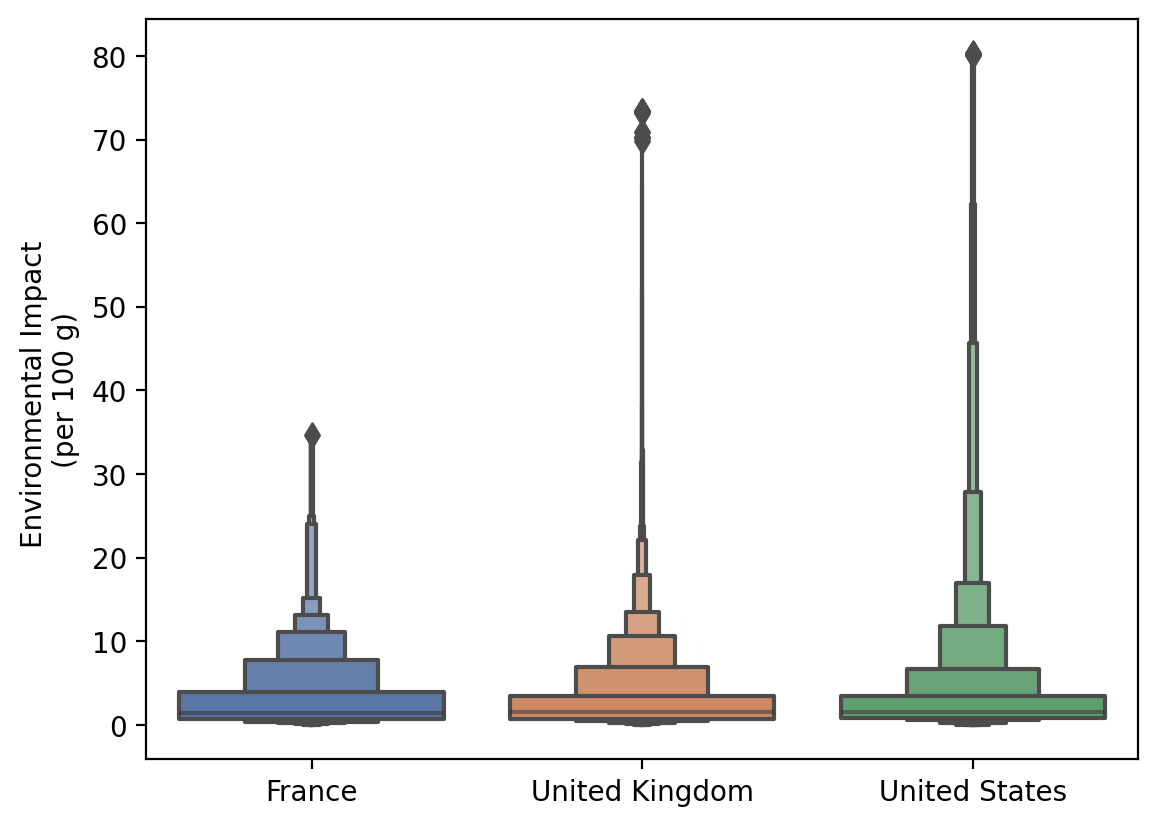

In [55]:
ax = sns.boxenplot(data=df_plot, y="mean_norm", x="country", palette='deep')
ax.set(ylabel='Environmental Impact \n(per 100 g)')
ax.set(xlabel='')
plt.show()

In [56]:
df_plot.groupby(['country'])[['mean_norm']].mean()

mean_norm
country                  
France           3.145836
United Kingdom   3.036522
United States    3.669918

In [57]:
df_plot.groupby(['country'])[['mean_norm']].median()

mean_norm
country                  
France           1.394553
United Kingdom   1.544078
United States    1.598740

In [58]:
df_plot.groupby(['country', 'labels'])[['mean_norm']].mean().reset_index().sort_values(by='mean_norm')

country                             labels  mean_norm
92   United Kingdom              Water and soft drinks   0.324795
139   United States              Water and soft drinks   0.437712
45           France              Water and soft drinks   0.518680
109   United States                        Fruit juice   0.675271
78   United Kingdom         Potato products and dishes   0.719253
4            France                              Bread   0.790107
51   United Kingdom                              Bread   0.805319
31           France         Potato products and dishes   0.891023
18           France                  Meat alternatives   0.892892
26           France                      Other cereals   0.961002
15           France                        Fruit juice   0.971542
47   United Kingdom                   Beans and pulses   1.004421
39           France             Soup and toddler foods   1.022819
62   United Kingdom                        Fruit juice   1.023566
85   United Kingdom                          Smoothies   1.045244
38           France                          Smoothies   1.049938
87   United Kingdom                Sugar confectionery   1.153035
86   United Kingdom             Soup and toddler foods   1.166330
36           France                     Savoury snacks   1.190258
73   United Kingdom                      Other cereals   1.217877
134   United States                Sugar confectionery   1.232538
0            France                   Beans and pulses   1.271891
132   United States                          Smoothies   1.289804
28           France                              Pasta   1.297876
125   United States         Potato products and dishes   1.298211
81   United Kingdom              Sauces and condiments   1.319292
59   United Kingdom                   Cream and butter   1.322237
91   United Kingdom                        Vegetables    1.343636
46           France                             Yogurt   1.354265
65   United Kingdom                  Meat alternatives   1.384751
68   United Kingdom                               Milk   1.418736
98    United States                              Bread   1.434064
21           France                               Milk   1.444549
83   United Kingdom                     Savoury snacks   1.459083
93   United Kingdom                             Yogurt   1.464492
12           France                   Cream and butter   1.472000
52   United Kingdom                  Breakfast cereals   1.482074
88   United Kingdom      Sugar, preserves, and spreads   1.509627
69   United Kingdom                  Milk alternatives   1.529546
54   United Kingdom       Cakes, pastries and puddings   1.559016
40           France                Sugar confectionery   1.571361
7            France       Cakes, pastries and puddings   1.600053
14           France              Fresh or canned fruit   1.612399
34           France              Sauces and condiments   1.631850
138   United States                        Vegetables    1.639650
23           France  Nutrition powders and supplements   1.641193
112   United States                  Meat alternatives   1.653967
44           France                        Vegetables    1.665681
108   United States              Fresh or canned fruit   1.692189
75   United Kingdom                              Pasta   1.709662
5            France                  Breakfast cereals   1.710331
70   United Kingdom  Nutrition powders and supplements   1.721194
43           France                   Vegetable dishes   1.724025
135   United States      Sugar, preserves, and spreads   1.725079
90   United Kingdom                   Vegetable dishes   1.734081
133   United States             Soup and toddler foods   1.753492
16           France       Ice cream and dairy desserts   1.757483
140   United States                             Yogurt   1.765702
63   United Kingdom       Ice cream and dairy desserts   1.774641
61   United Kingdom              Fresh or canned fru

In [47]:
df_mapping = df_plot[['groups', 'labels', 'ID']].drop_duplicates()
df_mapping['group_ID'] = df_mapping.apply(lambda row: row['ID'][:-1], axis=1)

parent_to_sub = {}
for parent in df_mapping['group_ID'].unique():
    subs = df_mapping[df_mapping['group_ID'] == parent]['ID'].tolist()
    subs_sorted = sorted(subs)
    parent_to_sub[parent] = subs_sorted
    
ordered_parents = sorted(parent_to_sub.keys())

# Create an overall ordered list of sub-categories, grouping by parent.
ordered_subs = []
for parent in ordered_parents:
    ordered_subs.extend(parent_to_sub[parent])

In [48]:
# Assign a base color to each parent (using a Seaborn palette)
base_colors = sns.color_palette("deep", len(ordered_parents))
parent_color_dict = {parent: base_colors[i] for i, parent in enumerate(ordered_parents)}

# For each parent, generate a palette for its sub-categories (variations on the parent's color)
sub_color_dict = {}
for parent in ordered_parents:
    n_sub = len(parent_to_sub[parent])
    # Get the parent's base color in hex format
    base_hex = matplotlib.colors.to_hex(parent_color_dict[parent])
    # Generate a light palette variant. reverse=True so the first sub-category gets the darkest shade.
    sub_palette = sns.light_palette(base_hex, n_colors=n_sub, reverse=True)
    for sub, color in zip(parent_to_sub[parent], sub_palette):
        sub_color_dict[sub] = color

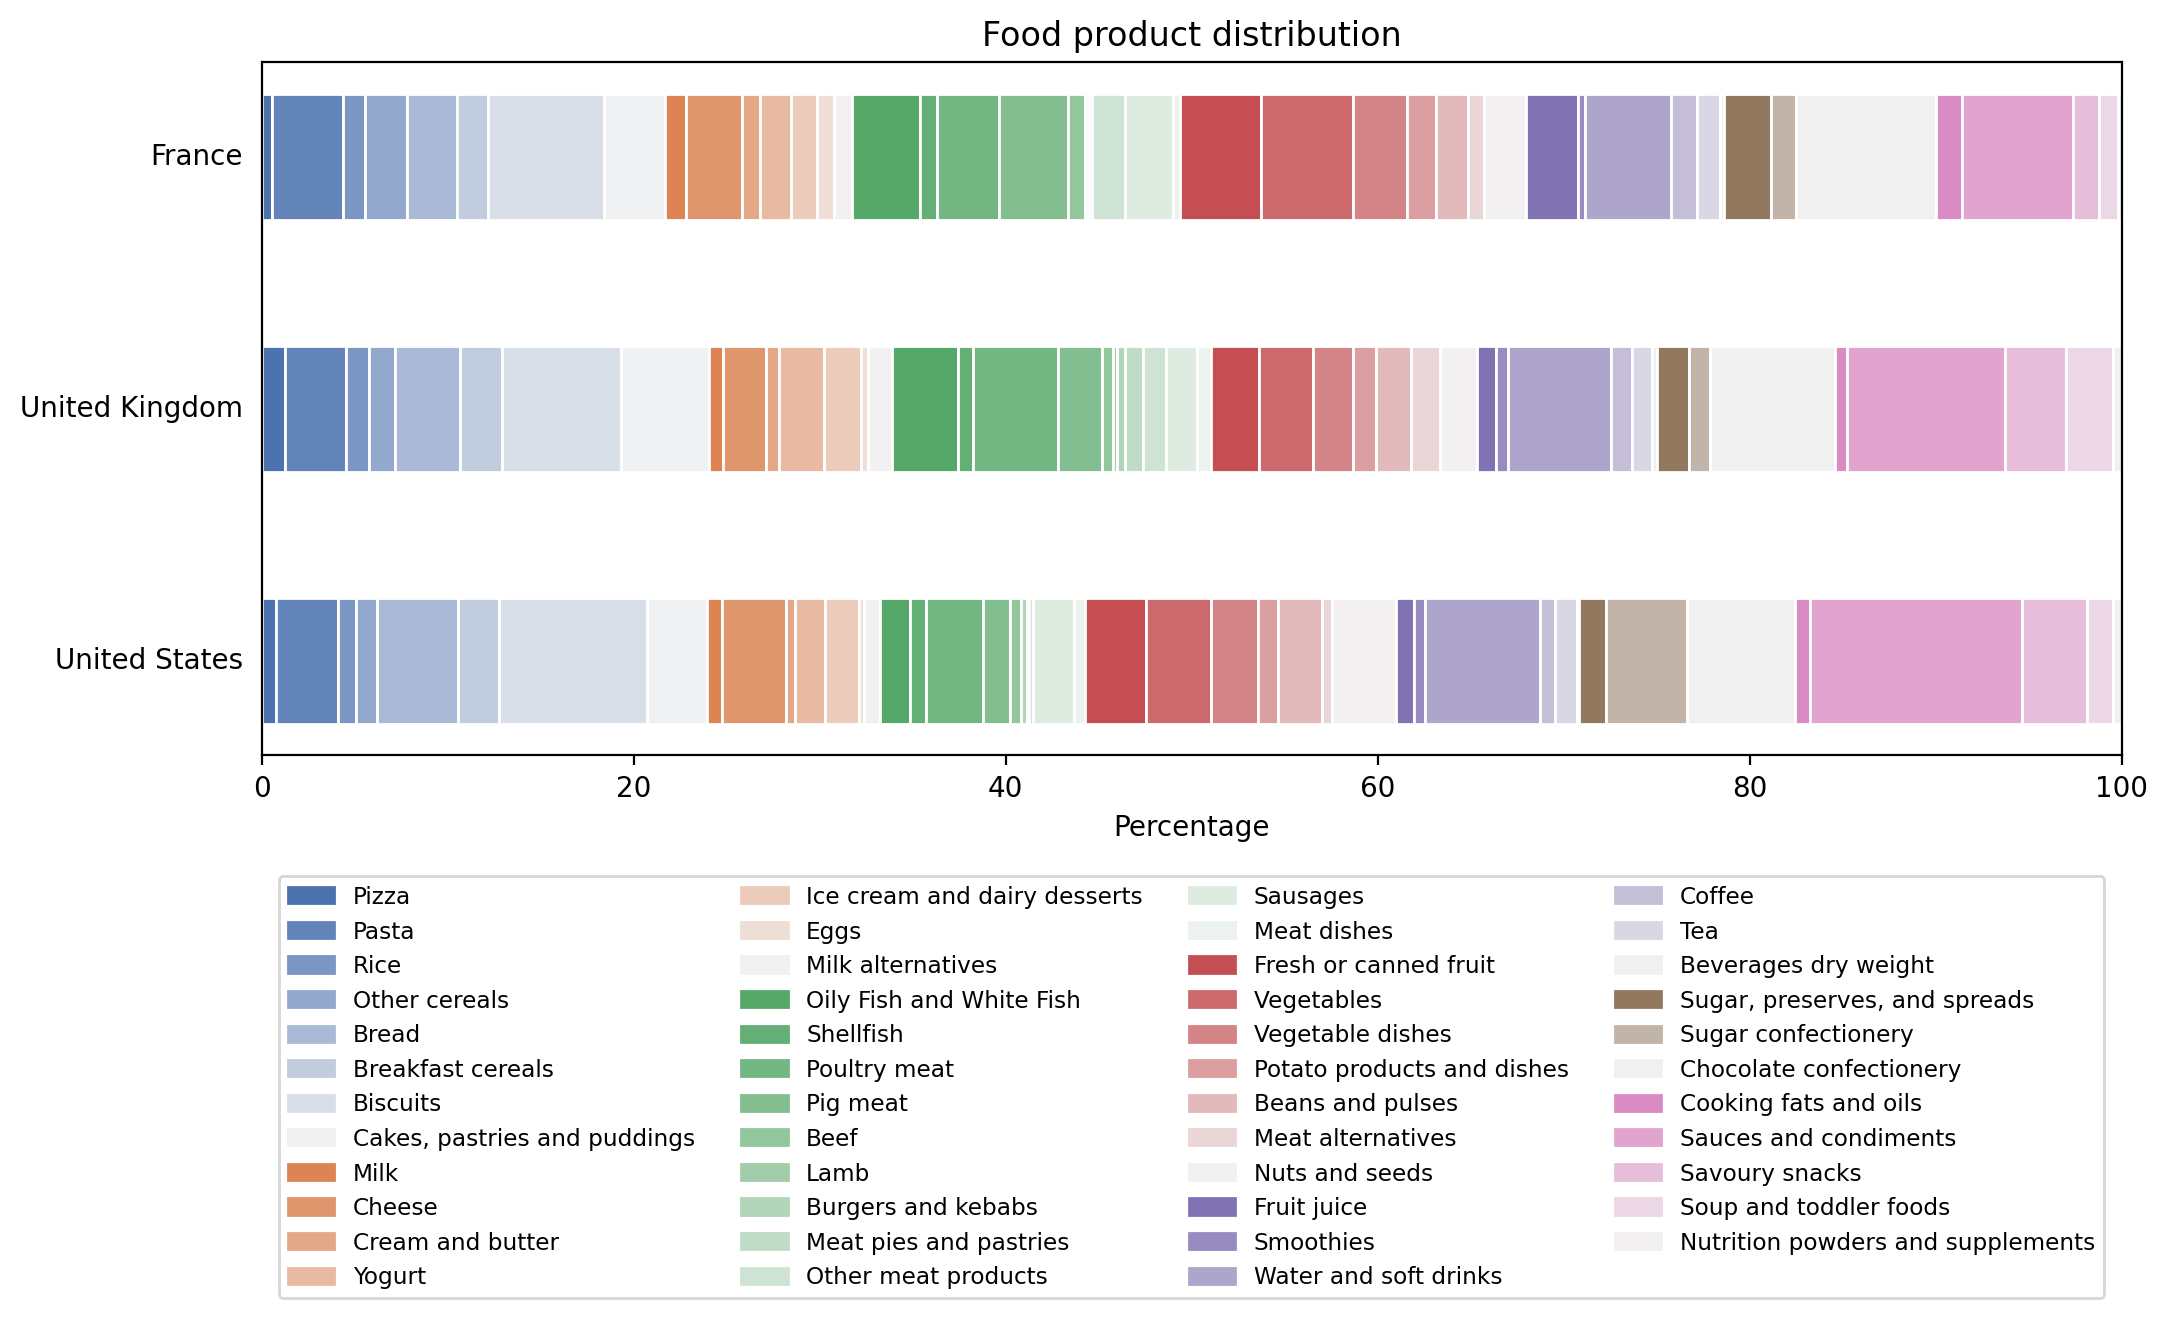

In [61]:
fig, ax = plt.subplots(figsize=(12, 4.5))

# Loop over countries. For each, compute percentages by sub_category and plot the stacked bar.
for i, country in enumerate(df_plot['country'].unique()[::-1]):
    df_country = df_plot[df_plot['country'] == country]
    counts = df_country['ID'].value_counts()
    total = counts.sum()
    left = 0  # starting position for stacking segments
    for sub in ordered_subs:
        count = counts.get(sub, 0)
        pct = (count / total * 100) if total > 0 else 0
        # Draw the horizontal bar segment for this sub_category.
        ax.barh(i, pct, left=left, color=sub_color_dict[sub], edgecolor='white', height=0.5)
        left += pct
    ax.text(-1, i, country, va='center', ha='right', fontsize=10)

ax.set_xlim(0, 100)
ax.set_yticks([])  # Hide default y-axis ticks since we annotated the country names.
ax.set_xlabel("Percentage")
ax.set_title("Food product distribution")

# Create legend for parent categories (using their base colors)
legend_handles = []
for sub, color in sub_color_dict.items():
    patch = mpatches.Patch(color=color, label=df_mapping[df_mapping['ID']==sub]['labels'].values[0])
    legend_handles.append(patch)

# ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.legend(
    handles=legend_handles,
    loc='lower center',                
    bbox_to_anchor=(0.5, -0.8), 
    ncol=4,
    fontsize='small',
    # frameon=False
)

# plt.tight_layout()
plt.show()


#### ingredient/composition differences

In [49]:
df_list = []
for fname in glob.glob(os.path.join('../../SFS/environmental_impacts/Managed_Data', "Impact_Proportions_By_Product_*.csv")):
    df = pd.read_csv(fname)
    df_list.append(df)

props = pd.concat(df_list, axis=0, ignore_index=True)

In [50]:
props[['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut', 
       #'tmp.impact_Acidification','tmp.impact_WaterUse',
      'tmp.impact_WatScar', 'tmp.impact_Biodiversity']] = props[[
    'tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut', 
    #'tmp.impact_Acidification', 'tmp.impact_WaterUse',
    'tmp.impact_WatScar', 'tmp.impact_Biodiversity']].fillna(0)

In [51]:
props = props.merge(impacts[['product_id', 'country', 'mean_Land', 'mean_GHG', 'mean_Eut',
                             'mean_WatScar', 'mean_Biodiversity',
                             'mean_Acidification', 'mean_WaterUse']], left_on='id', right_on='product_id')

In [52]:
props['tmp.impact_Land'] = (props['tmp.impact_Land']/props['amount']) * props['mean_Land']
props['tmp.impact_GHG'] = (props['tmp.impact_GHG']/props['amount']) * props['mean_GHG']
props['tmp.impact_Eut'] = (props['tmp.impact_Eut']/props['amount']) * props['mean_Eut']
props['tmp.impact_WatScar'] = (props['tmp.impact_WatScar']/props['amount']) * props['mean_WatScar'] 
props['tmp.impact_Biodiversity'] = (props['tmp.impact_Biodiversity']/props['amount']) * props['mean_Biodiversity'] 
# props['tmp.impact_Acidification'] = (props['tmp.impact_Acidification']/props['amount']) * props['mean_Acidification'] 
# props['tmp.impact_WaterUse'] = (props['tmp.impact_WaterUse']/props['amount']) * props['mean_WaterUse'] 

In [53]:
# d = props
# for col in ['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Biodiversity', 'tmp.impact_Eut', 'tmp.impact_WatScar']:
#     d[col] = 100 * (d[col] - d[col].min()) / (d[col].max() - d[col].min())
# d.groupby('Food_Category')[['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Biodiversity', 
#        'tmp.impact_Eut', 'tmp.impact_WatScar']].mean()

In [54]:
props[['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Biodiversity', 
       'tmp.impact_Eut', 'tmp.impact_WatScar']].corr()

tmp.impact_Land  tmp.impact_GHG  \
tmp.impact_Land                 1.000000        0.544991   
tmp.impact_GHG                  0.544991        1.000000   
tmp.impact_Biodiversity         0.739264        0.527831   
tmp.impact_Eut                  0.733558        0.455542   
tmp.impact_WatScar              0.163705        0.256359   

                         tmp.impact_Biodiversity  tmp.impact_Eut  \
tmp.impact_Land                         0.739264        0.733558   
tmp.impact_GHG                          0.527831        0.455542   
tmp.impact_Biodiversity                 1.000000        0.578633   
tmp.impact_Eut                          0.578633        1.000000   
tmp.impact_WatScar                      0.095731        0.159616   

                         tmp.impact_WatScar  
tmp.impact_Land                    0.163705  
tmp.impact_GHG                     0.256359  
tmp.impact_Biodiversity            0.095731  
tmp.impact_Eut                     0.159616  
tmp.impact_WatScar                 1.000000

In [55]:
# props.groupby('Food_Category')[['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Biodiversity', 
#        'tmp.impact_Eut', 'tmp.impact_WatScar']].corr()

In [56]:
impact_groups = props
for col in ['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut',
            #  'tmp.impact_Acidification', 'tmp.impact_WaterUse',
            'tmp.impact_WatScar', 'tmp.impact_Biodiversity']:
    impact_groups[col] = 100 * (impact_groups[col] - impact_groups[col].min()) / (impact_groups[col].max() - impact_groups[col].min())

impact_groups['impact'] = impact_groups[['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut',
                         #  'tmp.impact_Acidification', 'tmp.impact_WaterUse',
                         'tmp.impact_WatScar', 'tmp.impact_Biodiversity']].mean(axis=1) 
impact_groups['impact'] = 100 * (impact_groups['impact'] - impact_groups['impact'].min()) / (impact_groups['impact'].max() - impact_groups['impact'].min())
    
impact_groups = impact_groups.groupby('Food_Category')[[
    'tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut',
    #  'tmp.impact_Acidification', 'tmp.impact_WaterUse',
    'tmp.impact_WatScar', 'tmp.impact_Biodiversity', 'impact'
]].mean().reset_index()

In [78]:
impact_groups

Food_Category  tmp.impact_Land  tmp.impact_GHG  tmp.impact_Eut  \
0                Almond milk         0.040173        3.376499        0.046601   
1                Animal Fats         2.214102        7.694749        1.455011   
2                     Apples         0.065216        2.761772        0.018969   
3                    Bananas         0.642360        2.965669        0.177675   
4              Barley (Beer)         0.079037        3.046424        0.072721   
5                 Beet Sugar         0.177009        3.302806        0.111548   
6           Berries & Grapes         0.200250        5.478928        0.152265   
7    Bovine Meat (beef herd)        16.059709       24.982420        3.538320   
8   Bovine Meat (dairy herd)        13.776644       19.618963       23.300217   
9                  Brassicas         0.088386        2.901803        0.089361   
10      Butter, Cream & Ghee         0.275485        3.778216        0.255083   
11                Cane Sugar         0.249210        3.459014        0.316243   
12                   Cassava         0.107517        2.729024        0.017459   
13  Cereals & Oilcrops Misc.         0.323914        3.102318        0.122589   
14                    Cheese         2.503217       11.321749        2.185591   
15              Citrus Fruit         0.058432        2.796248        0.044917   
16                    Coffee         1.535197        9.082314        1.834117   
17               Crustaceans         0.294778       12.422679        3.805502   
18            Dark Chocolate         6.647729        4.503987        1.210711   
19                      Eggs         0.676134        4.318414        0.481691   
20                      Fish         0.907295        8.230728        2.181368   
21                Groundnuts         0.981268        3.955303        0.246512   
22             Lamb & Mutton         5.136217       15.389073        0.632644   
23              Maize (Meal)         0.204490        2.989718        0.100802   
24                      Milk         0.279477        3.775900        0.255903   
25            Milk Chocolate         8.912542        1.889126        0.081683   
26                      Nuts         1.410619        3.443743        0.687956   
27                  Oat milk         0.054649        2.856455        0.050435   
28                   Oatmeal         0.501309        3.280389        0.314672   
29                 Olive Oil         2.693831        4.700270        0.922137   
30                    Olives         0.530841        2.985204        0.130615   
31            Onions & Leeks         0.037713        2.773457        0.062758   
32               Other Fruit         0.113117        2.965504        0.335702   
33              Other Pulses         0.790195        3.099716        0.250591   
34          Other Vegetables         0.126807        3.006750        0.067089   
35            Other nut milk         0.067672        4.565972        0.058910   
36                  Palm Oil         0.261616        5.472601        0.333138   
37                      Peas         0.631714        3.041936        0.263684   
38                  Pig Meat         2.518492        7.670359        1.458551   
39                  Potatoes         0.072894        2.753152        0.050403   
40              Poultry Meat         1.350187        7.204847        1.072277   
41              Rapeseed Oil         1.039369        3.985401        0.449467   
42                      Rice         0.333486        4.194476        0.622565   
43                 Rice milk         0.045911        3.092015        0.106604   
44           Root Vegetables         0.208260        3.048919        0.188076   
45                      Salt         0.000000        2.601589        0.000000   
46               Soybean Oil         1.048865        5.106225        0.360396   
47                   Soymilk         0.078272        2.958816        0.049918   
48             Sunflower Oil         1.718286 

In [57]:
impact_groups['impact_groups'] = pd.qcut(impact_groups.impact, 5, labels=[1, 2, 3, 4, 5])

In [80]:
impact_groups.sort_values(by='impact')[['Food_Category', 'impact', 'impact_groups']]

Food_Category     impact impact_groups
53                     Water   0.000000             1
45                      Salt   0.000000             1
12                   Cassava   0.136628             1
31            Onions & Leeks   0.164348             1
27                  Oat milk   0.218095             1
47                   Soymilk   0.236809             1
2                     Apples   0.248375             1
39                  Potatoes   0.252236             1
4              Barley (Beer)   0.300459             1
44           Root Vegetables   0.384004             1
52                  Tomatoes   0.433145             1
23              Maize (Meal)   0.525548             1
54       Wheat & Rye (Bread)   0.554132             2
5                 Beet Sugar   0.554208             2
13  Cereals & Oilcrops Misc.   0.603514             2
43                 Rice milk   0.677691             2
9                  Brassicas   0.703146             2
33              Other Pulses   0.738257             2
15              Citrus Fruit   0.775073             2
51                      Tofu   0.788255             2
55                      Wine   0.815410             2
11                Cane Sugar   0.885183             2
37                      Peas   1.127841             2
3                    Bananas   1.180641             3
32               Other Fruit   1.230226             3
10      Butter, Cream & Ghee   1.262619             3
24                      Milk   1.269534             3
28                   Oatmeal   1.362963             3
41              Rapeseed Oil   1.482473             3
30                    Olives   1.523155             3
49           Sunflower seeds   1.590538             3
6           Berries & Grapes   1.714822             3
35            Other nut milk   1.857670             3
36                  Palm Oil   2.105328             3
46               Soybean Oil   2.186527             4
21                Groundnuts   2.220922             4
19                      Eggs   2.676267             4
48             Sunflower Oil   2.739149             4
34          Other Vegetables   2.840998             4
25            Milk Chocolate   4.649268             4
20                      Fish   4.776387             4
40              Poultry Meat   5.524056             4
0                Almond milk   5.583426             4
42                      Rice   5.672643             4
29                 Olive Oil   6.233507             4
18            Dark Chocolate   6.259630             5
16                    Coffee   6.576722             5
1                Animal Fats   7.762989             5
38                  Pig Meat   8.162196             5
22             Lamb & Mutton   9.003575             5
17               Crustaceans   9.527910             5
50                       Tea   9.678069             5
14                    Cheese  10.244047             5
26                      Nuts  12.026289             5
7    Bovine Meat (beef herd)  19.782660             5
8   Bovine Meat (dairy herd)  31.857621             5

In [58]:
composition_sub = composition.merge(df_plot[['product_id', 'groups', 'labels', 'ID', 'mean_norm']], 
                                    left_on='id', right_on='product_id')

# to account for almond, rice, oat, other nut milks
df_list = []
for food_cat in ['Almond milk','Oat milk', 'Other nut milk', 'Rice milk']:  
    alt_ids = props[props['Food_Category']==food_cat]['id'].unique()
    df = composition_sub[composition_sub['id'].isin(alt_ids)].groupby('id').first().reset_index()
    composition_sub = composition_sub[~composition_sub['id'].isin(alt_ids)]
    df['Food_Category'] = food_cat
    df['percent'] = 100
    df_list.append(df)
df_list.append(composition_sub)
composition_sub = pd.concat(df_list, axis=0, ignore_index=True)

composition_sub = composition_sub.groupby(['country', 'groups', 'labels', 
                                           'ID', 'Food_Category'])[['percent']].sum().reset_index()

def get_perc(g):
    g['percent'] = (g['percent'] / g['percent'].sum()) * 100
    return g

composition_sub = composition_sub.groupby(['country', 'ID']).apply(lambda g: get_perc(g)).reset_index(drop=True)

composition_sub.loc[composition_sub['Food_Category']=='Fish (farmed)', 'Food_Category'] = 'Fish'
composition_sub.loc[composition_sub['Food_Category']=='Crustaceans (farmed)', 'Food_Category'] = 'Crustaceans'
composition_sub = composition_sub.merge(impact_groups[['Food_Category', 'impact_groups']], how='left')
composition_sub.loc[composition_sub['impact_groups'].isna(), 'impact_groups'] = 1

composition_sub = composition_sub.groupby(['country', 'ID', 'impact_groups'])[['percent']].sum().reset_index()
composition_sub = composition_sub.merge(df_mapping)

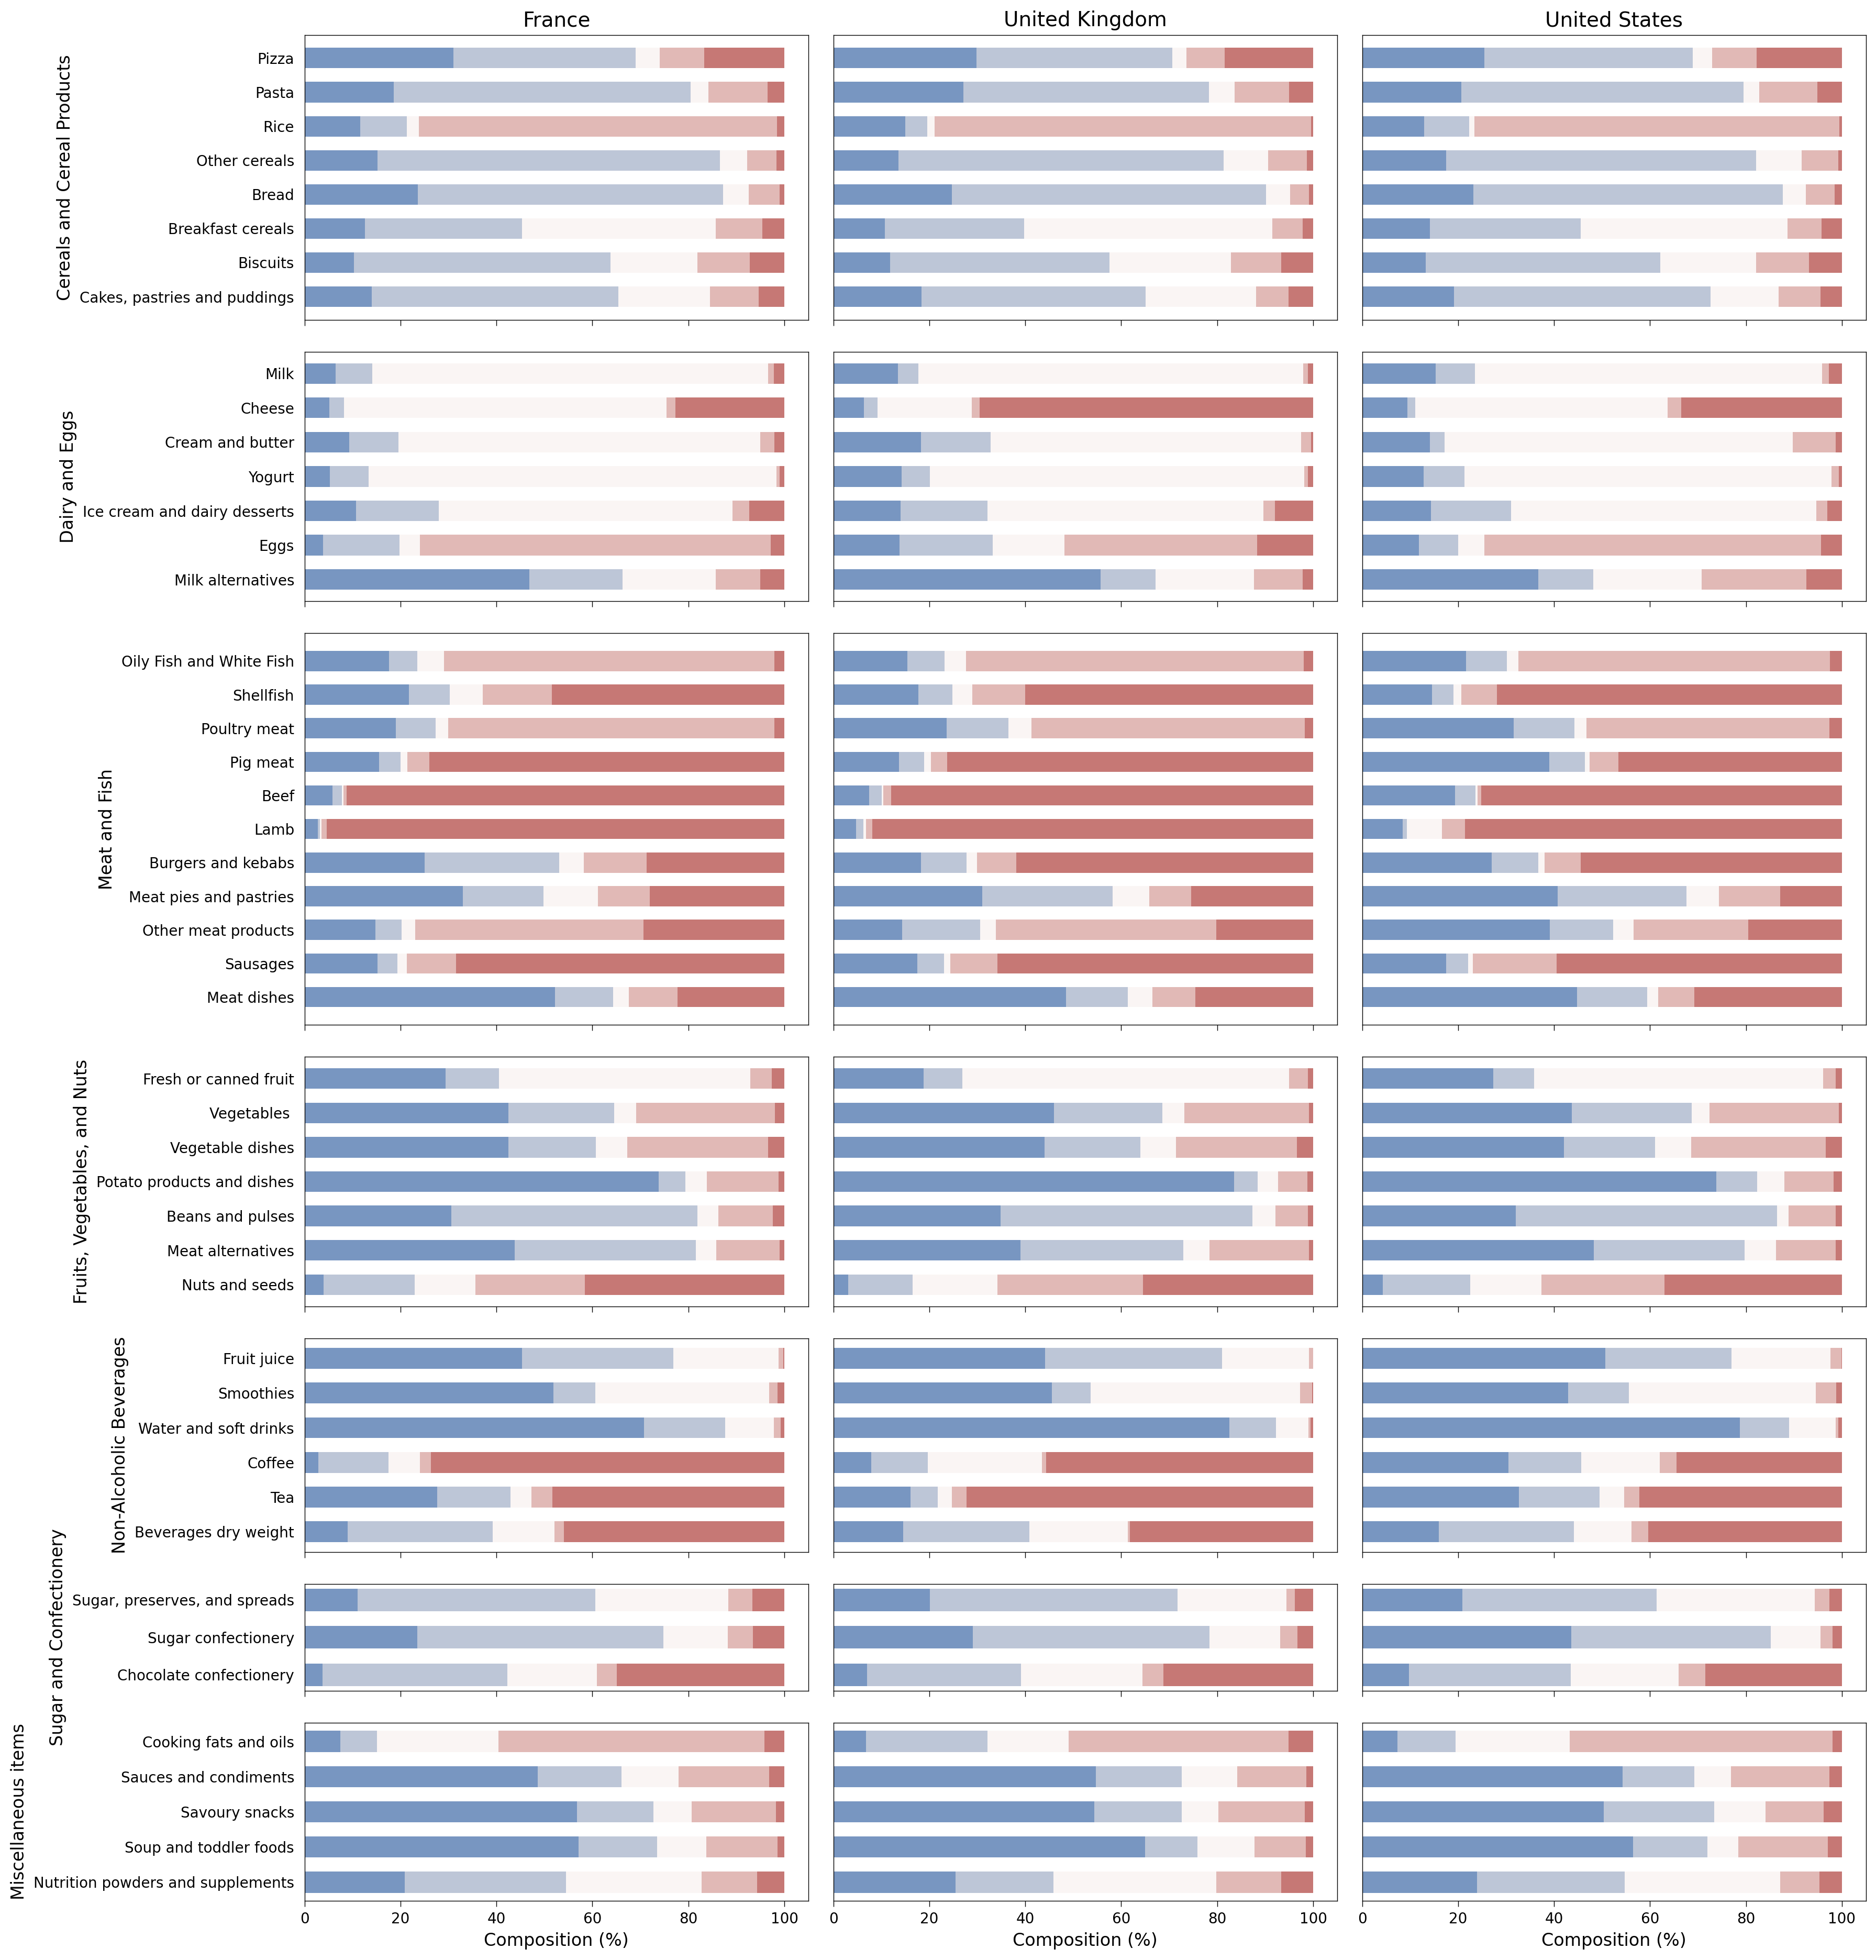

In [82]:
groups_list = ['Cereals and Cereal Products', 'Dairy and Eggs', 'Meat and Fish',
               'Fruits, Vegetables, and Nuts', 'Non-Alcoholic Beverages',
               'Sugar and Confectionery', 'Miscellaneous items']
countries_list = ['France', 'United Kingdom', 'United States']


facet_counts = {}
for group in groups_list:
    for country in countries_list:
        data_sub = composition_sub[(composition_sub['groups'] == group) & (composition_sub['country'] == country)]
        count = data_sub['labels'].nunique() if not data_sub.empty else 0
        facet_counts[(group, country)] = count
        
inch_per_label = 0.4  
row_heights = []
for group in groups_list:
    max_count = max(facet_counts[(group, country)] for country in countries_list)
    row_heights.append(max_count * inch_per_label)

fig_width = len(countries_list) * 6  
fig_height = sum(row_heights)

fig = plt.figure(figsize=(fig_width, fig_height))
gs = gridspec.GridSpec(nrows=len(groups_list), ncols=len(countries_list),
                       height_ratios=row_heights)

def plot_stacked_barh(ax, data):
    pivot = data.pivot(index=['ID', "labels"], columns="impact_groups", values="percent").reset_index()
    pivot = pivot.fillna(0)
    pivot = pivot.sort_values('ID', ascending=False)

    labels = pivot['labels'].tolist()
    n = len(labels)
    positions = np.arange(n)

    bar_height = 0.6
    pivot = pivot.drop('ID', axis=1).set_index('labels')
    impact_groups = sorted(pivot.columns)

    # Define a color palette (consistent across facets)
    palette = sns.color_palette("vlag", n_colors=len(impact_groups))
    color_map = dict(zip(impact_groups, palette))

    # Plot each segment of the stacked bar.
    left = np.zeros(n)  # starting offset for each bar
    for group in impact_groups:
        ax.barh(y=positions,
                width=pivot[group].values,
                left=left,
                height=bar_height,
                label=group,
                color=color_map[group])
        left += pivot[group].values  # update the offset

    # Set y-ticks and labels
    ax.set_yticks(positions)
    ax.set_yticklabels(labels)
    
    # Remove gridlines and spines for a cleaner look
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)
        
legend_handles = None

for i, group in enumerate(groups_list):
    for j, country in enumerate(countries_list):
        ax = fig.add_subplot(gs[i, j])
        
        # Filter data for this facet.
        data_sub = composition_sub[(composition_sub['groups'] == group) & (composition_sub['country'] == country)]
        if not data_sub.empty:
            plot_stacked_barh(ax, data_sub)
        else:
            ax.set_visible(False)
        
        ax.tick_params(axis='x', which='major', bottom=True, top=False, length=4, width=0.5)
        ax.tick_params(axis='y', which='major', left=False, right=False)
        if i == 0:
            ax.set_title(country, fontsize=14)
        if i!=len(groups_list)-1:
            ax.set_xticklabels("") 
        if i==len(groups_list)-1:
            ax.set_xlabel("Composition (%)", fontsize=12)
        if j == 0:
            ax.set_ylabel(group, fontsize=12)
        else:
            ax.set_ylabel("")
            ax.set_yticklabels("")
            
        if legend_handles is None and not data_sub.empty:
            handles, labels = ax.get_legend_handles_labels()
            legend_handles = (handles, labels)

# if legend_handles is not None:
#     handles, leg_labels = legend_handles
#     # Place the legend below all subplots.
#     fig.legend(handles, leg_labels, title="Impact Groups", loc="lower center",
#                ncol=len(handles), bbox_to_anchor=(0.5, 0.01))

# Adjust layout
plt.tight_layout(h_pad=1.8, w_pad=1.4, 
                 # rect=[0, 0.05, 1, 1]
                )
plt.show()

In [59]:
composition_sub = composition.merge(df_plot[['product_id', 'groups', 'labels', 'ID', 'mean_norm']], 
                                    left_on='id', right_on='product_id')

# to account for almond, rice, oat, other nut milks
df_list = []
for food_cat in ['Almond milk','Oat milk', 'Other nut milk', 'Rice milk']:  
    alt_ids = props[props['Food_Category']==food_cat]['id'].unique()
    df = composition_sub[composition_sub['id'].isin(alt_ids)].groupby('id').first().reset_index()
    composition_sub = composition_sub[~composition_sub['id'].isin(alt_ids)]
    df['Food_Category'] = food_cat
    df['percent'] = 100
    df_list.append(df)
df_list.append(composition_sub)
composition_sub = pd.concat(df_list, axis=0, ignore_index=True)

composition_sub = composition_sub.groupby(['country', 'Food_Category'])[['percent']].sum().reset_index()

def get_perc(g):
    g['percent'] = (g['percent'] / g['percent'].sum()) * 100
    return g

composition_sub = composition_sub.groupby(['country']).apply(lambda g: get_perc(g)).reset_index(drop=True)

composition_sub.loc[composition_sub['Food_Category']=='Fish (farmed)', 'Food_Category'] = 'Fish'
composition_sub.loc[composition_sub['Food_Category']=='Crustaceans (farmed)', 'Food_Category'] = 'Crustaceans'
composition_sub = composition_sub.merge(impact_groups[['Food_Category', 'impact_groups']], how='left')
composition_sub.loc[composition_sub['impact_groups'].isna(), 'impact_groups'] = 1

composition_sub = composition_sub.groupby(['country', 'impact_groups'])[['percent']].sum().reset_index()

In [84]:
composition_sub

country impact_groups    percent
0           France             1  24.536379
1           France             2  25.963532
2           France             3  17.862884
3           France             4  16.710710
4           France             5  14.926495
5   United Kingdom             1  29.538258
6   United Kingdom             2  24.336078
7   United Kingdom             3  17.712558
8   United Kingdom             4  14.909119
9   United Kingdom             5  13.503987
10   United States             1  31.768574
11   United States             2  26.320189
12   United States             3  17.223801
13   United States             4  13.906893
14   United States             5  10.780543

#### importance of sourcing - also what does impacts figure look like without incorporating sourcing?

In [60]:
sourcing_diff = props

In [61]:
for col in ['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut',
            #  'tmp.impact_Acidification', 'tmp.impact_WaterUse',
            'tmp.impact_WatScar', 'tmp.impact_Biodiversity']:
    sourcing_diff[col] = 100 * (sourcing_diff[col] - sourcing_diff[col].min()) / (sourcing_diff[col].max() - sourcing_diff[col].min())
    
sourcing_diff['impact'] = sourcing_diff[['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut',
                                         #  'tmp.impact_Acidification', 'tmp.impact_WaterUse',
                                         'tmp.impact_WatScar', 'tmp.impact_Biodiversity' 
                                         ]].mean(axis=1) 

sourcing_diff['impact'] = 100 * (sourcing_diff['impact'] - sourcing_diff['impact'].min()) / (sourcing_diff['impact'].max() - sourcing_diff['impact'].min())

sourcing_diff_plot = sourcing_diff[sourcing_diff['country'].isin(['France', 'United Kingdom', 'United States'])]

sourcing_diff_plot = sourcing_diff_plot.merge(impact_groups[['Food_Category', 'impact_groups']])

In [62]:
sourcing_diff_plot.groupby(['country', 'Food_Category'])[['impact']].mean().reset_index().sort_values(by='impact')

country             Food_Category     impact
101  United Kingdom                      Salt   0.000000
165   United States                     Water   0.000000
45           France                      Salt   0.000000
157   United States                      Salt   0.000000
53           France                     Water   0.000000
109  United Kingdom                     Water   0.000000
39           France                  Potatoes   0.126760
31           France            Onions & Leeks   0.130441
68   United Kingdom                   Cassava   0.135630
12           France                   Cassava   0.137106
124   United States                   Cassava   0.138089
2            France                    Apples   0.138527
87   United Kingdom            Onions & Leeks   0.144097
83   United Kingdom                  Oat milk   0.156459
58   United Kingdom                    Apples   0.163814
95   United Kingdom                  Potatoes   0.171020
27           France                  Oat milk   0.172649
143   United States            Onions & Leeks   0.190837
159   United States                   Soymilk   0.214966
60   United Kingdom             Barley (Beer)   0.231749
4            France             Barley (Beer)   0.233132
103  United Kingdom                   Soymilk   0.238334
47           France                   Soymilk   0.249471
44           France           Root Vegetables   0.327531
139   United States                  Oat milk   0.358558
52           France                  Tomatoes   0.365977
54           France       Wheat & Rye (Bread)   0.376455
9            France                 Brassicas   0.381989
69   United Kingdom  Cereals & Oilcrops Misc.   0.392306
37           France                      Peas   0.394485
156   United States           Root Vegetables   0.395318
23           France              Maize (Meal)   0.399081
100  United Kingdom           Root Vegetables   0.415504
116   United States             Barley (Beer)   0.423414
110  United Kingdom       Wheat & Rye (Bread)   0.427498
164   United States                  Tomatoes   0.433304
61   United Kingdom                Beet Sugar   0.439521
65   United Kingdom                 Brassicas   0.442371
114   United States                    Apples   0.448923
108  United Kingdom                  Tomatoes   0.454728
135   United States              Maize (Meal)   0.460164
5            France                Beet Sugar   0.475389
151   United States                  Potatoes   0.486030
33           France              Other Pulses   0.531037
89   United Kingdom              Other Pulses   0.575052
79   United Kingdom              Maize (Meal)   0.577043
43           France                 Rice milk   0.601351
13           France  Cereals & Oilcrops Misc.   0.603463
84   United Kingdom                   Oatmeal   0.633576
93   United Kingdom                      Peas   0.644238
127   United States              Citrus Fruit   0.714995
167   United States                      Wine   0.716573
55           France                      Wine   0.717638
166   United States       Wheat & Rye (Bread)   0.729120
163   United States                      Tofu   0.740525
28           France                   Oatmeal   0.761177
99   United Kingdom                 Rice milk   0.764912
15           France              Citrus Fruit   0.781254
11           France                Cane Sugar   0.785625
107  United Kingdom                      Tofu   0.807772
71   United Kingdom              Citrus Fruit   0.819838
51           France                      Tofu   0.837287
125   United States  Cereals & Oilcrops Misc.   0.840442
67   United Kingdom                Cane Sugar   0.885061
115   United States                   Bananas   0.905784
123   United States                Cane Sugar   0.933131
145   United States              Other Pulses   0.936979
111  United Kingdom                      Wine   0.965541
133   United States                Groundnuts   0.992678
24           France   

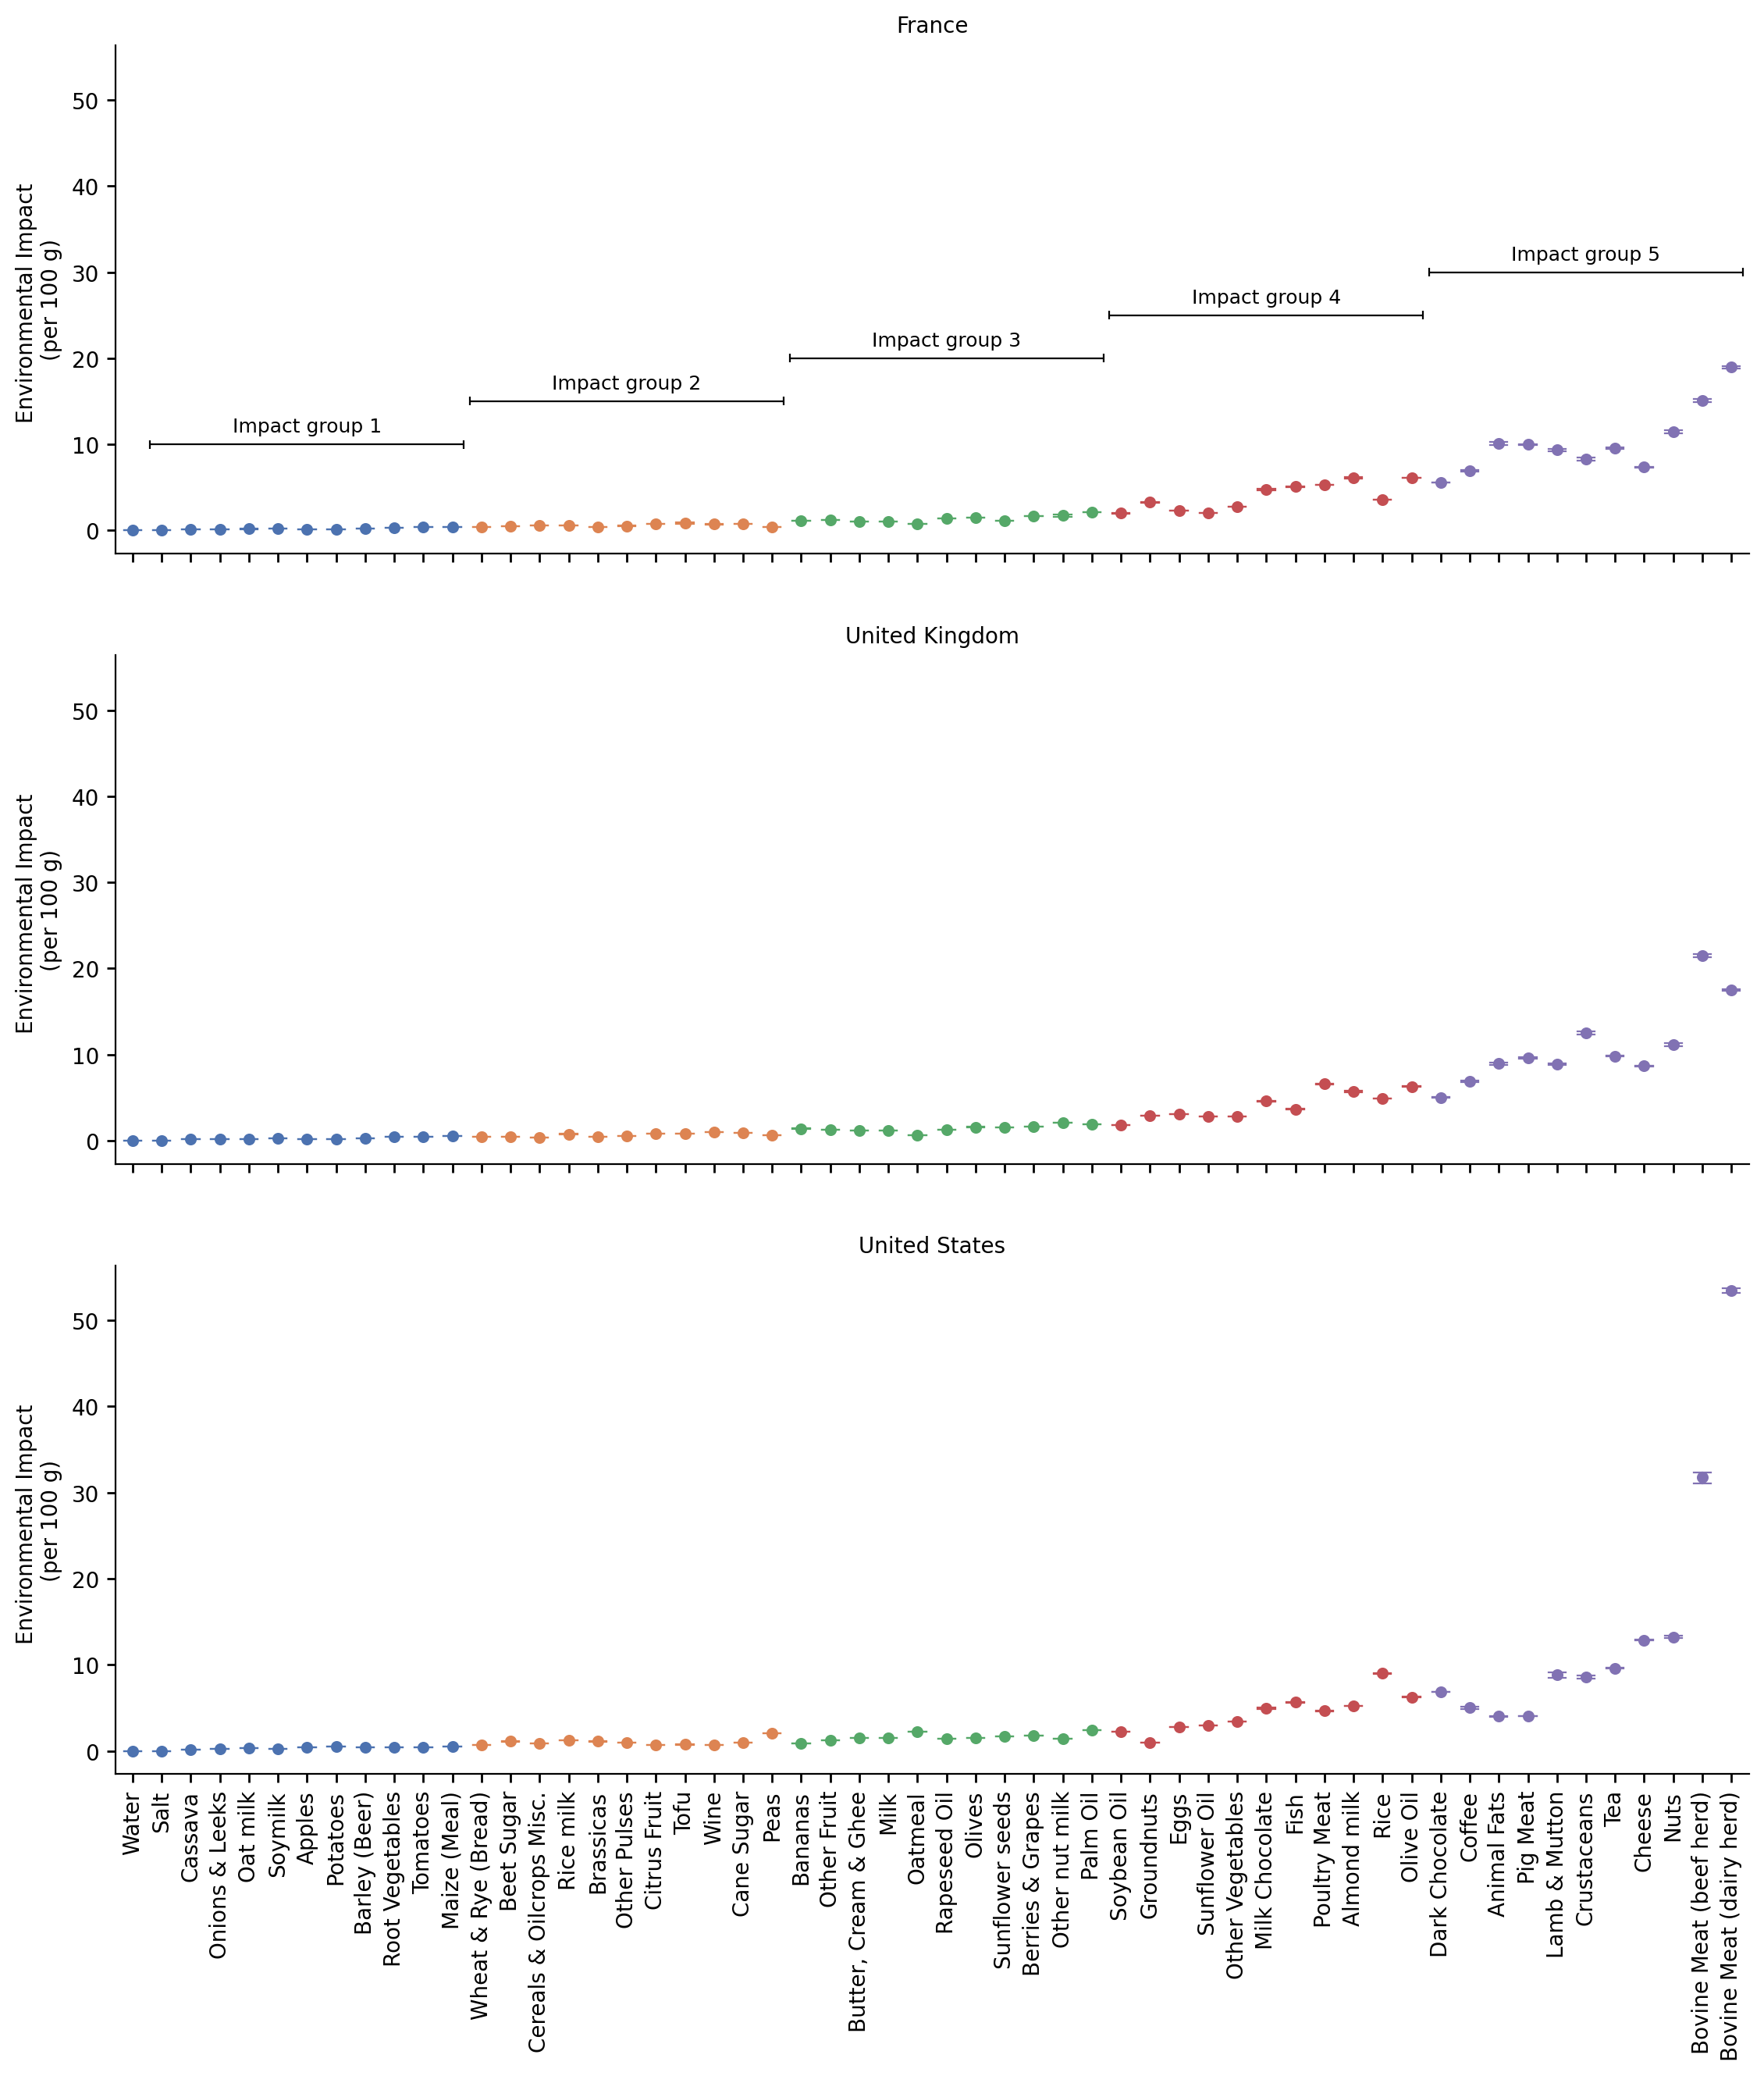

In [88]:
# Initialize the FacetGrid
g = sns.FacetGrid(sourcing_diff_plot, 
                  row='country', 
                  row_order=['France', 'United Kingdom', 'United States'],
                  sharey=True,
                  height=4, aspect=3)

# Define the plotting function
def plot_errorbar(data, color, **kwargs):
    sns.pointplot(
        x='Food_Category', 
        y='impact', 
        hue='impact_groups',
        order=impact_groups.sort_values(by='impact').reset_index(drop=True)['Food_Category'].values.tolist(),
        data=data, 
        join=False, 
        capsize=0.6,
        errorbar='se',
        errwidth=0.8,  
        markers='.',
        markersize=0.5,
        palette='deep'
    )

# Map the plotting function to each facet
g.map_dataframe(plot_errorbar)

# Rotate x-axis labels vertically
for ax in g.axes.flatten():
    ax.tick_params(axis='x', which='major', bottom=True, top=False, length=4, width=1)
    ax.tick_params(axis='y', which='major', left=True, right=False, length=4, width=1)
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Add axis labels
g.set_axis_labels("", "Environmental Impact \n(per 100 g)")
g.set_titles("{row_name}", size=10)
g.figure.subplots_adjust(hspace=0.2)

# Add group labels and lines with endpoint markers ONLY to the top plot 
top_ax = g.axes.flatten()[0]  

# Get x-tick positions and labels
xticks = g.axes.flatten()[2].get_xticks()
xticklabels = [label.get_text() for label in g.axes.flatten()[2].get_xticklabels()]



groups = [
    {"label": "Impact group 1",
     "start": impact_groups[impact_groups['impact_groups']==1].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[0], 
     "end": impact_groups[impact_groups['impact_groups']==1].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[-1], 
     "y": 10},
    {"label": "Impact group 2", 
     "start": impact_groups[impact_groups['impact_groups']==2].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[0], 
     "end": impact_groups[impact_groups['impact_groups']==2].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[-1], 
     "y": 15},
    {"label": "Impact group 3", 
     "start": impact_groups[impact_groups['impact_groups']==3].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[0], 
     "end": impact_groups[impact_groups['impact_groups']==3].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[-1], 
     "y": 20},
    {"label": "Impact group 4", 
     "start": impact_groups[impact_groups['impact_groups']==4].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[0], 
     "end": impact_groups[impact_groups['impact_groups']==4].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[-1], 
     "y": 25},
    {"label": "Impact group 5", 
     "start": impact_groups[impact_groups['impact_groups']==5].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[0], 
     "end": impact_groups[impact_groups['impact_groups']==5].sort_values(by='impact').reset_index(drop=True)['Food_Category'].values[-1], 
     "y": 30}
]

# Add group annotations
for group in groups:
    try:
        xmin = xticks[xticklabels.index(group['start'])] - 0.4
        xmax = xticks[xticklabels.index(group['end'])] + 0.4

        # Add group label
        top_ax.text((xmin + xmax) / 2, group['y'] + 1,
                    group['label'], ha='center', va='bottom',
                    fontsize=9)  # No bold, slightly smaller font size

        # Add narrower horizontal line
        line_width = 0.8  
        top_ax.hlines(y=group['y'], xmin=xmin, xmax=xmax, color='black', linewidth=line_width)

        # Add vertical bars at endpoints
        bar_height = 1  # Adjust height for subtle look
        top_ax.vlines(x=xmin, ymin=group['y'] - bar_height / 2, ymax=group['y'] + bar_height / 2, 
                      color='black', linewidth=line_width)
        top_ax.vlines(x=xmax, ymin=group['y'] - bar_height / 2, ymax=group['y'] + bar_height / 2, 
                      color='black', linewidth=line_width)
    except ValueError:
        # Skip if the label isn't found
        continue

# Remove extra space at the beginning of the x-axis
# Adjusting based on the actual tick positions
min_tick = min(xticks)
max_tick = max(xticks)
top_ax.set_xlim(min_tick - 0.6, max_tick + 0.6)  # Adding slight padding after trimming

# Adjust layout and display the plot
# plt.tight_layout()
plt.show()

In [63]:
df_list = []
for fname in glob.glob(os.path.join('../../SFS/environmental_impacts/Managed_Data', "Total_Impacts_By_Product_global*.csv")):
    df = pd.read_csv(fname)
    df_list.append(df)

impacts_global = pd.concat(df_list, axis=0, ignore_index=True)

impacts_global = products_cats.merge(impacts_global.drop('product_name', axis=1), left_on='product_id', 
                              right_on='id').drop('id', axis=1)

impacts_global = impacts_global.merge(impacts[['product_id', 'labels', 'groups', 'ID']])

In [64]:
score_columns = ['Land', 
                 'GHG', 
                 'Eut', 
                 'WatScar',
                 'Biodiversity', 
                 # 'Acidification', 
                 # 'WaterUse'
                ]

# Melt the aggregated dataframe to long format for seaborn
melted_df_global = impacts_global.melt(
    id_vars=['country', 'groups', 'labels', 'ID', 'product_id'],
    value_vars=[f"mean_{score}" for score in score_columns],
    var_name='score',
    value_name='mean'
)

# Extract the score name
melted_df_global['score'] = melted_df_global['score'].str.replace('_mean', '')
melted_df_global['score'] = melted_df_global['score'].str.replace('mean_', '')

melted_df_global = melted_df_global.groupby('score').apply(lambda g: get_norm(g)).reset_index(drop=True)

melted_df_global = melted_df_global.groupby(['country', 'groups', 'labels', 'ID', 'product_id'])[['mean_norm']].mean().reset_index()
melted_df_global['mean_norm'] = 100 * (melted_df_global['mean_norm'] - melted_df_global['mean_norm'].min()) / (melted_df_global['mean_norm'].max() - melted_df_global['mean_norm'].min())

df_plot_global = melted_df_global[melted_df_global['country'].isin(['United Kingdom', 'France', 'United States'])]
df_plot_global = df_plot_global[df_plot_global['labels']!='mis']

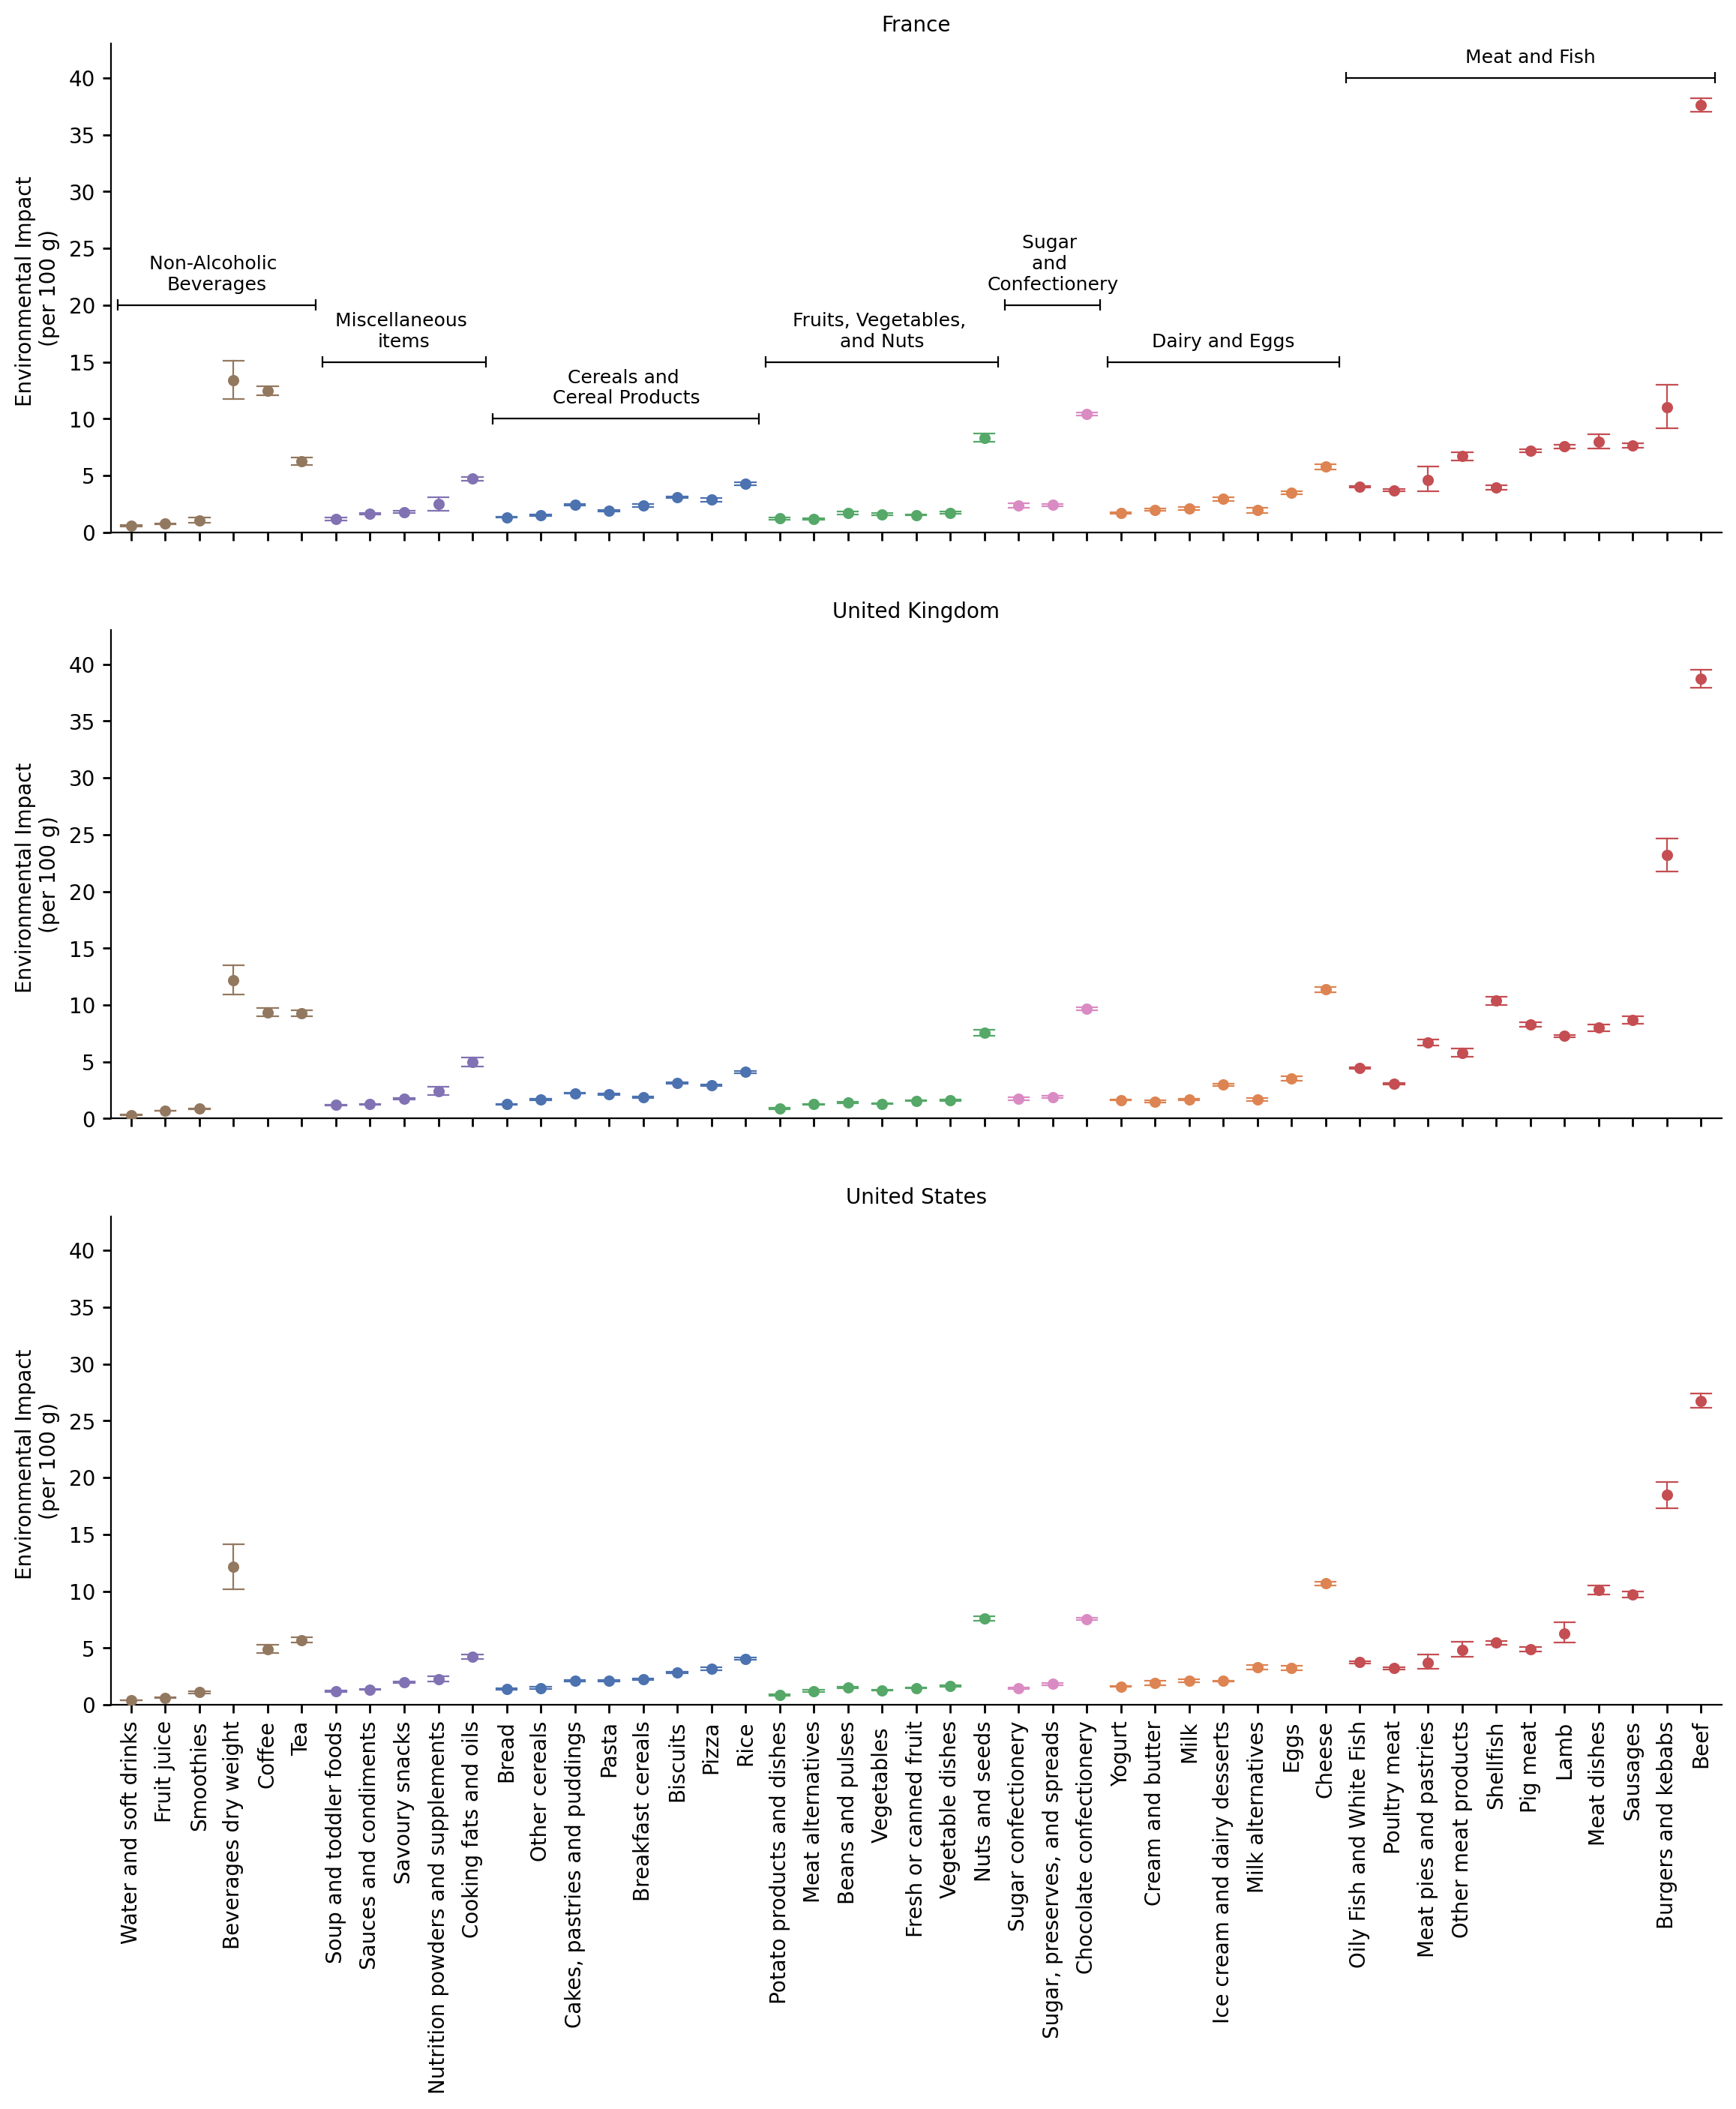

In [102]:
# Initialize the FacetGrid
g = sns.FacetGrid(df_plot_global, 
                  row='country', 
                  sharey=True,
                  height=4, aspect=3)

# Define the plotting function
def plot_errorbar(data, color, **kwargs):
    sns.pointplot(
        x='labels', 
        y='mean_norm', 
        hue='groups',
        data=data,
        order=order_df['labels'].values,
        join=False, 
        capsize=0.6,
        errorbar='se',
        errwidth=0.8, 
        markers='.',
        markersize=0.5,
        palette='deep'
    )

# Map the plotting function to each facet
g.map_dataframe(plot_errorbar)

# Rotate x-axis labels vertically
for ax in g.axes.flatten():
    ax.tick_params(axis='x', which='major', bottom=True, top=False, length=4, width=1)
    ax.tick_params(axis='y', which='major', left=True, right=False, length=4, width=1)
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Add axis labels
g.set_axis_labels("", "Environmental Impact \n(per 100 g)")
g.set_titles("{row_name}", size=10)
g.figure.subplots_adjust(hspace=0.2)

# Add group labels and lines with endpoint markers ONLY to the top plot
top_ax = g.axes.flatten()[0]  

# Get x-tick positions and labels
xticks = g.axes.flatten()[2].get_xticks()
xticklabels = [label.get_text() for label in g.axes.flatten()[2].get_xticklabels()]

groups = [
    {"label": "Cereals and \nCereal Products", 
     "start": order_df[order_df['groups']=="Cereals and Cereal Products"]['labels'].values[0], 
     "end": order_df[order_df['groups']=="Cereals and Cereal Products"]['labels'].values[-1], 
     "y": 10},
    {"label": "Dairy and Eggs", 
     "start": order_df[order_df['groups']=="Dairy and Eggs"]['labels'].values[0], 
     "end": order_df[order_df['groups']=="Dairy and Eggs"]['labels'].values[-1], 
     "y": 15},
    {"label": "Meat and Fish", 
     "start": order_df[order_df['groups']=="Meat and Fish"]['labels'].values[0], 
     "end": order_df[order_df['groups']=="Meat and Fish"]['labels'].values[-1], 
     "y": 40},
    {"label": "Fruits, Vegetables, \nand Nuts", 
     "start": order_df[order_df['groups']=="Fruits, Vegetables, and Nuts"]['labels'].values[0], 
     "end": order_df[order_df['groups']=="Fruits, Vegetables, and Nuts"]['labels'].values[-1], 
     "y": 15},
    {"label": "Non-Alcoholic \nBeverages", 
     "start": order_df[order_df['groups']=="Non-Alcoholic Beverages"]['labels'].values[0], 
     "end": order_df[order_df['groups']=="Non-Alcoholic Beverages"]['labels'].values[-1], 
     "y": 20},
    {"label": "Sugar \nand \nConfectionery", 
     "start": order_df[order_df['groups']=="Sugar and Confectionery"]['labels'].values[0], 
     "end": order_df[order_df['groups']=="Sugar and Confectionery"]['labels'].values[-1], 
     "y": 20},
    {"label": "Miscellaneous \nitems", 
     "start": order_df[order_df['groups']=="Miscellaneous items"]['labels'].values[0], 
     "end": order_df[order_df['groups']=="Miscellaneous items"]['labels'].values[-1], 
     "y": 15}
]


# Add group annotations
for group in groups:
    try:
        xmin = xticks[xticklabels.index(group['start'])] - 0.4
        xmax = xticks[xticklabels.index(group['end'])] + 0.4

        # Add group label 
        top_ax.text((xmin + xmax) / 2, group['y'] + 1,
                    group['label'], ha='center', va='bottom',
                    fontsize=9)  

        # Add narrower horizontal line
        line_width = 0.8  # Narrower line width
        top_ax.hlines(y=group['y'], xmin=xmin, xmax=xmax, color='black', linewidth=line_width)

        # Add vertical bars at endpoints
        bar_height = 1  # Adjust height for subtle look
        top_ax.vlines(x=xmin, ymin=group['y'] - bar_height / 2, ymax=group['y'] + bar_height / 2, 
                      color='black', linewidth=line_width)
        top_ax.vlines(x=xmax, ymin=group['y'] - bar_height / 2, ymax=group['y'] + bar_height / 2, 
                      color='black', linewidth=line_width)
    except ValueError:
        # Skip if the label isn't found
        continue

# Remove extra space at the beginning of the x-axis
# Adjusting based on the actual tick positions
min_tick = min(xticks)
max_tick = max(xticks)
top_ax.set_xlim(min_tick - 0.6, max_tick + 0.6)  # Adding slight padding after trimming
top_ax.set_ylim(0, 43)

# Adjust layout and display the plot
# plt.tight_layout()
plt.show()

In [96]:
df_plot_global.groupby(['country', 'labels'])[['mean_norm']].mean().reset_index().sort_values(by='mean_norm')

country                             labels  mean_norm
92   United Kingdom              Water and soft drinks   0.327119
139   United States              Water and soft drinks   0.421542
45           France              Water and soft drinks   0.580793
109   United States                        Fruit juice   0.632109
62   United Kingdom                        Fruit juice   0.693696
15           France                        Fruit juice   0.760006
85   United Kingdom                          Smoothies   0.861307
78   United Kingdom         Potato products and dishes   0.862482
125   United States         Potato products and dishes   0.888379
38           France                          Smoothies   1.065661
132   United States                          Smoothies   1.114980
18           France                  Meat alternatives   1.167837
39           France             Soup and toddler foods   1.170494
86   United Kingdom             Soup and toddler foods   1.203313
133   United States             Soup and toddler foods   1.214122
112   United States                  Meat alternatives   1.225734
31           France         Potato products and dishes   1.227927
65   United Kingdom                  Meat alternatives   1.255632
81   United Kingdom              Sauces and condiments   1.264796
51   United Kingdom                              Bread   1.274085
138   United States                        Vegetables    1.294934
91   United Kingdom                        Vegetables    1.313847
4            France                              Bread   1.337763
128   United States              Sauces and condiments   1.358428
98    United States                              Bread   1.398589
47   United Kingdom                   Beans and pulses   1.418123
134   United States                Sugar confectionery   1.467643
120   United States                      Other cereals   1.488902
108   United States              Fresh or canned fruit   1.490044
59   United Kingdom                   Cream and butter   1.508514
26           France                      Other cereals   1.521750
94    United States                   Beans and pulses   1.522098
14           France              Fresh or canned fruit   1.531832
61   United Kingdom              Fresh or canned fruit   1.568477
44           France                        Vegetables    1.598268
140   United States                             Yogurt   1.604314
90   United Kingdom                   Vegetable dishes   1.632040
93   United Kingdom                             Yogurt   1.633106
34           France              Sauces and condiments   1.644306
137   United States                   Vegetable dishes   1.651443
73   United Kingdom                      Other cereals   1.662409
69   United Kingdom                  Milk alternatives   1.675592
0            France                   Beans and pulses   1.687054
68   United Kingdom                               Milk   1.707194
46           France                             Yogurt   1.721048
43           France                   Vegetable dishes   1.733539
87   United Kingdom                Sugar confectionery   1.748924
83   United Kingdom                     Savoury snacks   1.749792
36           France                     Savoury snacks   1.785718
135   United States      Sugar, preserves, and spreads   1.833206
88   United Kingdom      Sugar, preserves, and spreads   1.878327
52   United Kingdom                  Breakfast cereals   1.885675
28           France                              Pasta   1.919791
106   United States                   Cream and butter   1.932346
22           France                  Milk alternatives   1.934268
130   United States                     Savoury snacks   1.977752
12           France                   Cream and butter   1.984396
110   United States       Ice cream and dairy desserts   2.102231
122   United States                              Pasta   2.102910
21           France                               Mi

In [65]:
melted_df_compare = melted_df.merge(melted_df_global, on=['country', 'groups', 'labels', 'ID', 'product_id'])

In [66]:
melted_df_compare['mean_norm_x'].corr(melted_df_compare['mean_norm_y'])

0.7738287543306678

In [67]:
melted_df_compare.groupby('labels')[['mean_norm_x','mean_norm_y']].corr().unstack().iloc[:,1].sort_values()

labels
Beef                                -0.080142
Beverages dry weight                 0.524178
Rice                                 0.565747
Chocolate confectionery              0.589167
Burgers and kebabs                   0.643647
Eggs                                 0.662699
Meat pies and pastries               0.686391
Milk                                 0.695502
Meat dishes                          0.715972
Sugar confectionery                  0.733495
Other meat products                  0.736217
Vegetables                           0.741293
Cream and butter                     0.746797
Ice cream and dairy desserts         0.747675
Biscuits                             0.748184
Other cereals                        0.760967
Beans and pulses                     0.763803
Cakes, pastries and puddings         0.766669
Smoothies                            0.771868
Breakfast cereals                    0.775829
Pig meat                             0.790360
Yogurt                     

In [100]:
# melted_df_compare = melted_df_compare[(melted_df_compare['labels']!='mis')
#                  & (melted_df_compare['country'].isin(['France', 'United Kingdom', 'United States']))
#                  ].groupby(['country', 'groups', 'labels', 'ID'])[['mean_norm_x','mean_norm_y']].corr().unstack().reset_index()
# melted_df_compare.columns = ['country', 'groups', 'labels', 'ID', 'drop1', 'corr', 'drop2', 'drop3']
# melted_df_compare = melted_df_compare.drop(['drop1', 'drop2', 'drop3'], axis=1)
# melted_df_compare = melted_df_compare.pivot(index=['groups', 'labels', 'ID'], columns='country', values='corr').reset_index()
# melted_df_compare.sort_values(by='ID')

#### summary of all other countries

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/seaborn/categorical.py:3808: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


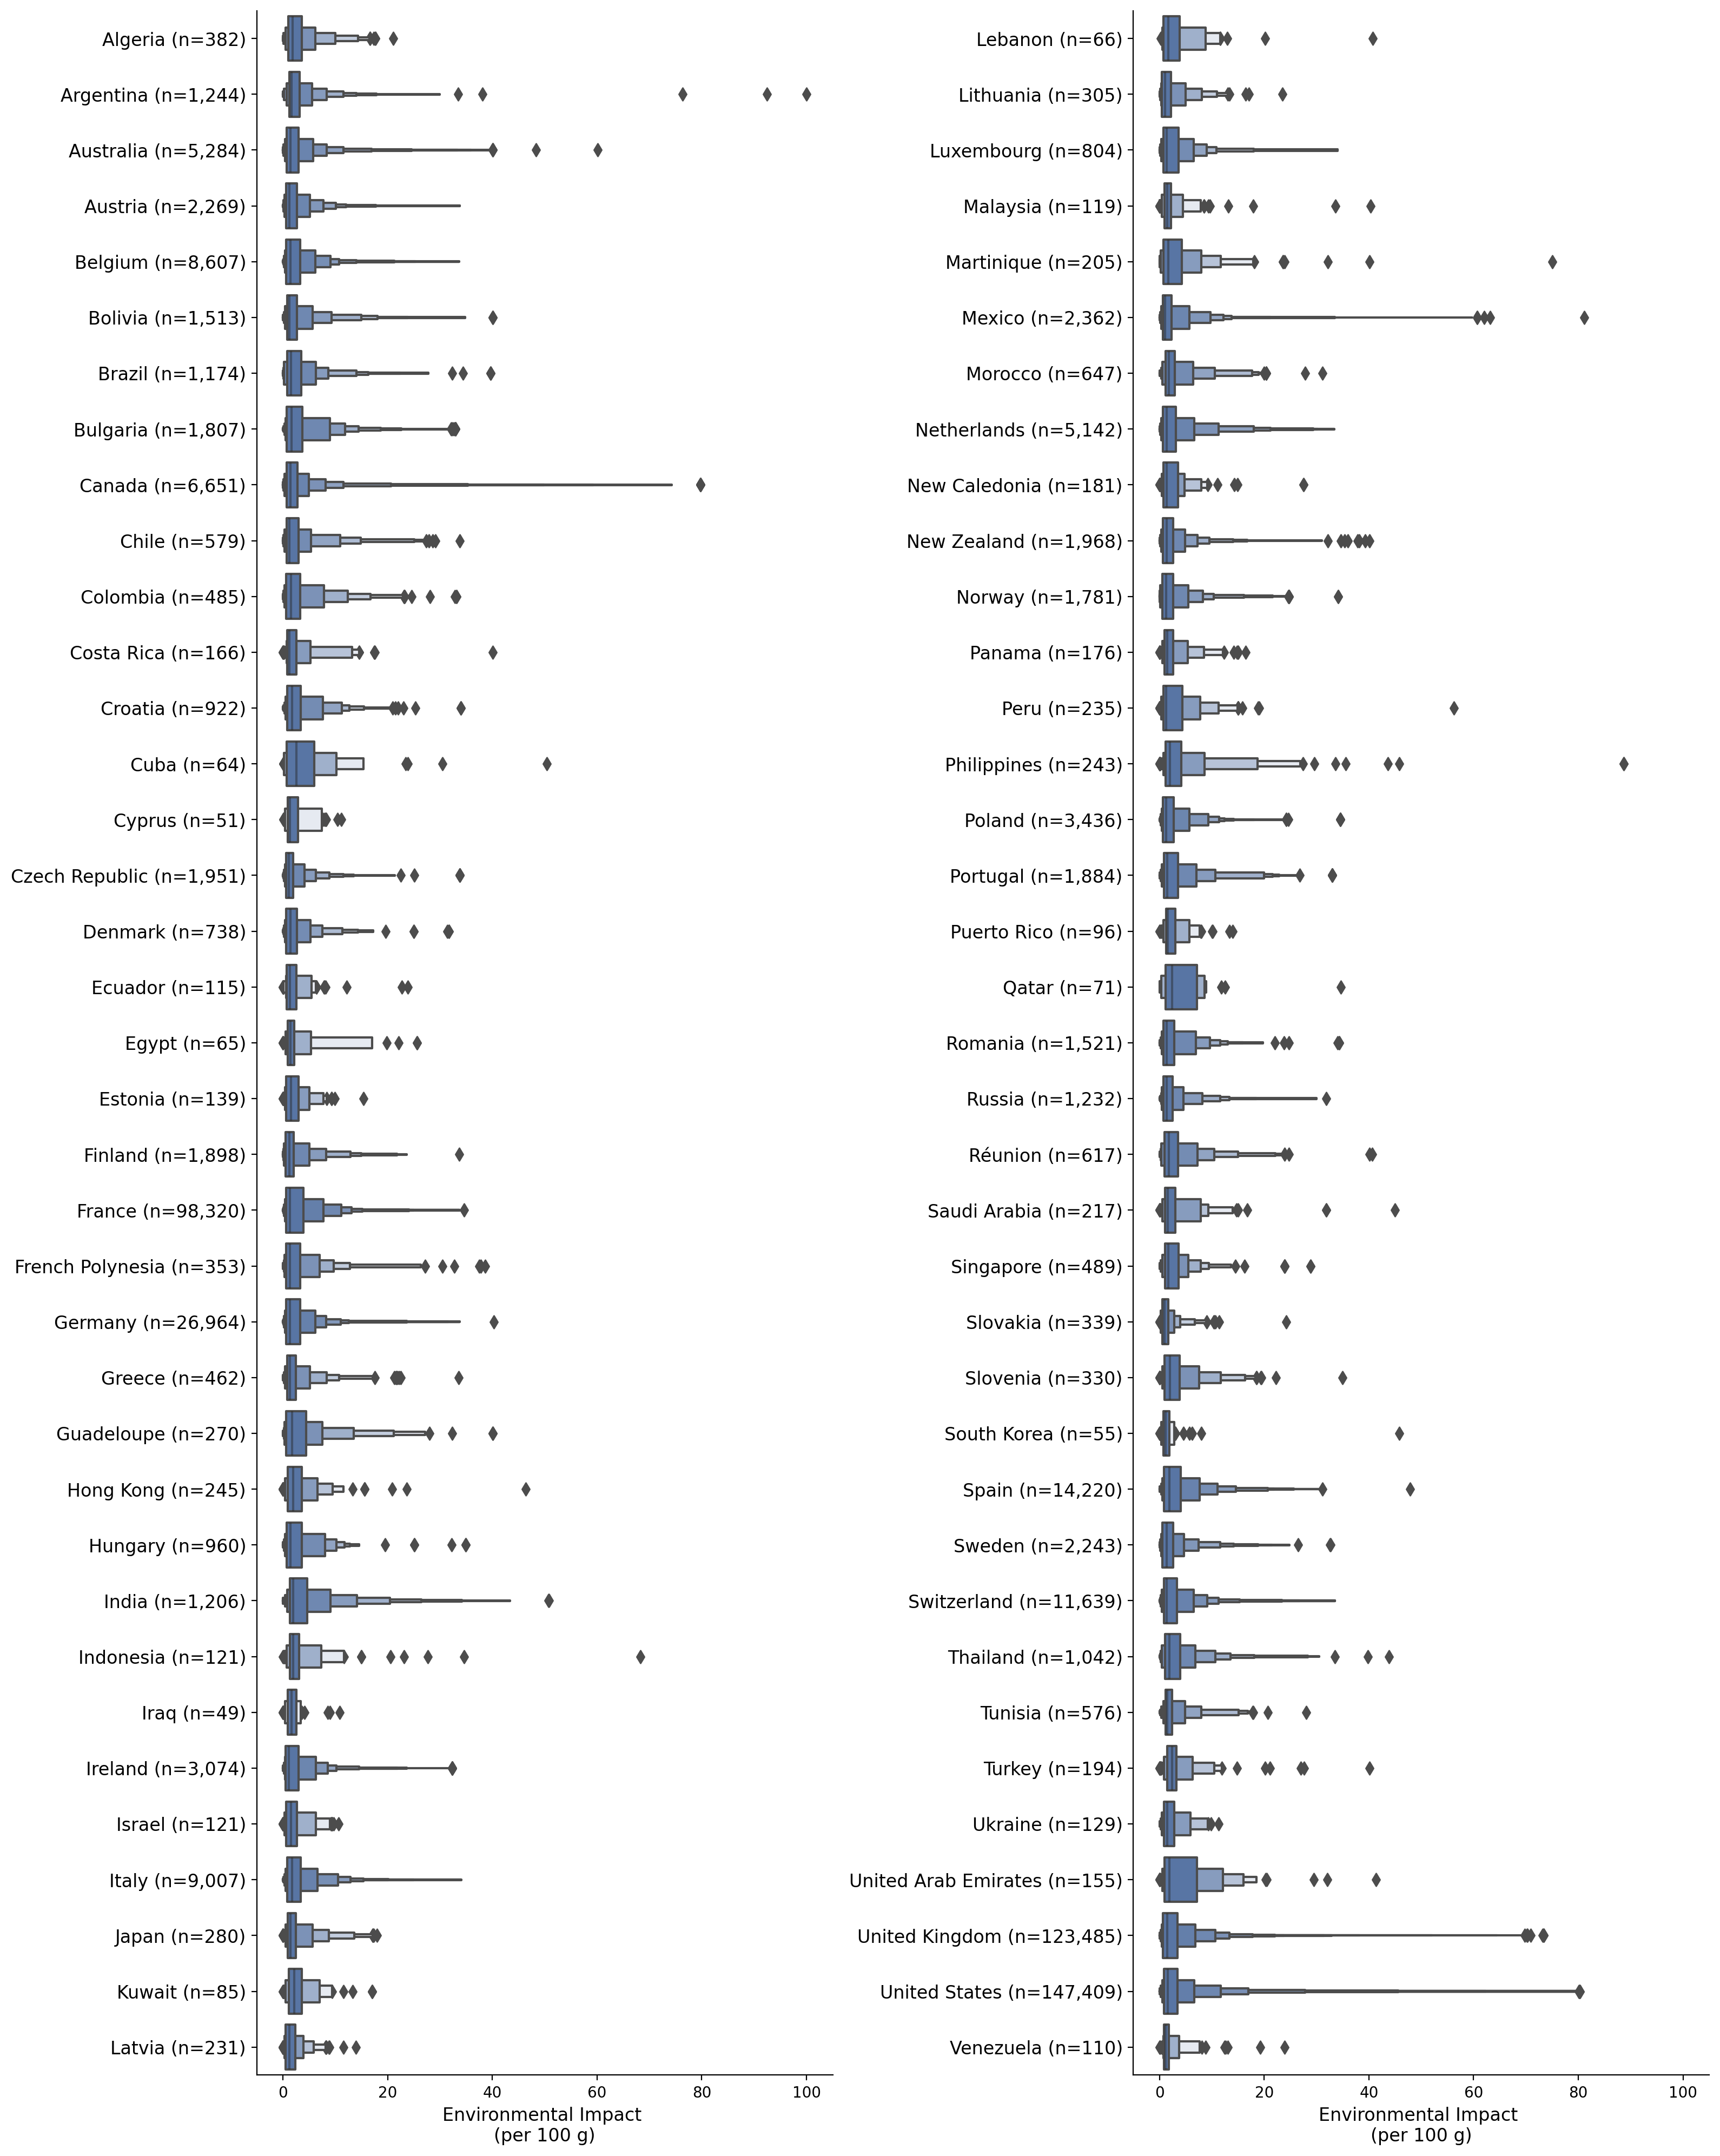

In [103]:
sns.set_color_codes()
unique_countries = sorted(melted_df['country'].unique())
n_per_facet = 37
country_to_facet = {country: i // n_per_facet for i, country in enumerate(unique_countries)}
melted_df['facet'] = melted_df['country'].map(country_to_facet)
country_counts = melted_df['country'].value_counts()
pal = {country: "b" for country in unique_countries}

g = sns.catplot(
    data=melted_df,
    kind="boxen",
    x="mean_norm",
    y="country",
    col="facet",
    col_wrap=2,  
    palette=pal,
    sharex=True,  
    sharey=False,
    height=20,
    aspect=0.4
)

for ax in g.axes.flat:
    ax.set_xlabel("Environmental Impact \n(per 100 g)", fontsize=12)
    ax.set_ylabel("")
    new_labels = []
    for label in ax.get_yticklabels():
        country = label.get_text()
        # Lookup the count; default to 0 if country is not found (shouldn't happen)
        count = country_counts.get(country, 0)
        # Format count with commas (e.g., 1,000)
        new_labels.append(f"{country} (n={count:,})")
    ax.set_yticklabels(new_labels, fontsize=12)
    
g.set_titles("")

plt.tight_layout()
plt.show()

In [104]:
melted_df[['mean_norm']].describe()

mean_norm
count  503575.000000
mean        3.192722
std         5.284197
min         0.000000
25%         0.753610
50%         1.491894
75%         3.444225
max       100.000000

In [105]:
# melted_df.groupby('country')[['mean_norm']].agg(['mean', 'median', 'max'])

In [82]:
impacts[['mean_Land', 'mean_GHG', 'mean_Eut', 'mean_WatScar', 'mean_Biodiversity']].describe() # this is not normalized (just checking that all indicators are right skewed)

mean_Land       mean_GHG       mean_Eut   mean_WatScar  \
count  503575.000000  503575.000000  503575.000000  503575.000000   
mean        0.655470       0.353916       2.259448    1790.150682   
std         1.380336       0.573820       9.422272    3536.674465   
min         0.000000      -0.314281       0.000000       0.000000   
25%         0.123848       0.089823       0.406296     183.025053   
50%         0.265781       0.170985       0.835297     564.205408   
75%         0.660597       0.322053       1.788893    1733.452620   
max        70.884276      19.620369     208.949239   60445.044578   

       mean_Biodiversity  
count      503575.000000  
mean           17.875173  
std            47.024872  
min             0.000000  
25%             1.456594  
50%             4.741966  
75%            14.953230  
max          3885.707040

In [92]:
impacts[impacts['product_id'].isin(melted_df[melted_df['mean_norm']<0.05].sample(10)['product_id'].unique())][[
    'product_name', 'country']].values

array([['Lemon lime naturally caffeinated sparkling water, lemon lime',
        'United States'],
       ['Lucozade Wild Cherry', 'Germany'],
       ['Red Bull Energy Drink Red Edition ', 'United Kingdom'],
       ['water', 'Greece'],
       ['Natural spring water', 'France'],
       ['Pajitas', 'Spain'],
       ['Premium Cubed Boneless Ham', 'United States'],
       ['Lemon lemonade 0% sugar, lemon', 'Germany'],
       ['Diet Coke Caffeine Free Cans', 'United Kingdom'],
       ['Vitamin effervescent tablets 20 pieces lemon aroma',
        'Switzerland']], dtype=object)

In [78]:
impacts[impacts['product_id'].isin(melted_df[melted_df['mean_norm']>80].sample(10)['product_id'].unique())][[
    'product_name', 'country']].values

array([['Dutché Cocoa Powder', 'Philippines'],
       ['cocoa powder', 'Philippines'],
       ['Jalapeño Beef Sticks', 'United States'],
       ['100% grass fed uncured smoked beef jalapeno sausage, jalapeno',
        'United States'],
       ['Uncured hickory smoked wild rice sausage', 'United States'],
       ["Uncured hickory smoked beef 'n cheddar sausage",
        'United States'],
       ['Original Beef Flavor Grass Fed', 'United States'],
       ['MEAT FOR HAMBURGUESA SIRLOIN GRAAT VALUE', 'Mexico'],
       ['Beefjerky', 'United States'],
       ['Classic hamburgers', 'Argentina']], dtype=object)

In [109]:
#### something seems to be wrong with the monte carlo quantiles

df = impacts.copy()
for score in score_columns:
    for col in [f'lower_fifth.impact_{score}',
                f'lower_twentyfifth.impact_{score}',
                f'fifty.impact_{score}',
                f'upper_seventyfifth.impact_{score}',
                f'upper_ninetyfifth.impact_{score}']:
        df[col] = 100 * (df[col] - df[f'mean_{score}'].min()) / (df[f'mean_{score}'].max() - df[f'mean_{score}'].min())
for col in [f'lower_fifth.impact',
            f'lower_twentyfifth.impact',
            f'fifty.impact',
            f'upper_seventyfifth.impact',
            f'upper_ninetyfifth.impact']:
    cols = [f'{col}_{score}' for score in score_columns]
    df[f'{col}'] = df[cols].mean(axis=1) # these are not normalized from 0 to 100 again, as that wouldn't make sense

df['comp_5th'] = ((df['fifty.impact'] - df['lower_fifth.impact']) / df['lower_fifth.impact']) * 100
df['comp_25th'] = ((df['fifty.impact'] - df['lower_twentyfifth.impact']) / df['lower_twentyfifth.impact']) * 100
df['comp_75th'] = ((df['upper_seventyfifth.impact'] - df['fifty.impact']) / df['fifty.impact']) * 100
df['comp_95th'] = ((df['upper_ninetyfifth.impact'] - df['fifty.impact']) / df['fifty.impact']) * 100
# for q in ['5th', '25th', '75th', '95th']:
#     df.loc[df[f'comp_{q}']<0, f'comp_{q}'] = 0
    
df[['comp_5th', 'comp_25th', 'comp_75th', 'comp_95th']].describe()

comp_5th      comp_25th      comp_75th      comp_95th
count  503575.000000  503575.000000  503575.000000  503575.000000
mean       45.451259      16.794489      19.294882      81.412664
std        74.650955      29.330741      41.627636     152.726876
min       -52.724345     -73.506958     -67.498457     -51.717904
25%         8.662693       1.664196       1.745064      15.785268
50%        23.146364       7.137571       7.872898      35.904583
75%        49.517632      18.413066      19.058004      84.484942
max      1397.266193    1291.492815    1148.603446    3250.330173

In [110]:
df.shape

(503575, 142)

In [112]:
impacts[impacts['fifty.impact_Land']>impacts['upper_ninetyfifth.impact_Land']+1][['mean_Land', 
                                                                                  'min.impact_Land',
                                                                                  'max.impact_Land',
                                                                                  'lower_fifth.impact_Land',
                                                                                  'lower_twentyfifth.impact_Land',
                                                                                  'fifty.impact_Land', 
                                                                                  'upper_seventyfifth.impact_Land', 
                                                                                  'upper_ninetyfifth.impact_Land']].head()

mean_Land  min.impact_Land  max.impact_Land  lower_fifth.impact_Land  \
2579   4.469685         1.723038         6.748600                 2.712769   
3884   3.146936         1.861650         6.723195                 2.928359   
3885   3.207817         1.896435         6.858732                 2.985250   
4594   1.986002         1.423426         1.624182                 1.978778   
5351   3.797001         3.003194         4.857726                 3.052904   

      lower_twentyfifth.impact_Land  fifty.impact_Land  \
2579                       3.264800           4.451069   
3884                       2.515519           3.642833   
3885                       2.563854           3.714531   
4594                       1.390325           3.576914   
5351                       3.217527           4.724735   

      upper_seventyfifth.impact_Land  upper_ninetyfifth.impact_Land  
2579                        6.260000                       1.946757  
3884                        3.636399                       2.503939  
3885                        3.707964                       2.552034  
4594                        1.459230                       1.947261  
5351                        3.767399                       3.532556

#### nutrition stuff

In [119]:
nutri = pd.read_csv('../../SFS/environmental_impacts/Managed_Data/NutriScore for radar plots 2025-01-29 Log2.csv')

In [120]:
nutri = nutri.merge(melted_df.drop('country', axis=1), left_on='id', right_on='product_id')
nutri['NutriScorePoints'] = 100 * (nutri['NutriScorePoints'] - nutri['NutriScorePoints'].min()) / (nutri['NutriScorePoints'].max() - nutri['NutriScorePoints'].min())

In [122]:
nutri = nutri[(nutri['country'].isin(['France', 'United Kingdom', 'United States']))
             & (nutri['labels']!='mis')]

In [124]:
df = nutri.groupby(['country', 'groups', 'labels', 'ID'])[['mean_norm', 'NutriScorePoints']].mean().reset_index()

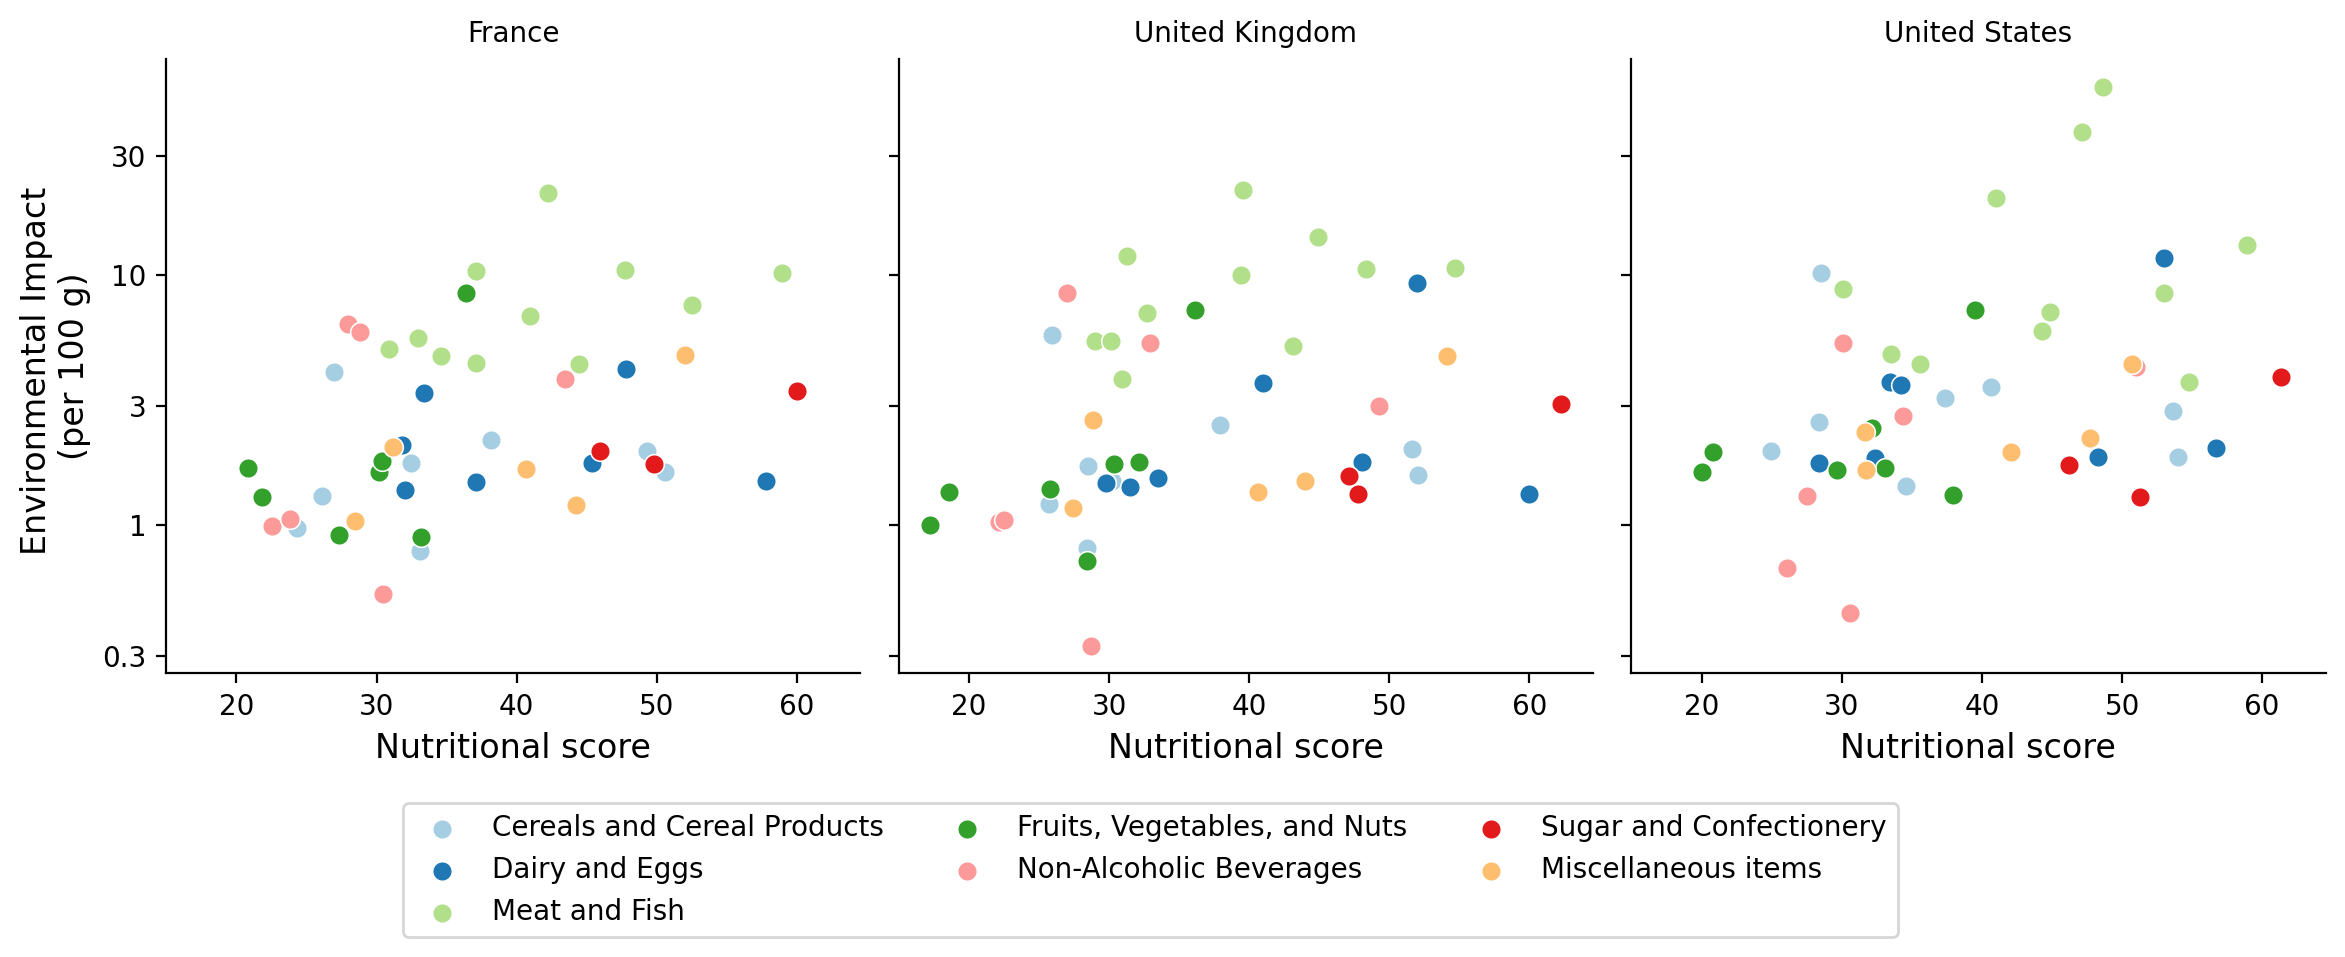

In [125]:
g = sns.FacetGrid(data=df, 
                  col="country",  hue='groups', 
                  hue_order=['Cereals and Cereal Products', 'Dairy and Eggs',
                             'Meat and Fish', 'Fruits, Vegetables, and Nuts',
                             'Non-Alcoholic Beverages', 'Sugar and Confectionery', 'Miscellaneous items'],
                  height=4, aspect=1,
                  palette="Paired")
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm', s=50)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=12)
g.set_xlabels("Nutritional score", fontsize=12)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off()  

g.add_legend(title='', ncol=3, bbox_to_anchor=(0.5, -0.1), frameon=True)

plt.show()

In [126]:
df = nutri.groupby('labels').apply(lambda g: g.sample(100)).reset_index(drop=True)

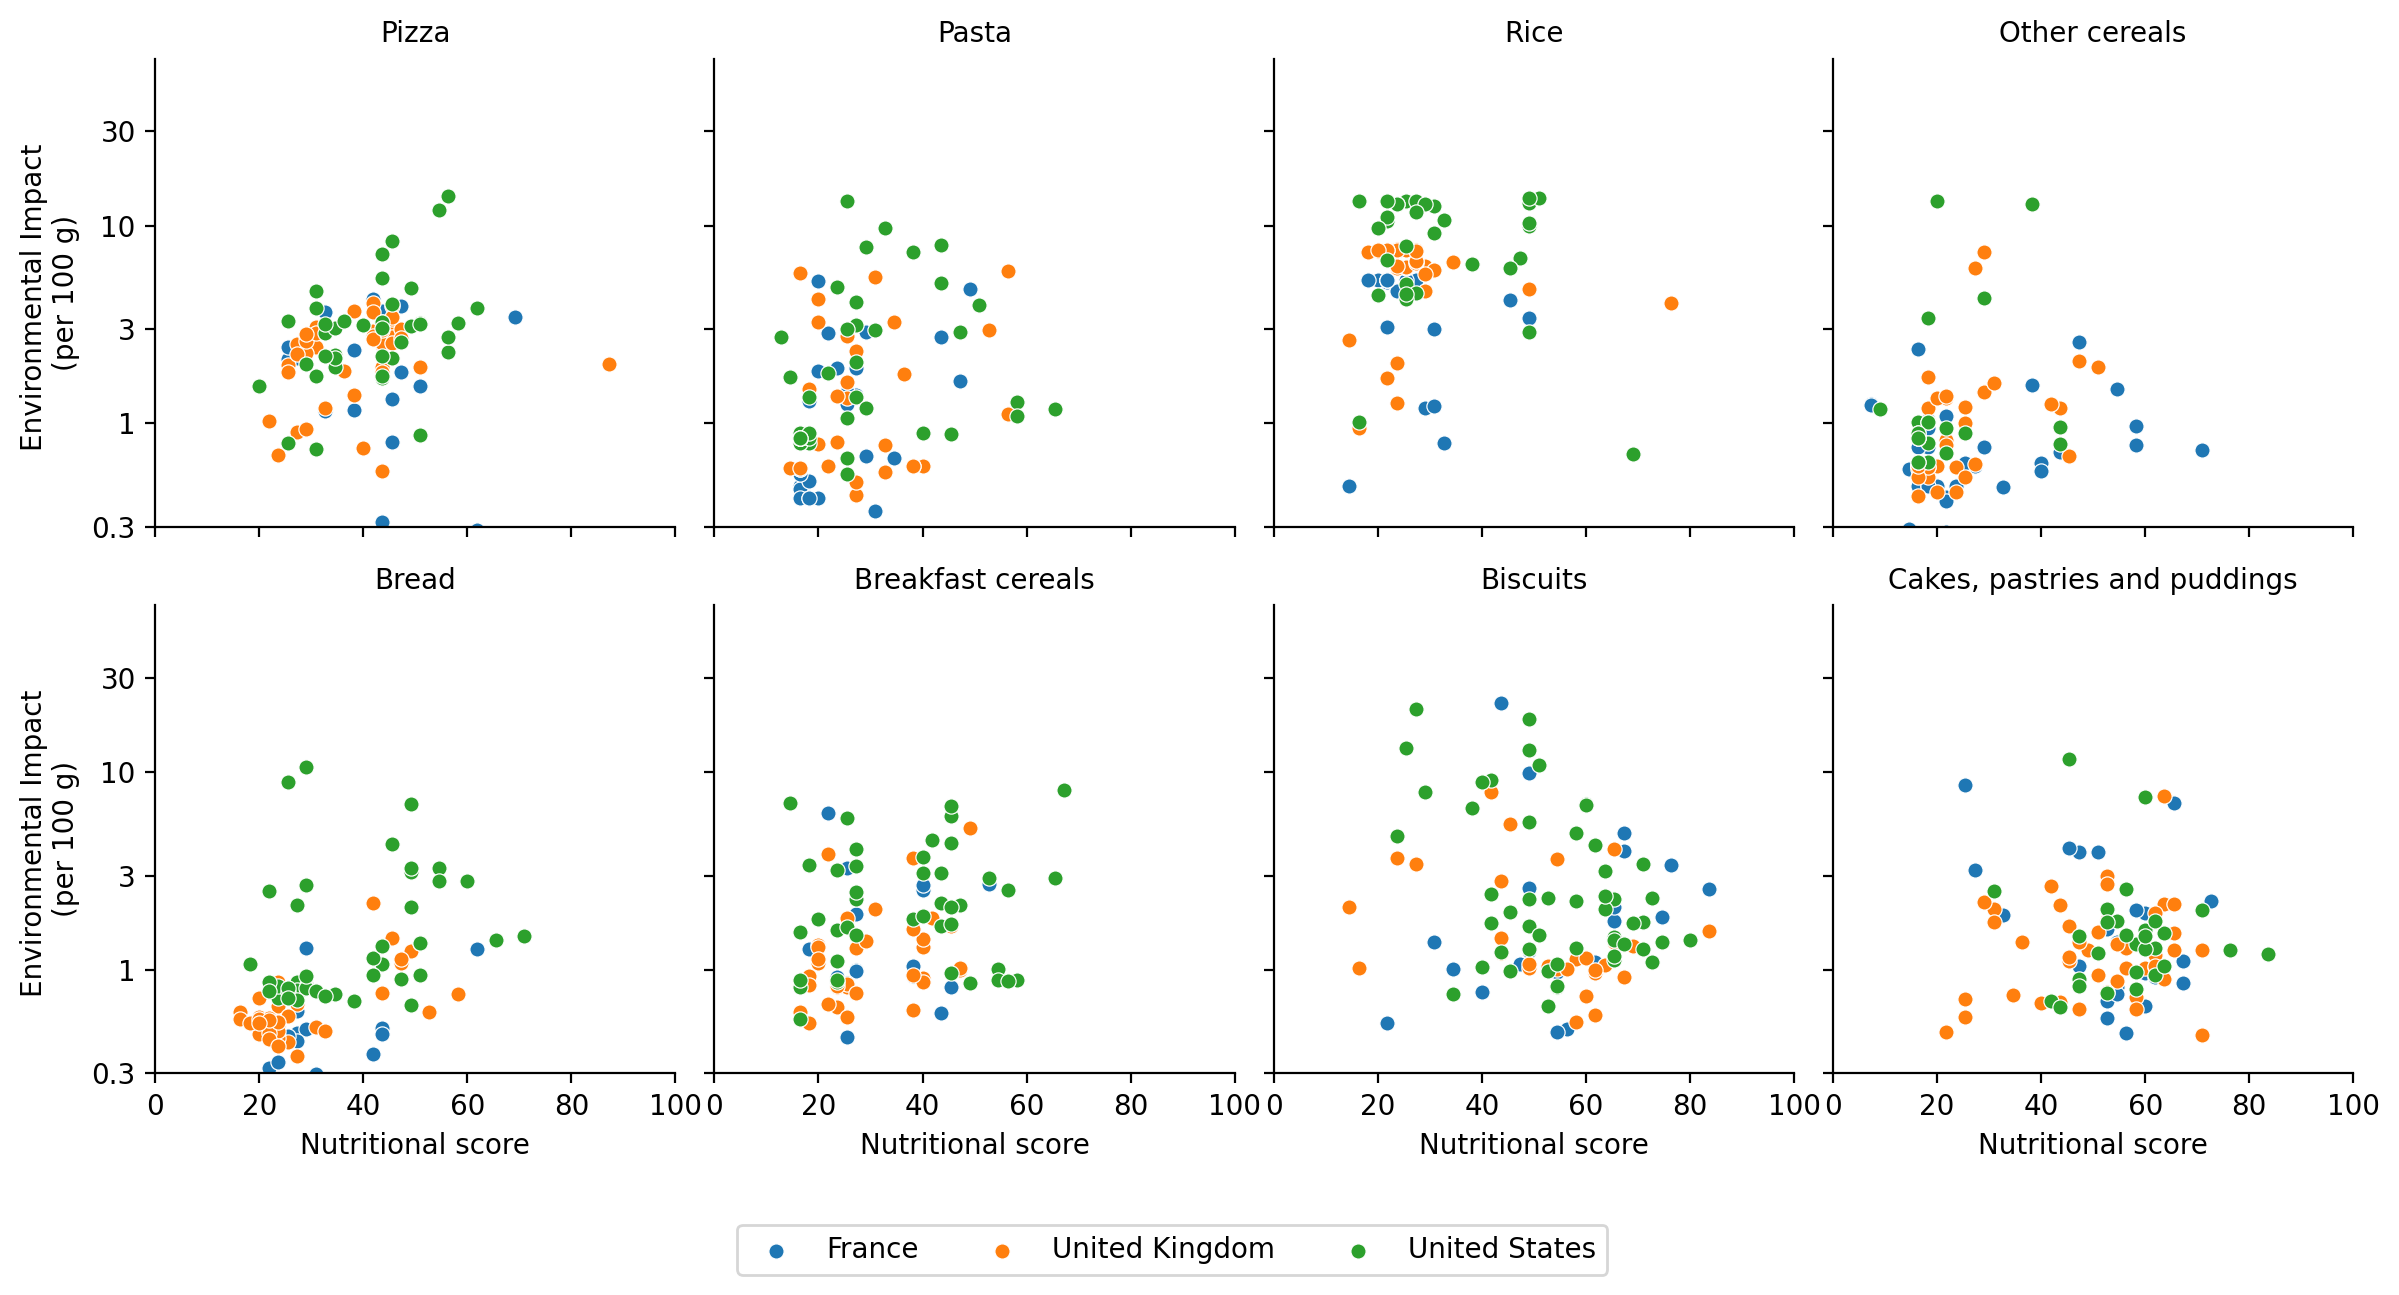

In [127]:
g = sns.FacetGrid(data=df[df['groups']=='Cereals and Cereal Products'].sort_values(by='ID'), 
                  col="labels", hue='country', 
                  hue_order = ['France', 'United Kingdom', 'United States'],
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm', s=30)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off() 
    ax.set_xlim(0, 100)
    ax.set_ylim(0.3, 70)

g.add_legend(title='', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()

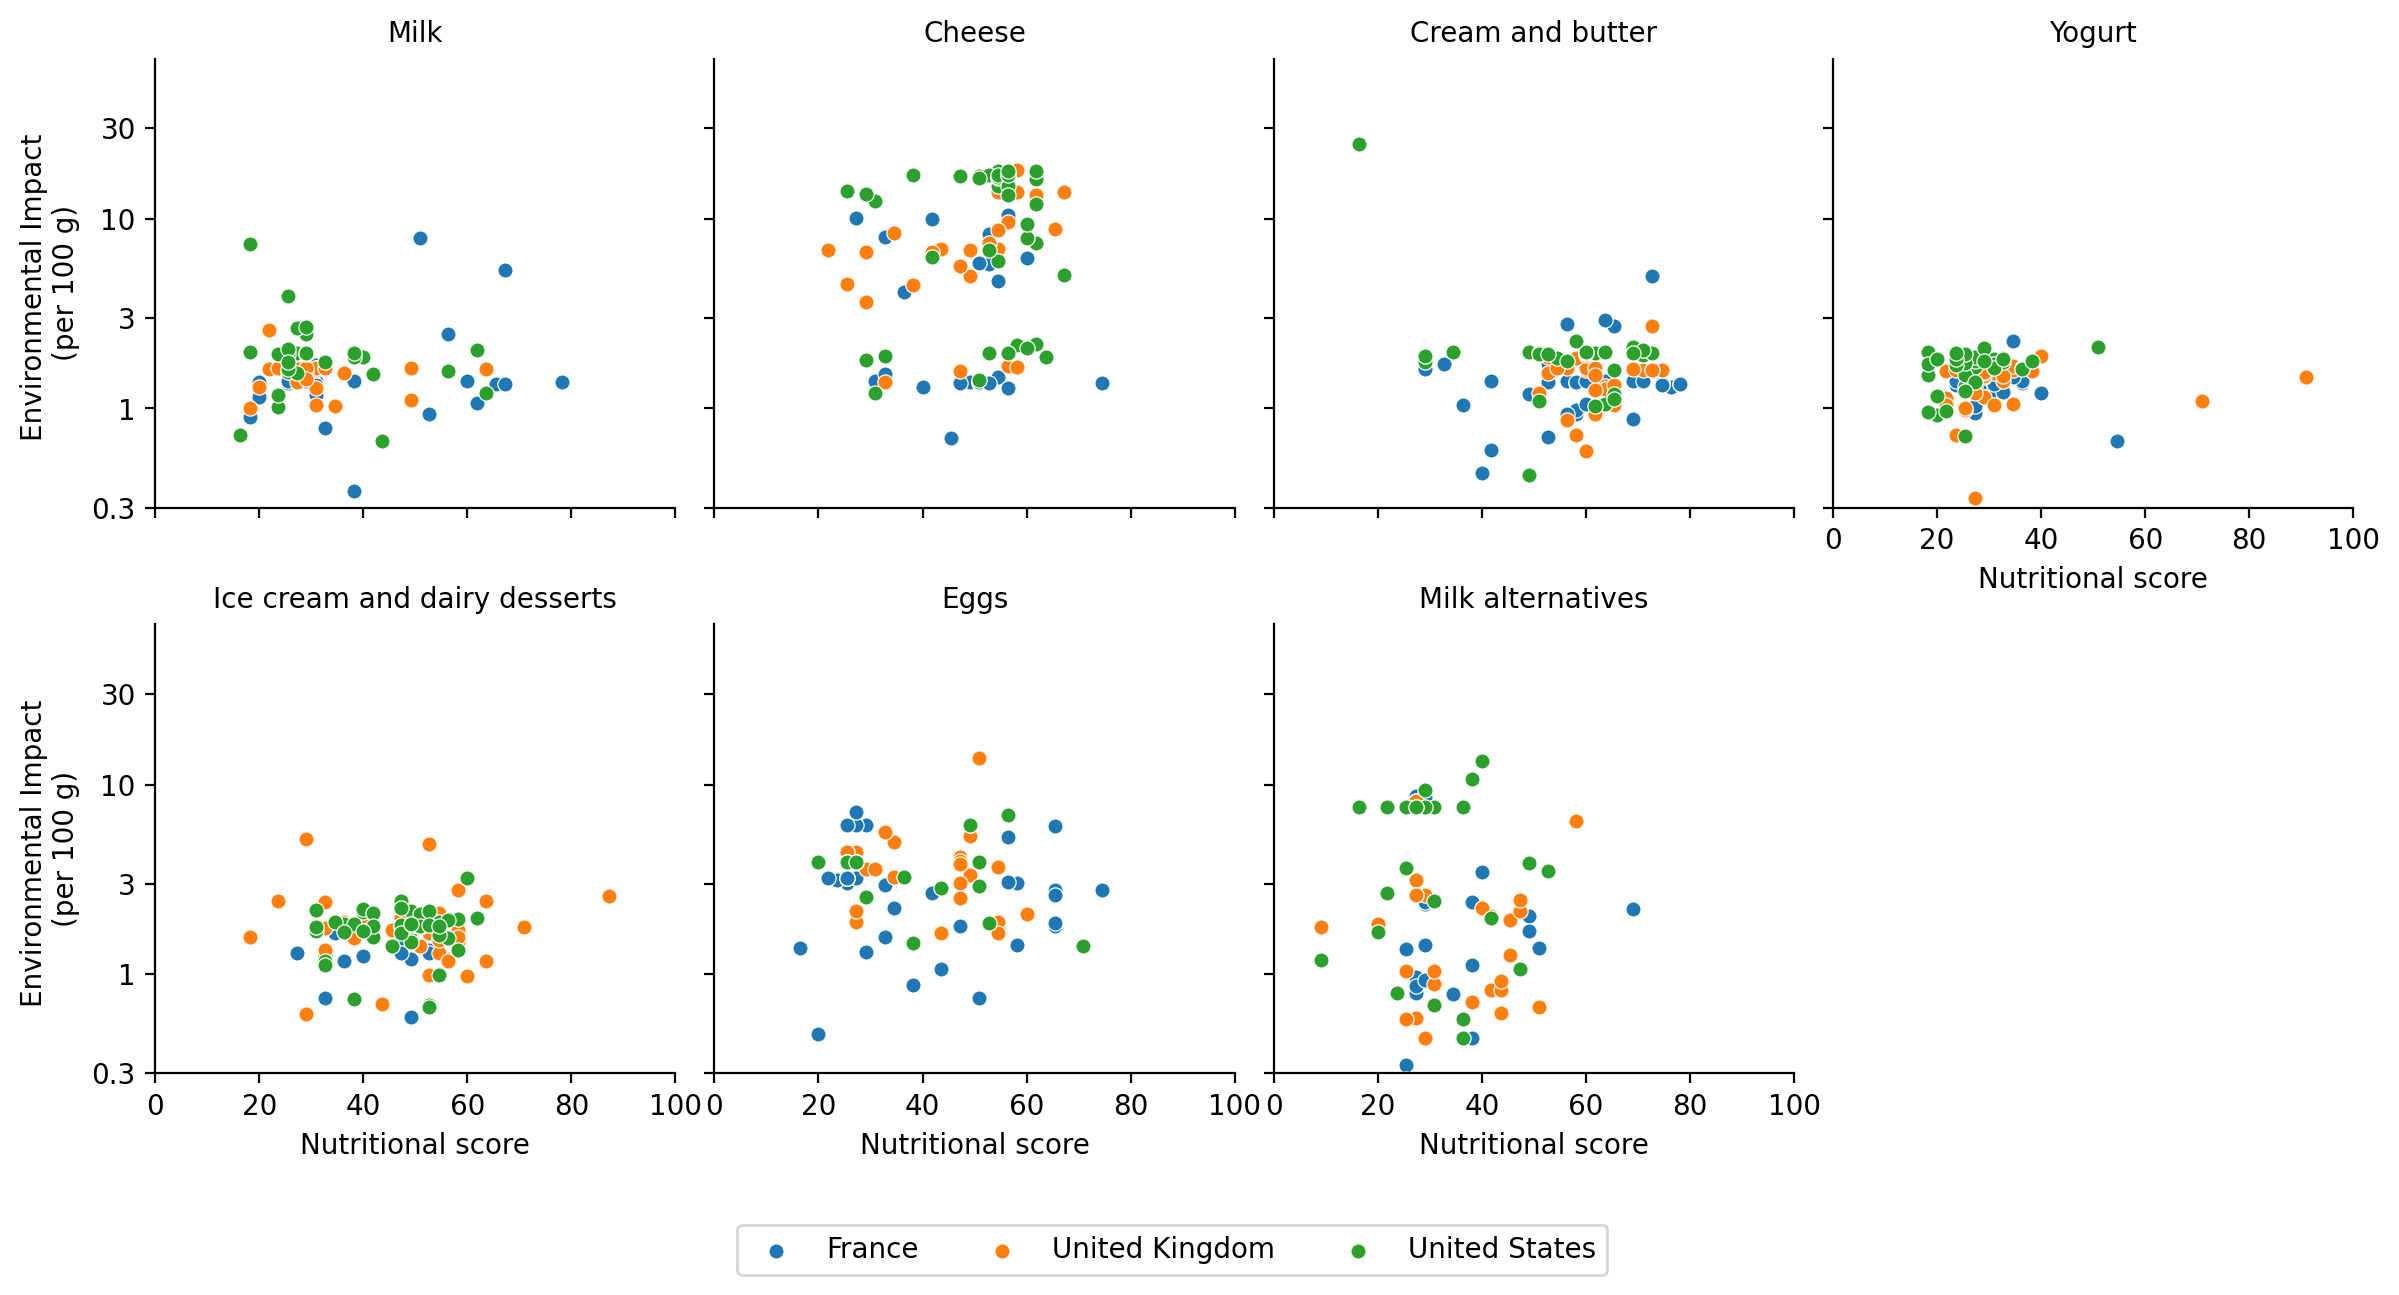

In [128]:
g = sns.FacetGrid(data=df[df['groups']=='Dairy and Eggs'].sort_values(by='ID'), 
                  col="labels", hue='country', 
                  hue_order = ['France', 'United Kingdom', 'United States'],
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm', s=30)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off() 
    ax.set_xlim(0, 100)
    ax.set_ylim(0.3, 70)

g.add_legend(title='', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()

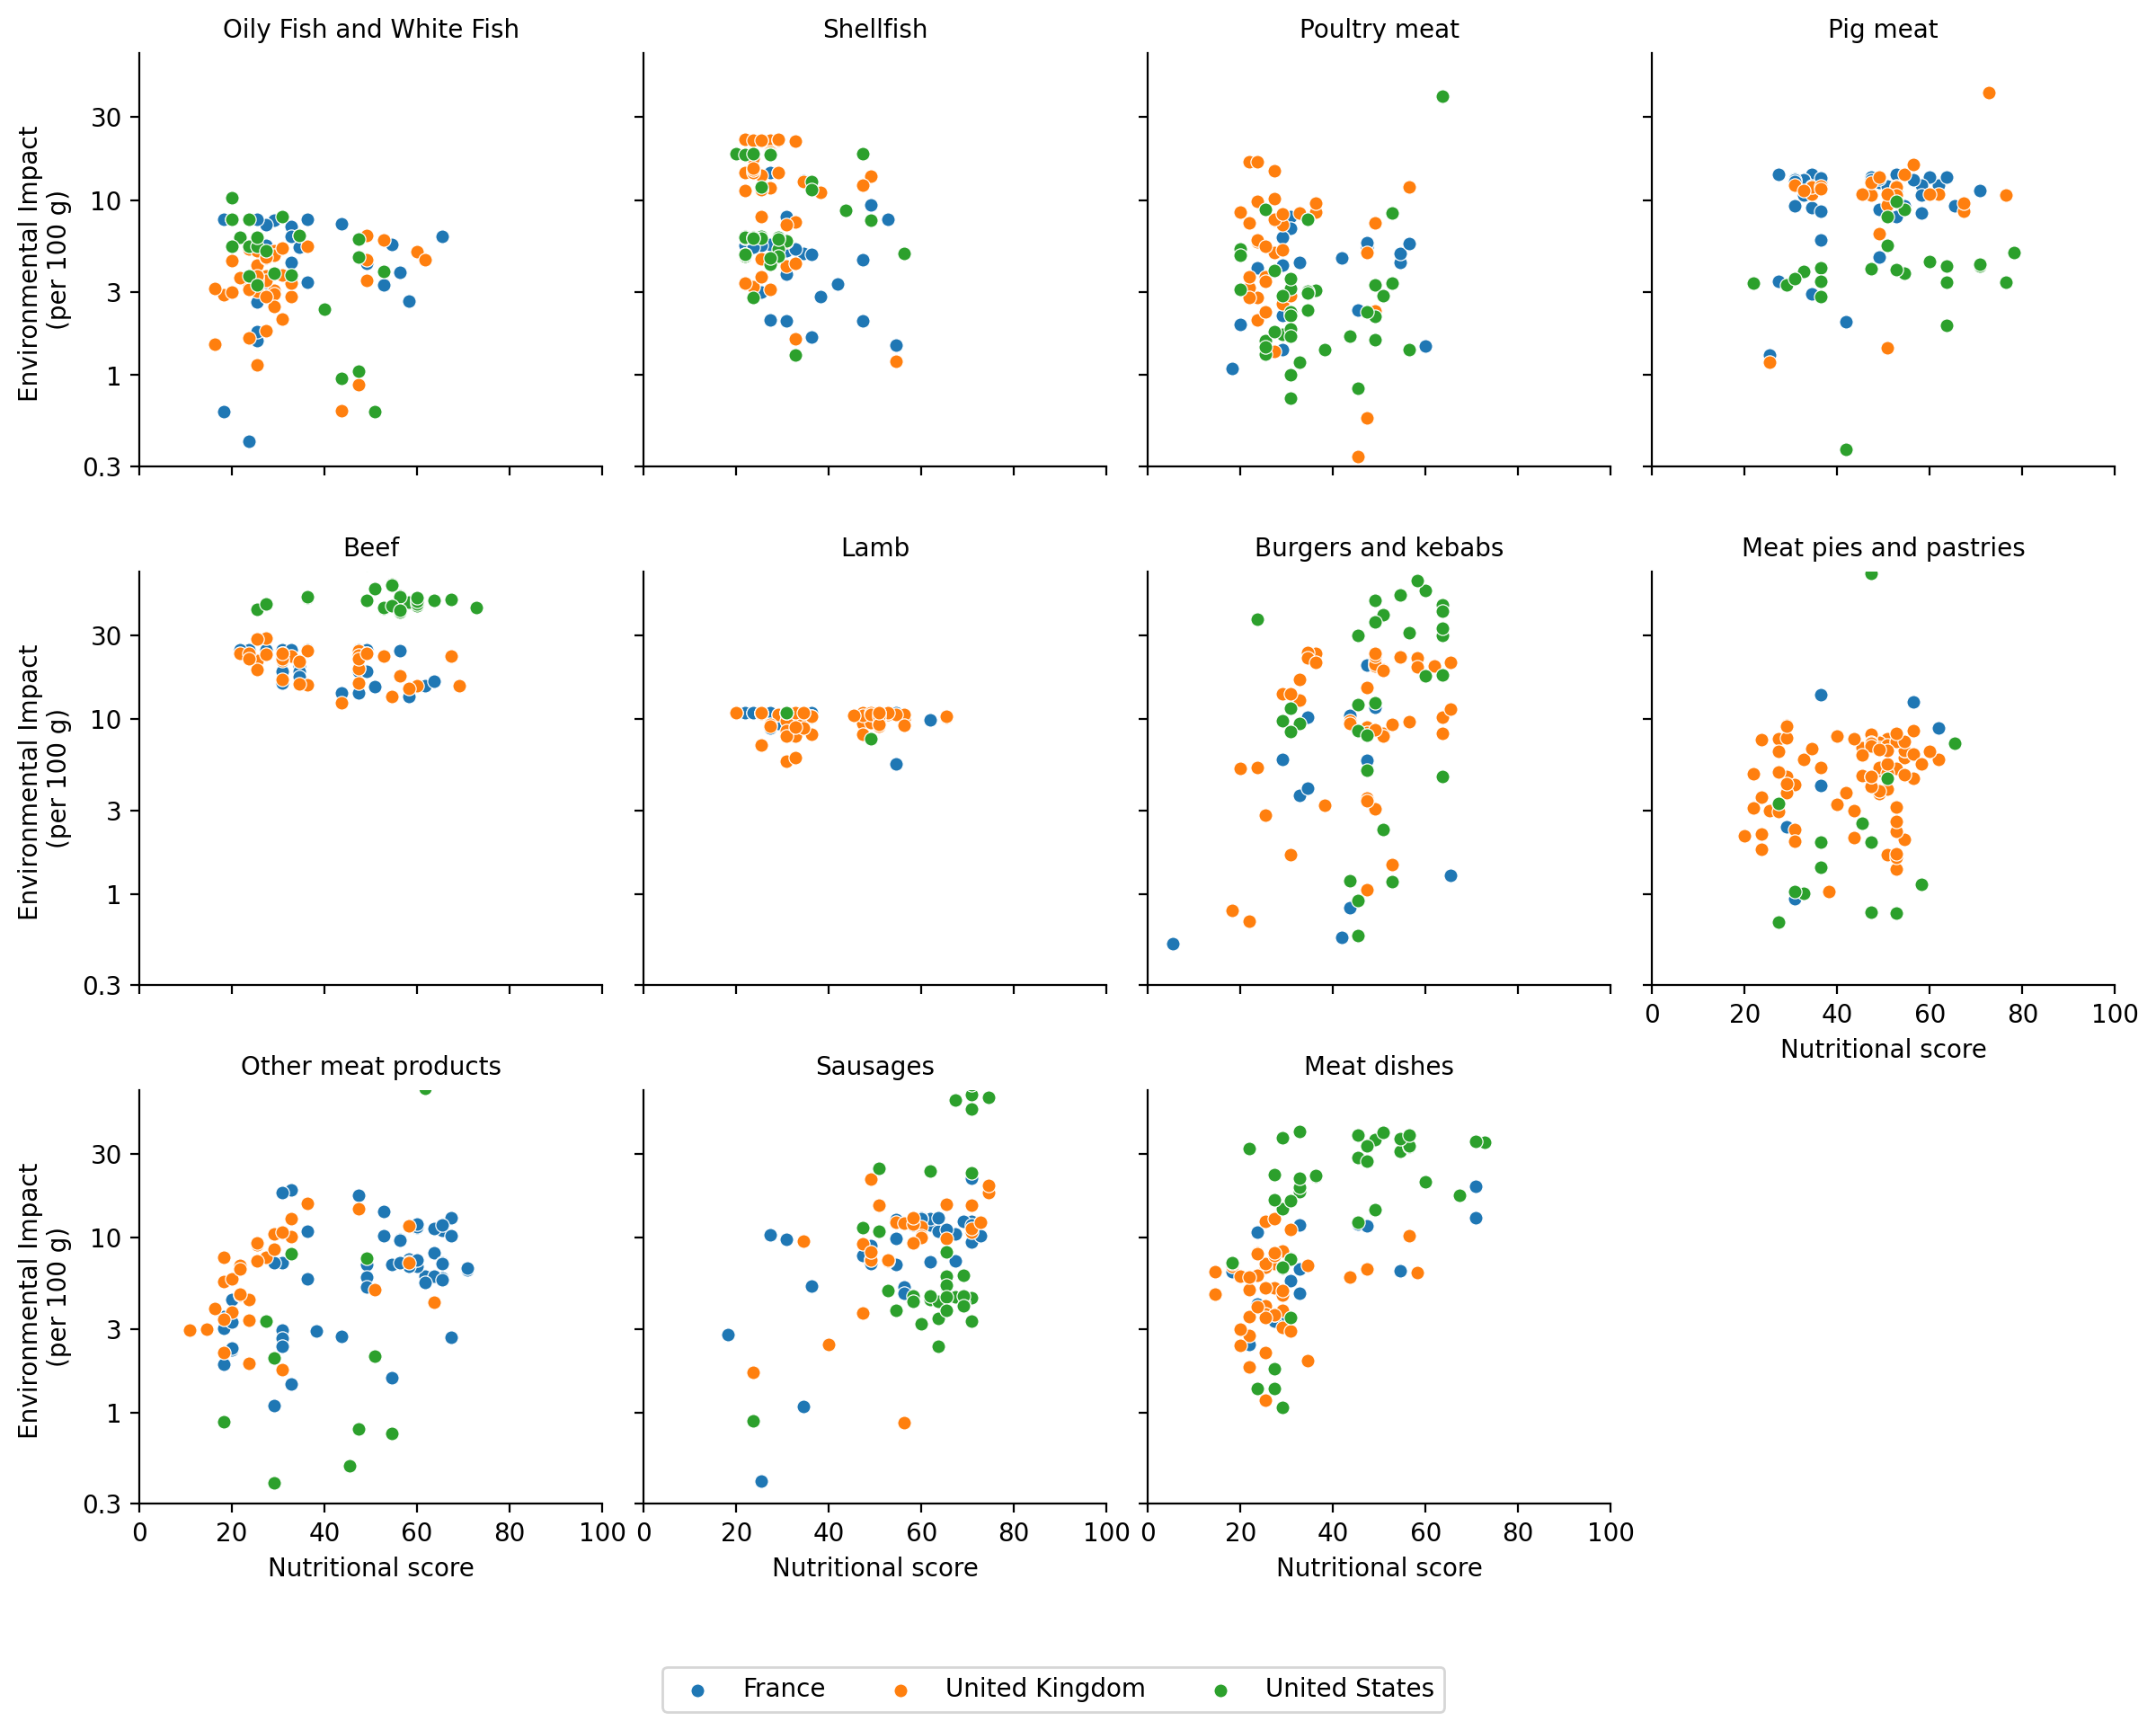

In [129]:
g = sns.FacetGrid(data=df[df['groups']=='Meat and Fish'].sort_values(by='ID'), 
                  col="labels", hue='country', 
                  hue_order = ['France', 'United Kingdom', 'United States'],
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm', s=30)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off()  
    ax.set_xlim(0, 100)
    ax.set_ylim(0.3, 70)

g.add_legend(title='', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()

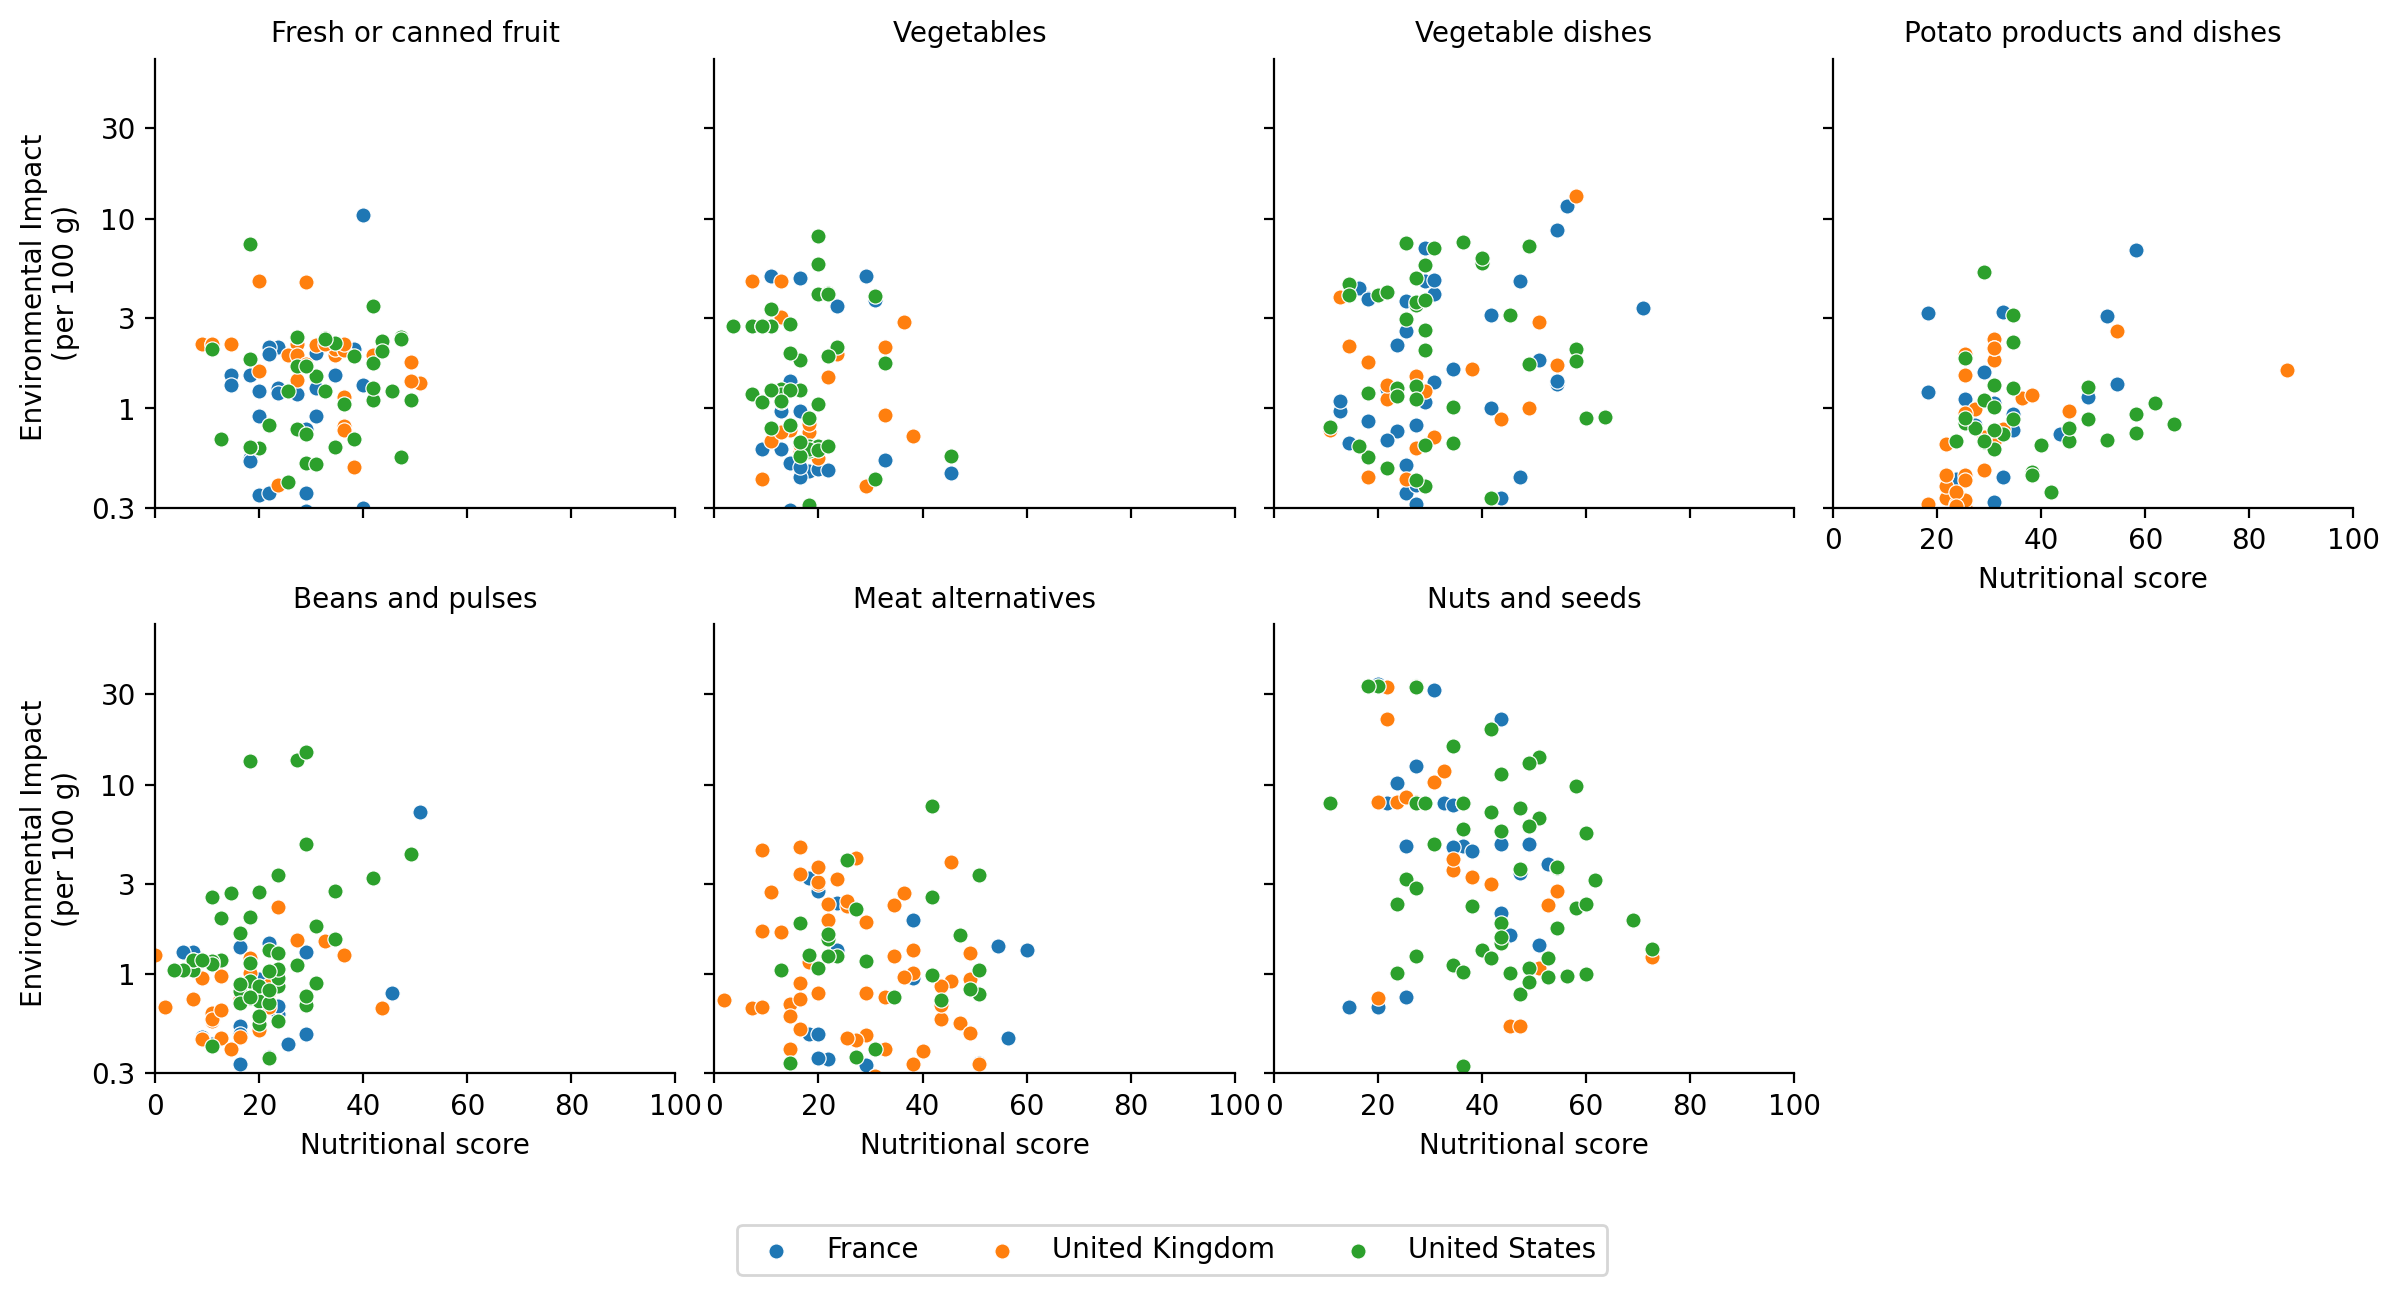

In [130]:
g = sns.FacetGrid(data=df[df['groups']=='Fruits, Vegetables, and Nuts'].sort_values(by='ID'), 
                  col="labels", hue='country',
                  hue_order = ['France', 'United Kingdom', 'United States'],
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm', s=30)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off() 
    ax.set_xlim(0, 100)
    ax.set_ylim(0.3, 70)

g.add_legend(title='', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()

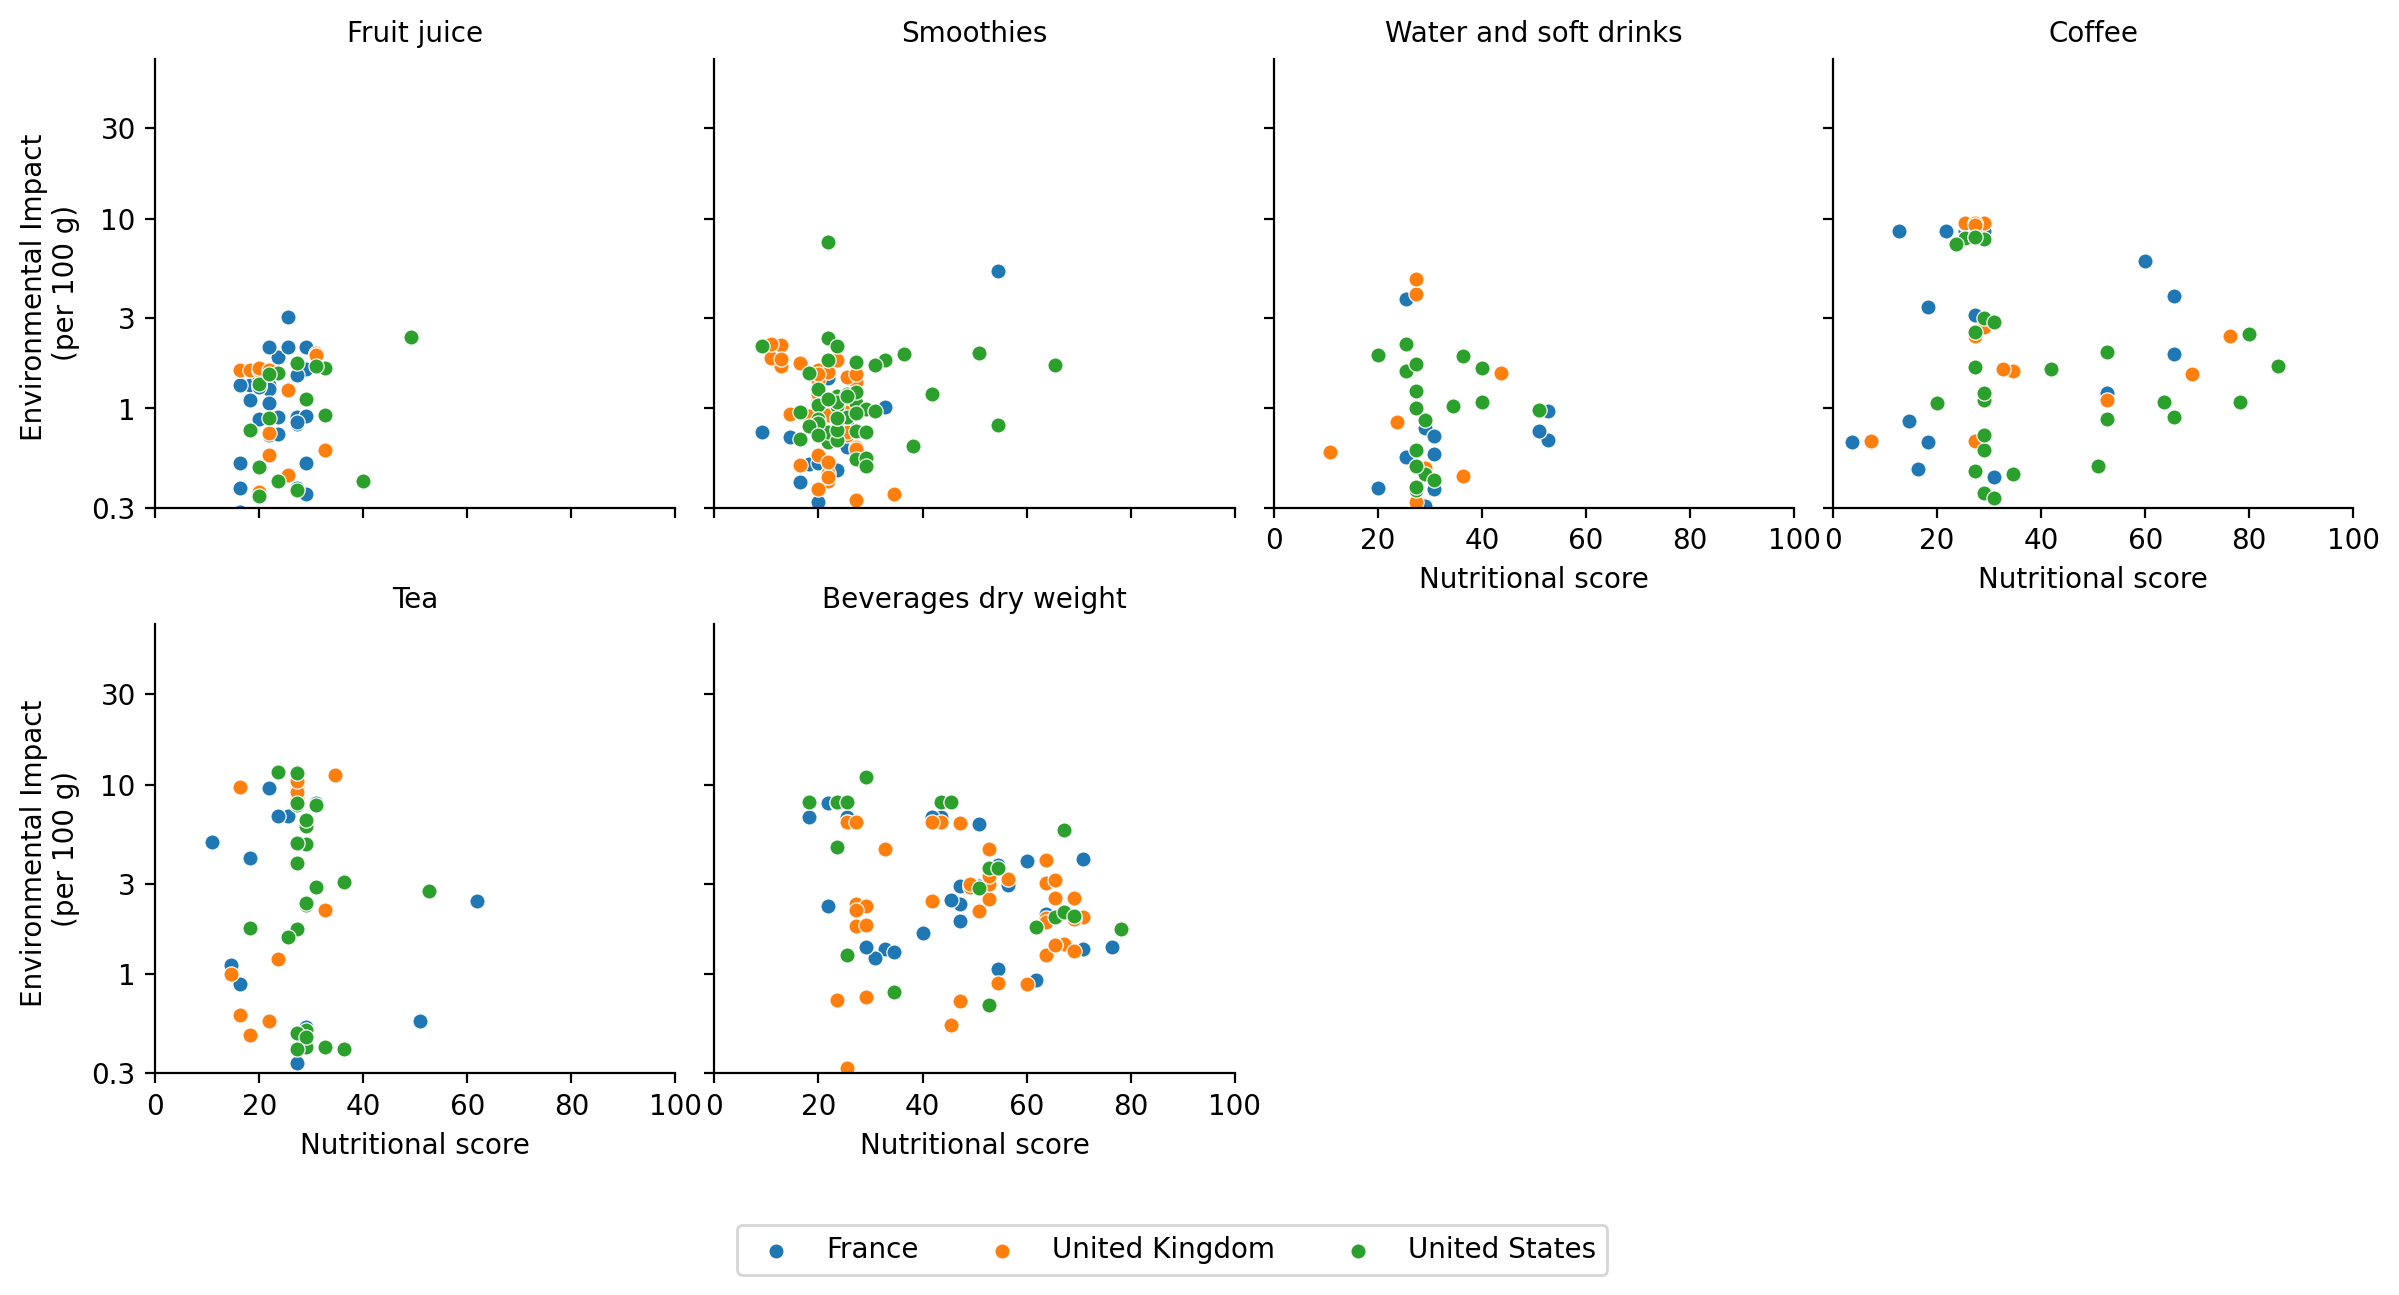

In [131]:
g = sns.FacetGrid(data=df[df['groups']=='Non-Alcoholic Beverages'].sort_values(by='ID'), 
                  col="labels", hue='country', 
                  hue_order = ['France', 'United Kingdom', 'United States'],
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm', s=30)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off()  
    ax.set_xlim(0, 100)
    ax.set_ylim(0.3, 70)

g.add_legend(title='', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()

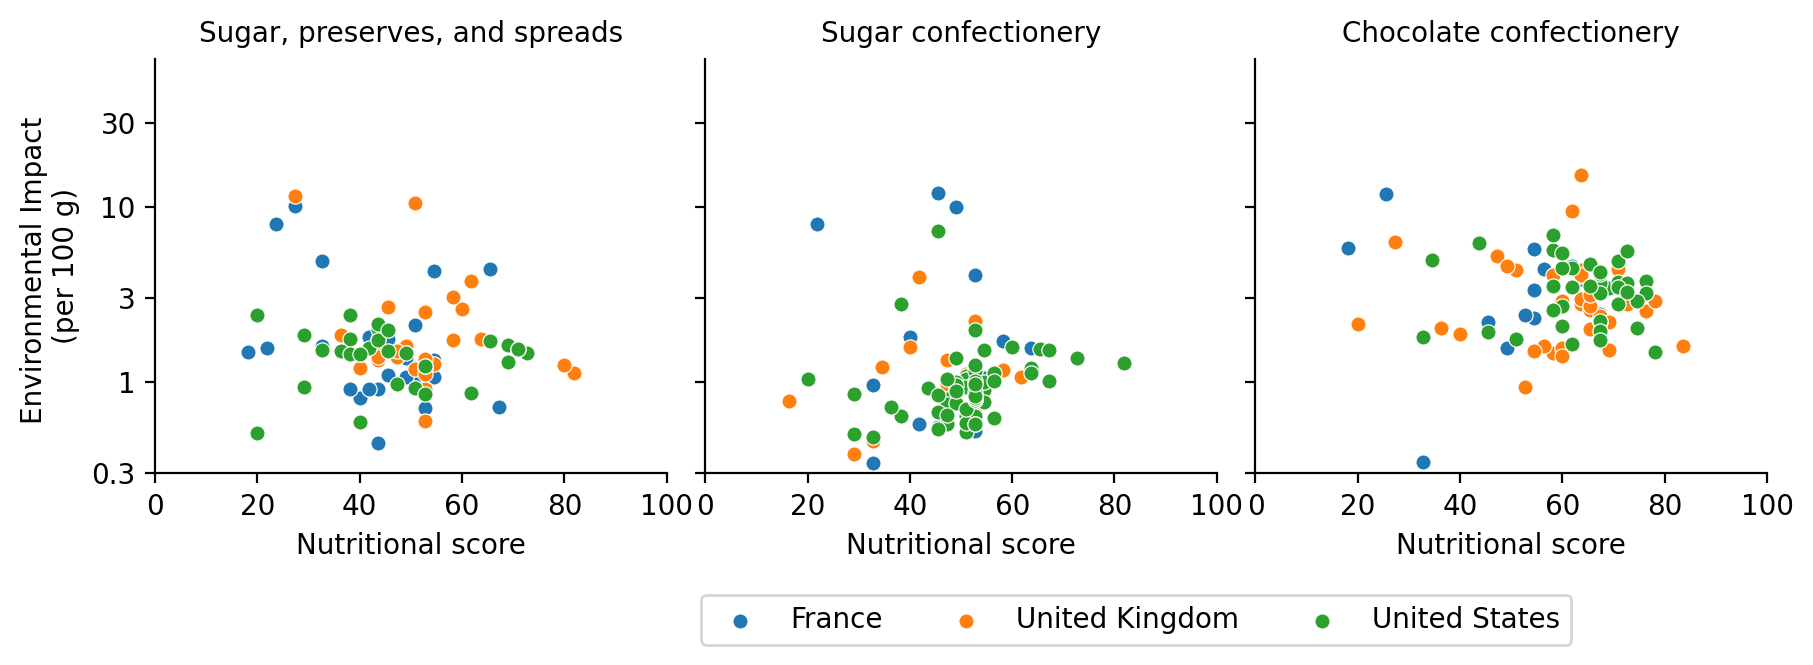

In [132]:
g = sns.FacetGrid(data=df[df['groups']=='Sugar and Confectionery'].sort_values(by='ID'), 
                  col="labels", hue='country', 
                  hue_order = ['France', 'United Kingdom', 'United States'],
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm', s=30)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off() 
    ax.set_xlim(0, 100)
    ax.set_ylim(0.3, 70)

g.add_legend(title='', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()

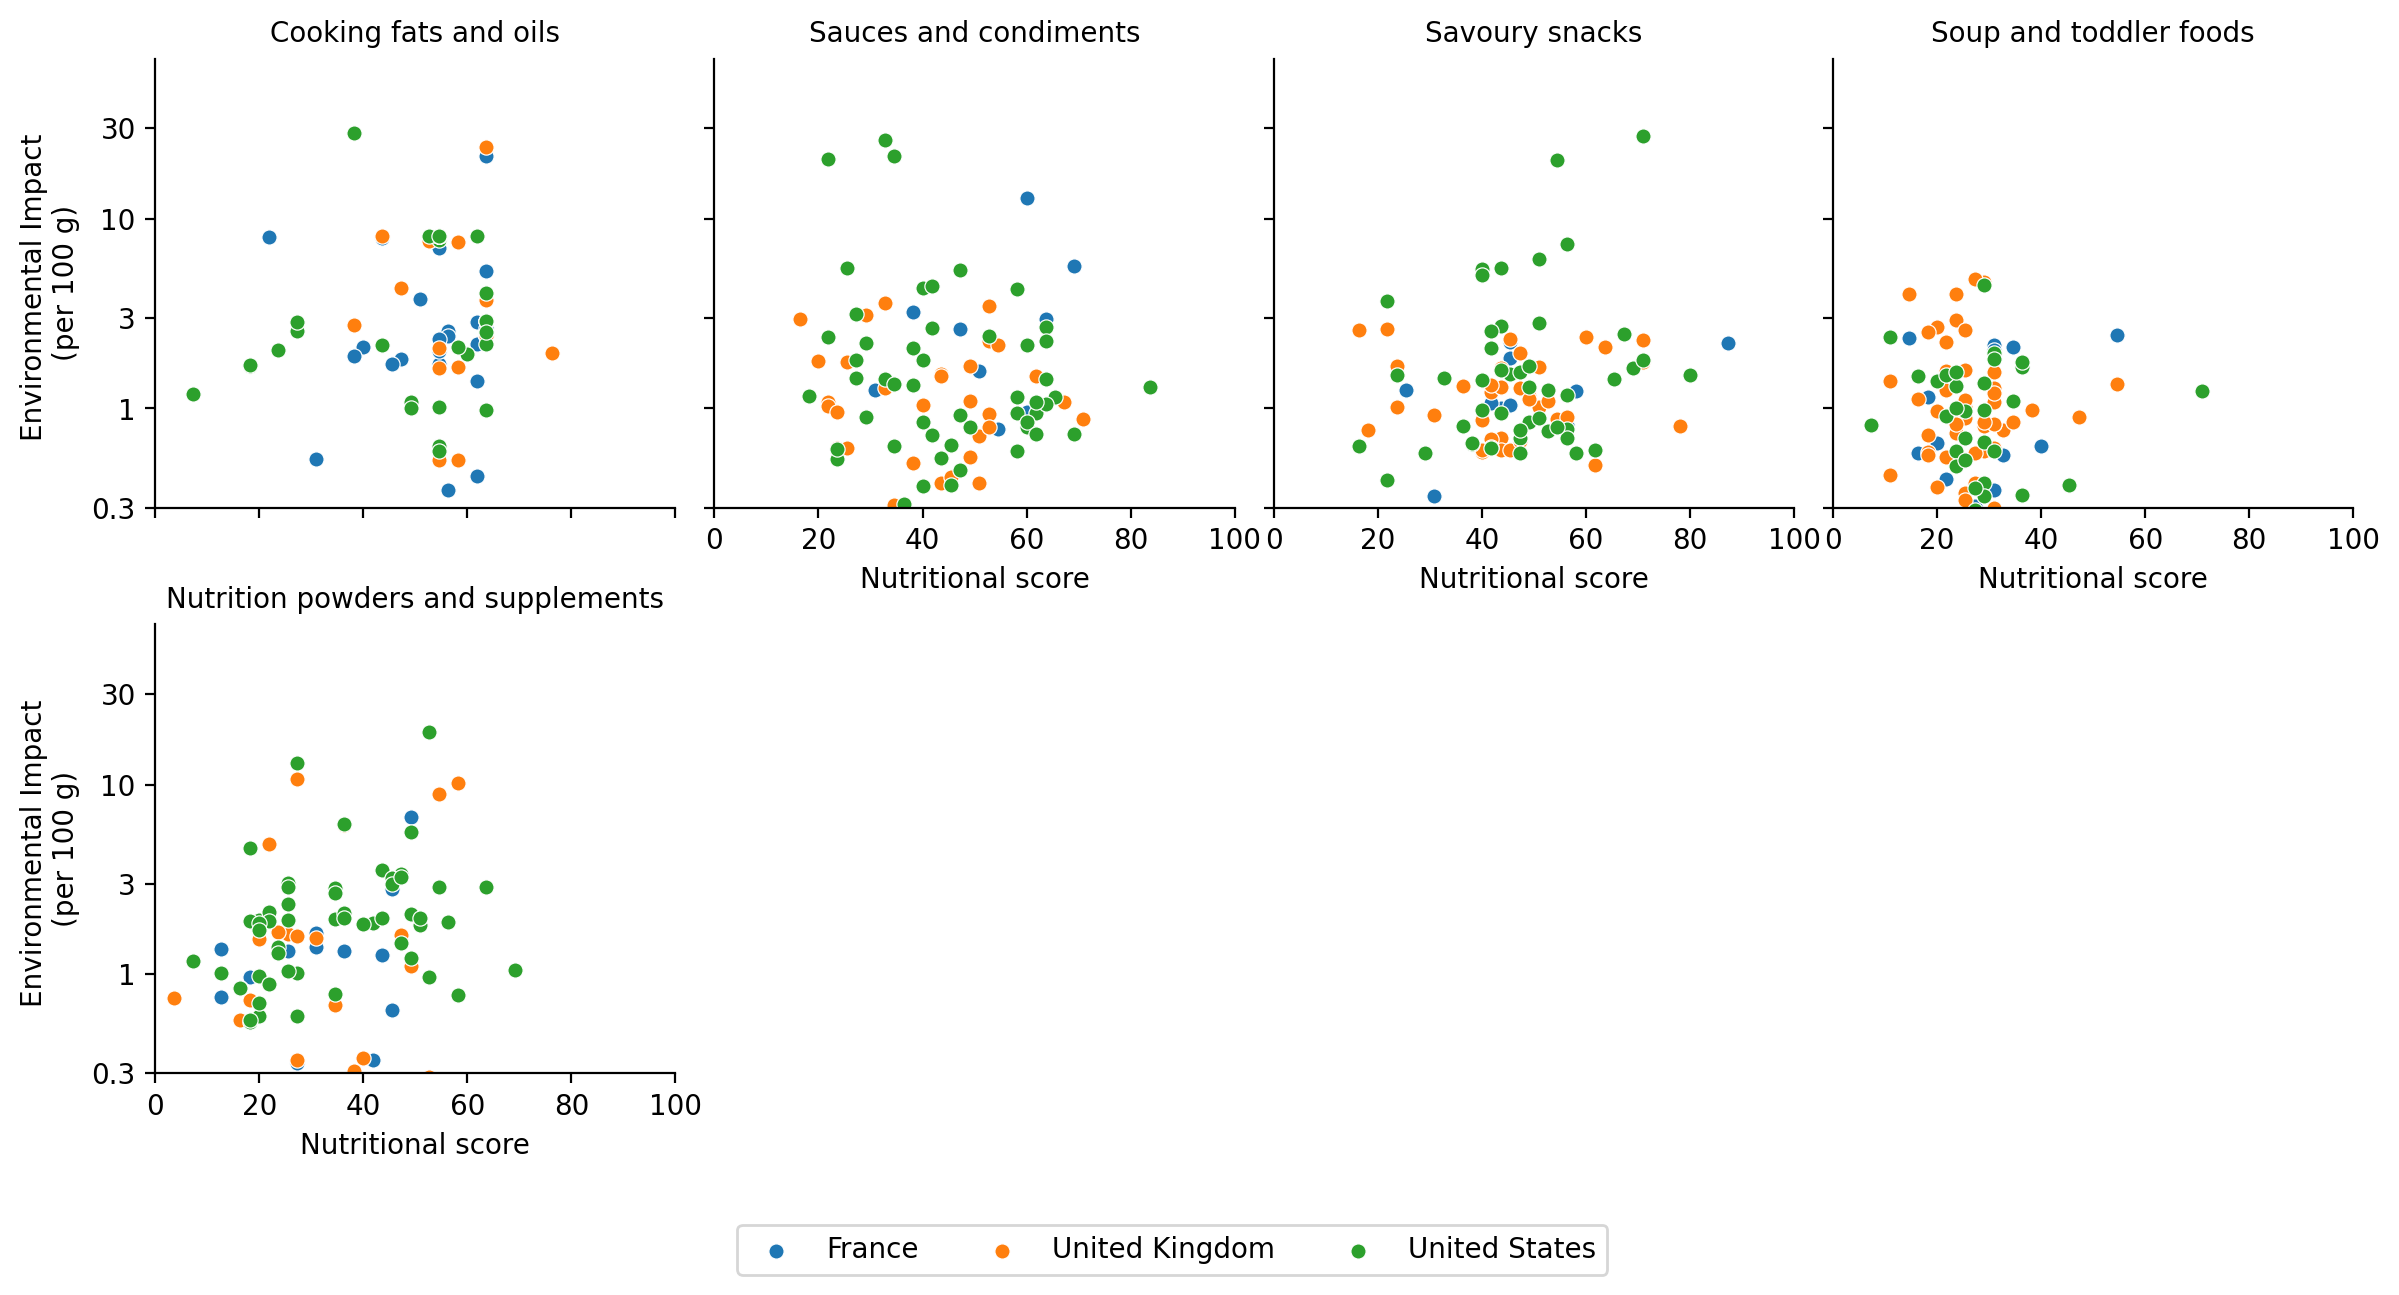

In [133]:
g = sns.FacetGrid(data=df[df['groups']=='Miscellaneous items'].sort_values(by='ID'), 
                  col="labels", hue='country', 
                  hue_order = ['France', 'United Kingdom', 'United States'],
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm', s=30)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off()  
    ax.set_xlim(0, 100)
    ax.set_ylim(0.3, 70)

g.add_legend(title='', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()